# Tutorial of network schematas - Bio Models
The network schematas for biological relevant boolean network models

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
#ABOVE added to use development version of cana
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
from cana.drawing import draw_canalizing_map_graphviz
from cana.drawing import draw_dynamics_canalization_map_graphviz
import matplotlib as mpl
import matplotlib.style
#mpl.style.use('classic')
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
import random
from copy import copy
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST, LEUKEMIA, BREAST_CANCER
from itertools import combinations
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess
#
import json
import ast
#BELOW added for graphviz to work on windows
os.environ["PATH"] += os.pathsep + "C:/Anaconda/pkgs/graphviz-2.38.0-4/Library/bin/"
os.environ["PATH"] += os.pathsep + 'C:/Anaconda/Library/bin/graphviz/'

In [3]:
def multi_column_display(objs, titles=['',''], cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'><h3>{{title}}</h3>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=obj,title=title) for obj,title in zip(objs,titles) ]
    cells += (cols - (len(objs)%cols)) * [html_cell.format(content="",title="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [3]:
#N=cana.BooleanNetwork.from_text('../cana/leukemia.txt') #leukemia network
#N=cana.BooleanNetwork.from_text('../cana/breast_cancer.txt') #breast cancer network
N3=LEUKEMIA()
N4=BREAST_CANCER()
NT = THALIANA()
N = DROSOPHILA()
NY = BUDDING_YEAST()
#N=cana.BooleanNetwork.from_text('../cana/binary_tree_example.txt',name='Binary Tree')
#N=cana.BooleanNetwork.from_text('../cana/HER3_tree_example.txt',name='HER3 Tree')
#N2=cana.BooleanNetwork.from_file('../cana/datasets/drosophila_parasegment.txt',file_type='logical')
#N5=cana.BooleanNetwork.from_file('../cana/datasets/marques-pita_rocha.txt')
#N5=cana.BooleanNetwork.from_file('../cana/marques-pita_rocha_update.txt', file_type='logical')
#N6=cana.BooleanNetwork.from_file('../cana/interaction_examples.txt',file_type='logical', name='Interactions')
#N7=cana.BooleanNetwork.from_file('../cana/module_example_OR.txt',file_type='logical', name='Module') #toy_motif_OR.txt
#N8=cana.BooleanNetwork.from_file('../cana/module_example_AND.txt',file_type='logical', name='Module')
#N9=cana.BooleanNetwork.from_file('../cana/module_example_NOR.txt',file_type='logical', name='Module')
#N10=cana.BooleanNetwork.from_file('../cana/module_example_literal.txt',file_type='logical', name='Module')
#NG=cana.BooleanNetwork.from_file('../cana/toy_GRN2.txt',file_type='logical', name='example')
print N

<BNetwork(Name='Drosophila Melanogaster', N=17, Nodes=['SLP', 'wg', 'WG', 'en', 'EN', 'hh', 'HH', 'ptc', 'PTC', 'PH', 'SMO', 'ci', 'CI', 'CIA', 'CIR', 'nhhnHH', 'nWG'])>


## Effective Graph

In [4]:
Nsg = N.structural_graph()

In [6]:
n=7
print N.nodes[n]
print N.nodes[n].look_up_table()
print N.nodes[n].schemata_look_up_table(type="ts")
print N.nodes[n].input_redundancy(norm=False,mode="node",bound="upper")

<BNode(name='ptc', k=3, inputs=[EN,CIA,CIR], state=0, outputs='[0,0,1,0,0,0,0,0]' constant=False)>
   In:  Out:
0  000     0
1  001     0
2  010     1
3  011     0
4  100     0
5  101     0
6  110     0
7  111     0
     In:  Out:
0  1̊##̊     0
1    #0#     0
2    010     1
1.75


In [5]:
#Node Position for each one of the models
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
print nodes
att = {}

if N.name == 'Arabidopsis Thaliana':
    foldername = 'thaliana'
    
    # Calculates Node position in a circle. Used to plot nodes always in the same position.
    for deg,name in zip(range(0,360,30), ['AG', 'AP3', 'PI', 'AP2', 'TFL1', 'FUL', 'AP1', 'FT', 'EMF1', 'LFY', 'SEP', 'WUS']):
        r = 150
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        att[name] = {'x':x,'y':y}
    # Nodes not on the circle. Manually position them = UFO, LUG, CLF
    for name,(x,y) in zip(['UFO','LUG','CLF'], [(200.,140.),(240.,50.),(240.,-50.)]):
        att[name] = {'x':x,'y':y}

elif N.name == 'Drosophila Melanogaster':
    foldername = 'drosophila'
    
    x,y = np.linspace(0,500,8,dtype=int), np.linspace(500,0,8,dtype=int)
    att['nWG']    = {'x':x[5],'y':y[0],'color':'orangered'} #'fillcolor':'#4f6fb0'
    att['SLP']    = {'x':x[7],'y':y[1],'color':'orangered','fillcolor':'grey70'} #'fillcolor':'#4f6fb0'
    att['en']     = {'x':x[5],'y':y[1]}
    att['EN']     = {'x':x[5],'y':y[2]}
    att['nhhnHH'] = {'x':x[1],'y':y[4]}
    att['ci']     = {'x':x[4],'y':y[3],'fillcolor':'grey70'}
    att['PTC']    = {'x':x[2],'y':y[4],'fillcolor':'grey70'}
    att['nhhnHH'] = {'x':x[2],'y':y[2],'color':'orangered'} #'fillcolor':'#4f6fb0'
    att['CI']     = {'x':x[4],'y':y[4],'fillcolor':'grey70'}
    att['PH']     = {'x':x[0],'y':y[5],'fillcolor':'grey70'}
    att['SMO']    = {'x':x[1],'y':y[5]}
    att['CIA']    = {'x':x[3],'y':y[5],'fillcolor':'grey70'}
    att['CIR']    = {'x':x[4],'y':y[5],'fillcolor':'grey70'}
    att['ptc']    = {'x':x[3],'y':y[6],'fillcolor':'grey70'}
    att['wg']     = {'x':x[4],'y':y[6],'fillcolor':'grey70'}
    att['hh']     = {'x':x[6],'y':y[6]}
    att['WG']     = {'x':x[4],'y':y[7],'fillcolor':'grey70'}
    att['HH']     = {'x':x[6],'y':y[7]}

elif N.name == 'Budding Yeast Cell Cycle':
    foldername = 'yeast'
    
    # Calculates Node position in a circle.
    for deg,name in zip( np.linspace(0,360,10), ['Cln3','MBF','Clb5,6','Mcm1/SFF','Swi5','Cdc20/14','Cdh1','Cln1,2','SBF']):
        r = 190
        deg += 90
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        att[name] = {'x':x,'y':y}
    # Nodes not on the circle. Manually position them = UFO, LUG, CLF
    for name,(x,y) in zip(['CellSize','Sic1','Clb1,2'], [(0.,280.),(0.,100.),(0.,-50.)]):
        att[name] = {'x':x,'y':y}

elif N.name == 'Binary Tree':
    x,y = np.linspace(0,500,15,dtype=int), np.linspace(300,0,4,dtype=int)
    att['SLP']    = {'x':x[7],'y':y[0]}
    att['SLP_LOW']    = {'x':x[3],'y':y[1]}
    att['SLP_HIGH']     = {'x':x[11],'y':y[1]}
    att['SLP_Q1']     = {'x':x[1],'y':y[2]}
    att['SLP_Q2'] = {'x':x[5],'y':y[2]}
    att['SLP_Q3']     = {'x':x[9],'y':y[2]}
    att['SLP_Q4']    = {'x':x[13],'y':y[2]}
    att['SLP_0'] = {'x':x[0],'y':y[3]}
    att['SLP_1']     = {'x':x[2],'y':y[3]}
    att['SLP_2']     = {'x':x[4],'y':y[3]}
    att['SLP_3']    = {'x':x[6],'y':y[3]}
    att['SLP_4']    = {'x':x[8],'y':y[3]}
    att['SLP_5']    = {'x':x[10],'y':y[3]}
    att['SLP_6']    = {'x':x[12],'y':y[3]}
    att['SLP_7']     = {'x':x[14],'y':y[3]}
    
elif N.name == 'HER3 Tree':
    x,y = np.linspace(0,500,7,dtype=int), np.linspace(500,0,3,dtype=int)
    att['HER3_012']    = {'x':x[3],'y':y[0],'fillcolor':'#4f6fb0'}
    att['HER3_01']    = {'x':x[1],'y':y[1],'fillcolor':'#4f6fb0'}
    att['HER3_2']     = {'x':x[5],'y':y[1],'fillcolor':'#4f6fb0'}
    att['HER3_0']     = {'x':x[0],'y':y[2],'fillcolor':'#4f6fb0'}
    att['HER3_1'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0'}
    
        
else:
    foldername = 'networks'

    # Calculates Node position in a circle for any network
    for deg,name in zip( np.linspace(0,360,len(nodes.keys())), nodes.keys()):
        r = 150
        #deg += 90
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        if name=='X':
            att[name] = {'x':x,'y':y,'fillcolor':'#4f6fb0'}
        else:
            att[name] = {'x':x,'y':y,}
    
    #rectangular alternate    
    #x,y = np.linspace(0,500,10,dtype=int), np.linspace(500,0,10,dtype=int)
    #for i,node in enumerate(nodes):
    #    att[node] = {'x':x[i/10],'y':y[i%10]}

{'wg': 1, 'WG': 2, 'ci': 11, 'en': 3, 'nWG': 16, 'ptc': 7, 'SLP': 0, 'HH': 6, 'CI': 12, 'SMO': 10, 'CIR': 14, 'hh': 5, 'EN': 4, 'nhhnHH': 15, 'PH': 9, 'PTC': 8, 'CIA': 13}


In [44]:
#Alternate
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
n = len(nodes)
att = {}

ctr_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if i in [51,57,58,73,74,75,76,77,78,79]}
ALR = ctr_nodes.keys()
in1_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if Nsg.out_degree(i)==2 and i not in ALR}
ALR.extend(in1_nodes.keys())
in2_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if Nsg.out_degree(i)==3 and i not in ALR}
ALR.extend(in2_nodes.keys())
out_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if i not in ALR}

n_in1 = len(in1_nodes)
n_in2 = len(in2_nodes)
n_out = len(out_nodes)
n_ctr = len(ctr_nodes)
r_ctr = 2
r_in1 = 3
r_in2 = 4
r_out = 5

ctr = max([r_in1,r_out,r_ctr])/2

for deg,(nid,label) in zip( np.linspace(0,360,n_in1,False), in1_nodes.items()):
    x, y = round(ctr + r_in1*math.cos(math.radians(deg)),2), round(ctr + r_in1*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[label] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_in2,False), in2_nodes.items()):
    x, y = round(ctr + r_in2*math.cos(math.radians(deg)),2), round(ctr + r_in2*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[label] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_out, False), out_nodes.items()):
    x, y = round(ctr + r_out*math.cos(math.radians(deg)),2), round(ctr + r_out*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[label] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_ctr,False), ctr_nodes.items()):
    x, y = round(ctr + r_ctr*math.cos(math.radians(deg)),2), round(ctr + r_ctr*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[label] = {'label':label,'pos':pos,'fillcolor':'red', 'width':'.99', 'shape':'oval'}
    

Nodes: 17 | Edges: 32


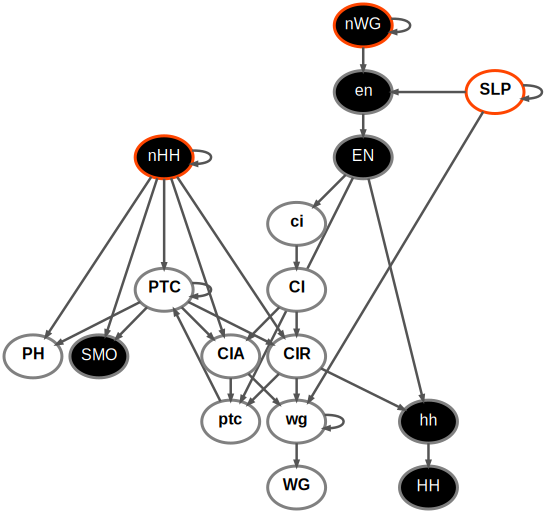

1

In [6]:
# Draw the Structural Graph
#print Nsg.nodes(data=True)
S = graphviz.Digraph(name='Structural Graph', engine='neato')
S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false')
S.attr('node', shape='oval', fixedsize='true', width='.80', color='gray', style='filled', fillcolor='#515660', penwidth='3', 
       fontname='Helvetica', fontcolor='white',fontsize='16',height='.60')
S.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for node,d in Nsg.nodes(data=True):
    
    if d['label'] in att:
        natt = att[d['label']]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
        if 'color' in natt:
            color=natt['color']
        else:
            color = 'gray'
    else:
        xy = 'false'
        fillcolor = '#515660'
    if fillcolor=='grey70': 
        fontcolor='black' #text for OFF nodes #fontcolor='#3a3d44'
        d['label']='< <B>'+d['label']+'</B> >' #BOLD the label
        fillcolor='white' #change fillcolor
    else: 
        fontcolor='white' #text for ON nodes
        fillcolor='black' #change fillcolor
    if d['label']=='nhhnHH': d['label']='nHH' #shorten the name for readability
    S.node(name=str(node), label=d['label'], pos=xy, fillcolor=fillcolor,color=color,fontcolor=fontcolor)

#alternate
#for node,d in Nsg.nodes(data=True):
#    natt = att[d['label']]
#    S.node(name=str(nid), **natt)    
    
max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    #if s==t: continue #include this line to get rid of self-loops
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, )
print 'Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) )
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})
# Export
S._format = 'png' #'svg'
efile = u"%s/../experiments/2017 - BioModels/%s/graphs/SG" % (os.getcwd(),foldername)
S.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [7]:
DCM = N.dynamics_canalization_map(output=None, )
D = draw_dynamics_canalization_map_graphviz(DCM, overlap='true',)
#display(D)

In [11]:
attractors=attractors_to_dict(N)

['SLP', 'wg', 'WG', 'en', 'EN', 'hh', 'HH', 'ptc', 'PTC', 'PH', 'SMO', 'ci', 'CI', 'CIA', 'CIR', 'nhhnHH', 'nWG']


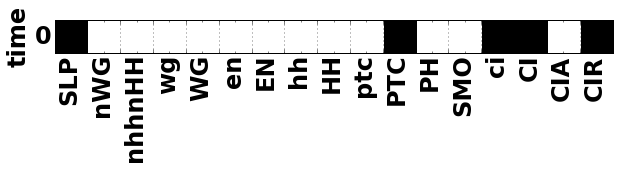

In [47]:
#visualize drosophila attractors
#for attractor in attractors: print sorted(attractors[attractor]-{'nhhnHH-1','nhhnHH-0','nWG-1','nWG-0','SLP-1','SLP-0'})
print [var.name for var in N.nodes]
nodes=['SLP','nWG','nhhnHH','wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
for i,attractor in enumerate(attractors): 
    #print attractor,list(attractors[attractor])
    if i==9: #show labels for the last attractor
        visualize_unfolding(DCM,list(attractors[attractor]),node_set=nodes,labels=True,fontsize=24,rotation=90,fontweight='bold')
    #plt.show()

In [10]:
#interaction examples
Nsg = NG.structural_graph()
print Nsg.nodes(data=True)
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
att = {}

if 'Interactions' in Nsg.name:
    x,y = np.linspace(0,500,6,dtype=int), np.linspace(500,0,3,dtype=int)
    att['A']    = {'x':x[0],'y':y[0],'fillcolor':'#4f6fb0','label':'A','shape':'oval'}
    att['B']    = {'x':x[1],'y':y[0],'fillcolor':'#4f6fb0','label':'B','shape':'oval'}
    att['C']     = {'x':x[2],'y':y[0],'fillcolor':'#4f6fb0','label':'C','shape':'oval'}
    att['B0']     = {'x':x[0],'y':y[1],'fillcolor':'#4f6fb0','label':'B-0','shape':'oval'}
    att['B1'] = {'x':x[1],'y':y[0],'fillcolor':'#4f6fb0','label':'B-1','shape':'oval'}
    att['D'] = {'x':x[0],'y':y[2],'fillcolor':'#4f6fb0','label':'D','shape':'oval'}
    att['E'] = {'x':x[1],'y':y[2],'fillcolor':'#4f6fb0','label':'E','shape':'oval'}
    att['T3'] = {'x':x[2],'y':y[1],'fillcolor':'#4f6fb0','label':'tau=3','shape':'oval'}
    att['F'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'F','shape':'oval'}
    att['G'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'G','shape':'oval'}
    att['T2'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'tau=2','shape':'oval'}
    att['H'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'H','shape':'oval'}
    att['C0'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'C-0','shape':'oval'}
    att['C1'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'C-1','shape':'oval'}
    att['T2_1'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'tau=2','shape':'oval'}
    att['I'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'I','shape':'oval'}
    att['J'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'J','shape':'oval'}
    att['K'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'K','shape':'oval'}
    att['T2_2'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'tau=2','shape':'oval'}
    att['L'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'L','shape':'oval'}
    att['M'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'M','shape':'oval'}
    
elif 'Motif' in Nsg.name: #toy motif
    x,y = np.linspace(0,500,5,dtype=int), np.linspace(500,0,5,dtype=int)
    att['X1']    = {'x':x[2],'y':y[0],'fillcolor':'#4f6fb0','label':'X1','shape':'circle'}
    att['X2']    = {'x':x[2],'y':y[2],'fillcolor':'#4f6fb0','label':'X2','shape':'circle'}
    att['X3']    = {'x':x[4],'y':y[4],'fillcolor':'#4f6fb0','label':'X3','shape':'circle'}
    att['X4']    = {'x':x[0],'y':y[4],'fillcolor':'#4f6fb0','label':'X4','shape':'circle'}

elif 'Module' in Nsg.name: #module example
    x,y = np.linspace(0,500,3,dtype=int), np.linspace(500,0,4,dtype=int)
    att['i1']    = {'x':x[0],'y':y[0],'fillcolor':'#4f6fb0','label':'i1','shape':'circle'}
    att['i2']    = {'x':x[2],'y':y[0],'fillcolor':'#4f6fb0','label':'i2','shape':'circle'}
    att['x']    = {'x':x[1],'y':y[1],'fillcolor':'#4f6fb0','label':'X','shape':'circle'}
    att['c']    = {'x':x[1],'y':y[2],'fillcolor':'#4f6fb0','label':'d','shape':'circle'}
    att['d']    = {'x':x[1],'y':y[3],'fillcolor':'#4f6fb0','label':'e','shape':'circle'}
    
elif 'example' in Nsg.name: #GRN example
    x,y = np.linspace(0,500,5,dtype=int), np.linspace(500,0,6,dtype=int)
    att['i1']    = {'x':x[3],'y':y[0],'fillcolor':'#4f6fb0','label':'i1','shape':'circle'}
    att['i2']    = {'x':x[0],'y':y[4],'fillcolor':'#4f6fb0','label':'i2','shape':'circle'}
    att['g1']    = {'x':x[2],'y':y[1],'fillcolor':'#4f6fb0','label':'g1','shape':'circle'}
    att['P1']    = {'x':x[2],'y':y[3],'fillcolor':'#4f6fb0','label':'P1','shape':'circle'}
    att['g2']    = {'x':x[3],'y':y[5],'fillcolor':'#4f6fb0','label':'g2','shape':'circle'}
    att['P2']    = {'x':x[1],'y':y[5],'fillcolor':'#4f6fb0','label':'P2','shape':'circle'}

[(0, {'label': 'i1'}), (1, {'label': 'i2'}), (2, {'label': 'g1'}), (3, {'label': 'P1'}), (4, {'label': 'g2'}), (5, {'label': 'P2'})]


Nodes: 6 | Edges: 8


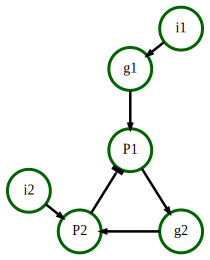

In [11]:
#draw interaction
if 'Interactions' in Nsg.name:
    S = graphviz.Digraph(name='Structural Graph', engine='dot')
    S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.5', ranksep='0.25', nodesep='0.95', 
           rankdir='LR') #left right for interactions
    S.attr('node', shape='oval', fixedsize='true', width='.80', color='gray', style='filled', fillcolor='#515660', penwidth='3', 
           fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
    S.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')
    keepers=['A','B1','B0','C','K','T2_2','L','M']
elif 'Motif' in Nsg.name or 'Module' in Nsg.name:
    S = graphviz.Digraph(name='Structural Graph', engine='neato')
    S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.5', ranksep='5', nodesep='50',)
    #S.attr('node', fixedsize='true', width='.60', color='gray', style='filled', fillcolor='#515660', penwidth='3', 
    #       fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
    S.attr('edge', arrowhead='normal', arrowsize='0.5', color='#545454')
    keepers=[Nsg.node[n]['label'] for n in Nsg.nodes()]
    keepers=['i1','i2','x']
    
elif 'example' in Nsg.name:
    S = graphviz.Digraph(name='Structural Graph', engine='neato')
    S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.1', ranksep='5', nodesep='50',)
    S.attr('node', fixedsize='true', width='.60')#, color='gray', style='filled', fillcolor='#515660', penwidth='3', 
    #       fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
    S.attr('edge', arrowhead='normal', arrowsize='0.5', color='#545454')
    keepers=[Nsg.node[n]['label'] for n in Nsg.nodes()]
    

for node,d in Nsg.nodes(data=True):

    if d['label'] in att:
        natt = att[d['label']]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
        fillcolor = '#515660'
    if d['label'] in keepers:
        S.node(name=str(node), label=natt['label'], pos=xy, fillcolor=fillcolor,shape=natt['shape'], color='darkgreen', penwidth='3')

#alternate
#for node,d in Nsg.nodes(data=True):
#    natt = att[d['label']]
#    S.node(name=str(nid), **natt)    

max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    if s==t: continue #include this line to get rid of self-loops
    #print Nsg.node[s]['label']
        
    if (Nsg.node[s]['label'] not in keepers) or (Nsg.node[t]['label'] not in keepers): 
        continue #include this line to view only interactions we want
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    if 'example' in Nsg.name and s==5 and t==3:
        S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, minlen='2', color='black', arrowhead='tee', arrowsize='1.0')
    else:
        S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, minlen='2', color='black')
print 'Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) )
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})

# Export
#S._format = 'pdf'
#efile = u"%s/../experiments/2017 - BioModels/%s/graphs/motif_structure" % (os.getcwd(),foldername)
#S.render(efile, cleanup=True)
#subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [12]:
#positional information for CMs/DCM
if 'Motif' in Nsg.name:
    
    x,y = np.linspace(0,500,5,dtype=int), np.linspace(500,0,5,dtype=int)
    #ON states
    att['X1-1']    = {'x':x[1],'y':y[0]}
    att['X2-1']    = {'x':x[2],'y':y[2],'peripheries':'2'}
    att['X3-1']     = {'x':x[4],'y':y[4]}
    att['X4-1']     = {'x':x[0],'y':y[3]}
    #OFF states
    att['X1-0']    = {'x':x[2],'y':y[0]}
    att['X2-0']    = {'x':x[2],'y':y[2],'peripheries':'2'}
    att['X3-0']     = {'x':x[4],'y':y[4]}
    att['X4-0']     = {'x':x[0],'y':y[4]}
    #other nodes
    att['T-1_X2-1'] = {'x':x[1],'y':y[2]}
    att['T-0_X2-0'] = {'x':x[2],'y':y[3]}
    att['F-0_T-1_X2-1'] = {'x':x[0],'y':y[2]} #OR condition
    att['F-0_T-0_X2-0'] = {'x':x[1],'y':y[2]} #

elif 'Module' in Nsg.name:
    
    x,y = np.linspace(0,500,7,dtype=int), np.linspace(500,0,9,dtype=int)
    #ON states
    att['a-1']    = {'x':x[0],'y':y[4],'label':'i1'} #'x':x[0],'y':y[1]
    att['b-1']     = {'x':x[2],'y':y[4],'label':'i2'} #'x':x[2],'y':y[1]
    att['x-1']    = {'x':x[3],'y':y[8],'peripheries':'2','label':'X'} #'x':x[1],'y':y[3]
    att['c-1']     = {'x':x[1],'y':y[4],'label':'c'} #'x':x[1],'y':y[4]
    att['d-1']     = {'x':x[1],'y':y[5],'label':'d'} #'x':x[1],'y':y[5]
    #OFF states
    att['a-0']    = {'x':x[4],'y':y[4],'label':'i1'} #'x':x[0],'y':y[0]
    att['b-0']     = {'x':x[6],'y':y[4],'label':'i2'} #'x':x[2],'y':y[0]
    att['x-0']    = {'x':x[3],'y':y[1],'peripheries':'2','label':'X'} #'x':x[1],'y':y[3]
    att['c-0']     = {'x':x[1],'y':y[4],'label':'c'} #'x':x[1],'y':y[4]
    att['d-0']     = {'x':x[1],'y':y[5],'label':'d'} #'x':x[1],'y':y[5]
    #other nodes
    att['T-1_x-1'] = {'x':x[1],'y':y[2]} #'x':x[1],'y':y[2]
    att['T-0_x-0'] = {'x':x[1],'y':y[2]} #'x':x[1],'y':y[2]
    att['F-0_T-1_x-1'] = {'x':x[1],'y':y[1]} #OR condition
    att['F-0_T-0_x-0'] = {'x':x[1],'y':y[1]} #OR condition
    #NOR condition
    att['T-1_x-0'] = {'x':x[5],'y':y[2]}
    att['T-2_x-1'] = {'x':x[3],'y':y[7]}
    att['F-0_T-2_x-0'] = {'x':x[5],'y':y[6]}
    att['F-0_T-2_x-1'] = {'x':x[1],'y':y[6]}
    
elif 'example' in Nsg.name:
    x,y = np.linspace(0,500,11,dtype=int), np.linspace(500,0,7,dtype=int)
    #ON states
    att['i1-1']    = {'x':x[10],'y':y[0],'label':'i1'}
    att['i2-1']     = {'x':x[1],'y':y[1],'label':'i2'}
    att['g1-1']    = {'x':x[9],'y':y[1],'peripheries':'2','label':'g1'}
    att['P1-1']     = {'x':x[6],'y':y[2],'label':'P1'}
    att['g2-1']     = {'x':x[4],'y':y[2],'label':'g2'}
    att['P2-1']     = {'x':x[1],'y':y[3],'label':'P2'}
    #OFF states
    att['i1-0']    = {'x':x[0],'y':y[6],'label':'i1'}
    att['i2-0']     = {'x':x[6],'y':y[5],'label':'i2'}
    att['g1-0']    = {'x':x[1],'y':y[5],'peripheries':'2','label':'g1'}
    att['P1-0']     = {'x':x[3],'y':y[4],'label':'P1'}
    att['g2-0']     = {'x':x[5],'y':y[4],'label':'g2'}
    att['P2-0']     = {'x':x[9],'y':y[3],'label':'P2'}
    #other nodes
    att['T-0_P2-0'] = {'x':x[8],'y':y[4]}
    att['T-1_P2-1'] = {'x':x[2],'y':y[2]}
    att['T-2_P1-1'] = {'x':x[8],'y':y[2]}
    att['F-0_T-0_P2-0'] = {'x':x[7],'y':y[4]}
    
#DCM = N7.dynamics_canalization_map(output=None, )
#D = draw_dynamics_canalization_map_graphviz(DCM, overlap='true',)
#display(D)

In [491]:
#positional information just for the OR condition
if False:
    x,y = np.linspace(0,500,7,dtype=int), np.linspace(500,0,9,dtype=int)
    #ON states
    att['i1-1']    = {'x':x[0],'y':y[0],'label':'i1','color':'green4'} #'x':x[0],'y':y[1]
    att['i2-1']     = {'x':x[2],'y':y[0],'label':'i2','color':'yellow4'} #'x':x[2],'y':y[1]
    att['x-1']    = {'x':x[1],'y':y[3],'peripheries':'2','label':'X','color':'yellow4'} #'x':x[1],'y':y[3]
    att['c-1']     = {'x':x[1],'y':y[4],'label':'c'} #'x':x[1],'y':y[4]
    att['d-1']     = {'x':x[1],'y':y[5],'label':'d'} #'x':x[1],'y':y[5]
    #OFF states
    att['i1-0']    = {'x':x[0],'y':y[1],'label':'i1','color':'orange4'} #'x':x[0],'y':y[0]
    att['i2-0']     = {'x':x[2],'y':y[1],'label':'i2','color':'yellow4'} #'x':x[2],'y':y[0]
    att['x-0']    = {'x':x[1],'y':y[3],'peripheries':'2','label':'X','color':'green4'} #'x':x[1],'y':y[3]
    att['c-0']     = {'x':x[1],'y':y[4],'label':'c'} #'x':x[1],'y':y[4]
    att['d-0']     = {'x':x[1],'y':y[5],'label':'d'} #'x':x[1],'y':y[5]
    #other nodes
    att['T-1_x-1'] = {'x':x[1],'y':y[2],'color':'yellow4'} #'x':x[1],'y':y[2]
    att['T-0_x-0'] = {'x':x[1],'y':y[2],'color':'orange'} #'x':x[1],'y':y[2]
    att['F-0_T-1_x-1'] = {'x':x[1],'y':y[1],'color':'yellow4'} #OR condition
    att['F-0_T-0_x-0'] = {'x':x[1],'y':y[1]} #OR condition

['i2-0', 'T-1_P2-1', 'i2-1', 'T-0_P2-0', 'g2-0', 'i1-1', 'i1-0', 'g2-1', 'P2-1', 'P2-0', 'T-2_P1-1', 'P1-0', 'P1-1', 'g1-1', 'g1-0', 'F-0_T-0_P2-0']
set(['i2-1', 'i2-0', 'P2-0', 'T-2_P1-1', 'i1-1', 'i1-0', 'F-0_T-0_P2-0', 'P2-1', 'T-1_P2-1', 'g1-1', 'g1-0', 'T-0_P2-0', 'g2-0', 'g2-1', 'P1-0', 'P1-1'])


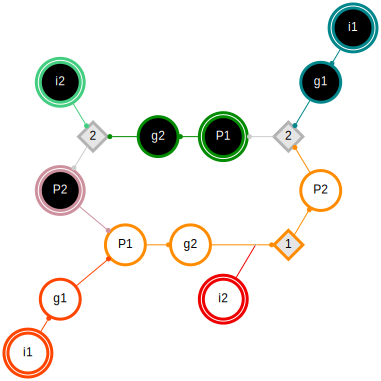

In [13]:
# Request the DCM to the Network
literal_edge_color='grey'
output_edge_color='grey'
fusing_edge_color='seagreen'
fused_edge_color='seagreen'
simplified_edge_color='grey'
faded=False #fade out edges not in our modules
#colored_nodes=['a-1','x-1','T-1_x-1','F-0_T-1_x-1'] #ON, OR condition
#colored_nodes=['a-0','b-0','x-0','T-0_x-0']  #OFF, OR condition
#colored_nodes=['a-1','b-1','x-0','T-0_x-0']  #OFF, XOR condition
#colored_nodes=['a-1','b-0','x-1','T-2_x-1','F-0_T-2_x-0','F-0_T-2_x-1']  #OFF, XOR condition
colored_nodes=['i1-0','g1-0','P1-0','g2-0','P2-0','T-0_P2-0','F-0_T-0_P2-0'] #subsumption
#colored_nodes=['i1-1','g1-1','P1-1','g2-1'] #independence
#colored_nodes=['P1-1','g2-1','P2-1'] #destruction
#colored_nodes=['P1-1','g2-1','P2-1','i2-1','P1-0','g2-0','P2-0','T-0_P2-0','F-0_T-0_P2-0','T-1_P2-1'] #synergy
#colored_nodes=['P1-1','g2-1','P2-1','i2-1','P1-0','g2-0','P2-0','T-0_P2-0','F-0_T-0_P2-0','T-1_P2-1','i1-1','g1-1','T-2_P1-1'] #limit cycle
#colored_nodes=[]
color='darkorange' #'lightblue3'; green4, gold3, '#b5d1e9', 'turquoise4', 'pink3'; 'darkorange', 'turquoise4', 'green4', 'cyan4'; 'seagreen'

DCM = NG.dynamics_canalization_map(output=None, ) #simplify=True
#colored_nodes=DCM.nodes() #information modules
#D = draw_dynamics_canalization_map_graphviz(DCM, overlap='true', literal_edge_color=literal_edge_color, output_edge_color=output_edge_color,
#                                            fusing_edge_color=fusing_edge_color, fused_edge_color=fused_edge_color,
#                                            simplified_edge_color=simplified_edge_color)
#S = graphviz.Digraph(name='Structural Graph', engine='neato')
#keepers=['X1-1','X2-1','X3-0','X4-1','T-1_X2-1','F-0_T-1_X2-1'] #ON transition for motif
keepers=DCM.nodes()
#keepers=['i1-1','i2-1','x-1','F-0_T-1_x-1','T-1_x-1'] #ON transition for module
#keepers=['i1-0','i2-0','x-0','T-0_x-0','F-0_T-0_x-0'] #OFF transition for module
#keepers=['T-2_x-1', 'F-0_T-2_x-0', 'F-0_T-2_x-1', 'x-0', 'x-1', 'b-0', 'b-1', 'a-1', 'a-0', 'T-1_x-0', 'T-0_x-0'] #XOR
print DCM.nodes()

T5=DCM  #create_threshold_network(DM5)
#D2 = draw_dynamics_canalization_map_graphviz(T5, overlap='true')
off_node_fontcolor,off_node_fillcolor='black','white',
on_node_fontcolor,on_node_fillcolor='white','black'
node_color,t_color='grey','#b5d1e9'
shape='circle'
skip_nodes=set([])

D = graphviz.Digraph(name='motif', engine='neato')
D.attr('graph', concentrate='false', simplify='false', overlap='False', splines='true', sep='+5')
D.attr('node', shape='circle', fixedsize='true', width='.55', color=node_color, style='filled', fillcolor='#515660', 
       penwidth='3', fontname='Helvetica', fontcolor='black',fontsize='12')
D.attr('edge', arrowhead='dot', arrowsize='.5', color='#545454', constraint='true')
#G.edge_attr.update(arrowhead='dot', color='gray', arrowsize='1', constraint='true')

#nodes
for node in T5:
    #print T5.node[node]
    if node not in keepers:
        continue
    if node in att:
        natt = att[node]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        #else:
        #    fillcolor = '#515660'
        if node in colored_nodes:
            node_color=color
            t_color=color
            #node_color=natt['color']
            faded_node=False
        elif faded:
            node_color='grey80'
            t_color='#b5d1e9'
            faded_node=True
        else:
            node_color='grey'
            t_color='#b5d1e9'
            faded_node=False
            
        #special cases
        if False:
            pass
        elif node=='i1-0' or node=='g1-0': #'i1-0','g1-0'; 'P1-1','g2-1'; 'P2-1'; none;
            node_color='orangered' #'orangered'; 'green4'; 'pink3'; none;
            #t_color='orangered'
            faded_node=False
        elif node=='P2-1':
            node_color='pink3'
        elif node=='i2-0':
            node_color='red2'
        elif node=='i2-1':
            node_color='seagreen3'
        elif node=='P1-1' or node=='g2-1':
            node_color='green4'
        elif node=='i1-1' or node=='g1-1':
            node_color='turquoise4'
        #elif node in ['P1-0','g2-0','T-0_P2-0','F-0_T-0_P2-0']: #, 'P2-0'
        #    node_color='#b5d1e9'
        #    t_color='#b5d1e9'
        #elif node=='T-1_P2-1':
        #    t_color='turquoise4'
        elif node=='T-1_P2-1' or node=='T-2_P1-1':
            t_color='grey70' #'#b5d1e9' 
        #elif node=='T-0_P2-0':
        #    t_color='grey70'
    #else:
    #    xy = 'false'
    #    fillcolor = '#515660'
    
    if T5.node[node]['type']=='variable': 
        
        if T5.node[node]['label']=='X2' or node=='P2-1' or node=='i1-0': #node=='P2-1' or node=='i1-0'
            peripheries='2'
        else:
            peripheries='1'
            
        #special case
        if node=='i1-1' or node=='i2-0' or node=='i2-1' or node=='P1-1':
            peripheries='2'
            

        if T5.node[node]['value'] == 0:
            D.node(name=node, label=natt['label'], pos=xy, peripheries=peripheries,
                   fontcolor=off_node_fontcolor, fillcolor=off_node_fillcolor, color=node_color, shape=shape)
        elif T5.node[node]['value'] == 1:
            if faded_node:
                D.node(name=node, label=natt['label'], pos=xy, peripheries=peripheries,
                   fontcolor=on_node_fontcolor, fillcolor='grey30', color=node_color, shape=shape)
            else:
                D.node(name=node, label=natt['label'], pos=xy, peripheries=peripheries,
                   fontcolor=on_node_fontcolor, fillcolor=on_node_fillcolor, color=node_color, shape=shape)
    elif T5.node[node]['type'] == 'threshold' and T5.node[node]['tau'] == 0:
        skip_nodes.add(node) #don't add this node
    elif T5.node[node]['type'] == 'threshold' and node[0]=='T': #traditional threshold node
        D.node(name=node, label=T5.node[node]['label'], shape='diamond', style='filled,solid', 
               fillcolor='grey90', fontcolor='black', color=t_color, width='.4', height='.4', pos=xy) #fillcolor='#dae8f4'
    elif T5.node[node]['type'] == 'threshold' and node[0]=='F': #combined threshold node from fusion node
        #print node,T5.node[node]
        D.node(name=node, label=T5.node[node]['label'], shape='circle', style='filled,solid', 
               fillcolor='#dae8f4', fontcolor='black', color=t_color, width='.4', height='.4', pos=xy)
    elif T5.node[node]['type'] == 'fusion': #doesn't happen in threshold network
        D.node(name=node, label='', shape='none', width='0', height='0', margin='0', pos=xy)
    #elif DCMS.node[node].get('label'):
    #    D.node(name=str(node), label=DCMS.node[node]['label'], pos=xy) #fillcolor=fillcolor
print set(T5.nodes())-skip_nodes
#edges
max_penwidth = 2.5
for s,t,d in T5.edges(data=True): #source, destination, weight
    #print s,t,d
    if t not in keepers: continue #include this line when only viewing a subset of the graph
    if s==t: continue #include this line to get rid of self-loops
    if s in skip_nodes or t in skip_nodes: continue #include this line to get rid of false 0-tau thresholds
    #weight = '%d' % (d['weight']*100)
    #penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    if s in colored_nodes: #and t in colored_nodes:
        #edge_color=att[s]['color']
        edge_color=color
        #edge_color='grey80'
    elif faded:
        edge_color='grey80'
    else:
        edge_color='grey'
        
    #special cases
    if False:
        pass
    elif s=='i1-0' or s=='g1-0': #'i1-0','g1-0'; 'P1-1','g2-1'; 'P2-1';
        edge_color='orangered' #'orangered'; 'green4'; 'pink3'; none;
    elif s=='P2-1':
        edge_color='pink3'
    elif s=='i2-0':
        edge_color='red2'
    elif s=='i2-1':
        edge_color='seagreen3'
    elif s=='P1-1' or s=='g2-1':
        edge_color='green4'
    elif s=='i1-1' or s=='g1-1':
        edge_color='turquoise4'
    #elif s in ['P1-0','g2-0','T-0_P2-0','F-0_T-0_P2-0']: #, 'P2-0'
    #    edge_color='#b5d1e9'
    #elif s=='T-1_P2-1':
    #    edge_color='turquoise4'
    elif s=='T-1_P2-1' or s=='T-2_P1-1':
        edge_color='grey80'
    #print d 
    if d['type'] == 'out' or d['type'] == 'literal' or d['type'] == 'simplified':
        D.edge(str(s),str(t),color=edge_color )
        
    elif d['type'] == 'fusing':
        #D.edge(str(s),str(t),color=fusing_edge_color, arrowhead='none' )
        D.edge(str(s),str(t),color=edge_color, arrowhead='none' )

    elif d['type'] == 'fused':
        #D.edge(str(s),str(t),color=fused_edge_color, arrowhead='dot' )
        D.edge(str(s),str(t),color=edge_color, arrowhead='dot' )
    
    else: #edges with 'fusion' nodes
        if T5.node[s]['type']=='threshold' and T5.node[t]['type']=='threshold': #line between threshold nodes
            D.edge(str(s),str(t),color=edge_color )
        else:
            D.edge(str(s),str(t),color='seagreen' )
    
display(D)
# Export
#D._format = 'pdf'
#efile = u"%s/../experiments/2017 - BioModels/%s/graphs/example_GRN_DCM_information_modules" % (os.getcwd(),foldername)
#D.render(efile, cleanup=True)
#subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [14]:
def plot_look_up_table(nid, n, filename=""):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    LUT = n.look_up_table().sort_index(ascending=False)
    # Count number of F in the LUT
    n_fs = LUT.shape[0]
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 120, 25, 25, 60, 25
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_fs*(cwidth+cyspace)-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + right)
    fheight = (bottom + ax1height + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='LUT')

    ### LUT Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for i,r in LUT.iterrows():
        ins = str(r['In:'])
        out = r['Out:']
        x = 0.
        xticks = []
        for input in ins:
            if input == '0':
                facecolor = 'white'
                textcolor = 'black'
            elif input == '1':
                facecolor = 'black'
                textcolor = 'white'      
            text = '%s'%(input)
            ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
            patches.append(r)
            xticks.append(x+cwidth/2)
            x += cwidth + cxspace

        x += sepcxspace
        r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
        ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
        ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
        patches.append(r)
        xticks.append(x+cwidth/2)
        yticks.append(y+cwidth/2)
        y += cwidth + cyspace

        #y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f_{%d}$"%(i+1) for i in range(n_fs)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputs + ['%s'%(n.name)], rotation=0, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border+right)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    # FileName
    #filename = n.name
    #filename = filename.replace('/','_')
    #filename = filename.replace(',','_')
    
    ## Display
    display(fig)
    
    ## Save to file
    if filename:
        plt.savefig('%s/../experiments/2017 - BioModels/networks/%s-%s' % (os.getcwd(), nid, filename), dpi=300)
    
    plt.close()

In [15]:
def plot_schemata(nid, n, filename=""):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    pi0s,pi1s = n._prime_implicants
    ts0s,ts1s = n._two_symbols
    # Count number of PI and TS
    n_pi = sum(len(pis) for pis in [pi0s,pi1s])
    n_ts = sum(len(tss) for tss in [ts0s,ts1s])
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 160, 25, 25, 60, 60
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_pi*(cwidth+cyspace)+sepcyspace-cyspace)
    ax2width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax2height = (n_ts*(cwidth+cyspace)+sepcyspace-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + ax2width + right)
    fheight = (bottom + max(ax1height,ax2height) + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax2w = ((ax2width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _ax2h = ((ax2height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='PI')
    ax2 = fig.add_axes((_left+_ax1w+_hs,_bottom,_ax2w,_ax1h), aspect=1, label='TS')

    ### PI Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for out,pis in zip([1,0],[pi1s,pi0s]):
        for pi in pis:
            x = 0.
            xticks = []
            for input in pi:
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'            
                text = '%s'%(input) if (input!='2') else '#'
                ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
                patches.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
            ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            patches.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
        y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f^{'}_{%d}$"%(i+1) for i in range(n_pi)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputs + ['%s'%(n.name)], rotation=0, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border+right)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    ## TS ##

    t = 0
    x,y = 0.,0.
    yticks = []
    boxes,symbols = [], []
    #
    tssymbols = [
        Circle((None,None), radius=5, facecolor='white', edgecolor='black'),
        RegularPolygon((None,None),numVertices=3, radius=5, orientation=0, facecolor='white', edgecolor='black'),
    ]
    #
    for out,tss in zip([1,0],[ts1s,ts0s]):
        for ts,pss,sss in tss:
            x = 0.
            xticks = []
            for i,input in enumerate(ts):
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'

                if len(pss):
                    # TODO: If there are several symbols in the same input position, place them side-by-side
                    iinpss = [j for j,ps in enumerate(pss) if i in ps]
                    xpos = np.linspace(x,x+cwidth, len(iinpss)+2)
                    for z,j in enumerate(iinpss,start=1):
                        s = copy(tssymbols[j])
                        s.xy = (xpos[z],y+cwidth*0.8)
                        s.center = xpos[z],y+cwidth*0.8 # A hack for circles only
                        s.set_edgecolor('#a6a6a6' if (input=='1') else 'black')
                        symbols.append(s)
                        ax2.add_patch(s)

                text = '%s'%(input) if (input!='2') else '#'
                ax2.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='#4c4c4c',zorder=2)
                boxes.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='#4c4c4c')
            ax2.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/2, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax2.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            boxes.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
            t += 1
        y += sepcyspace

    if len(boxes):
        ax2.add_collection(PatchCollection(boxes,match_original=True))
    if len(symbols):
        ax2.add_collection(PatchCollection(symbols,match_original=True))
    #
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([r"$f^{''}_{%d}$"%(i+1) for i in range(n_ts)[::-1]], fontsize=14)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(inputs + ['%s'%(n.name)], rotation=0, fontsize=14)
    #
    ax2.xaxis.tick_top()
    # Remove Tick
    ax2.tick_params(which='major',pad=7)
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax2.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Limits
    ax2.set_xlim(-border,ax2width+border+right)
    ax2.set_ylim(-border,ax2height+border)

    # FileName
    #filename = n.name.replace('/','_')
    #filename = filename.replace(',','_')
    
    ## Display ##
    display(fig)
    
    ## Save to file
    if filename:
        plt.savefig('%s/../experiments/2017 - BioModels/networks/%s-%s' % (os.getcwd(), nid, filename), dpi=300)
    
    plt.close()

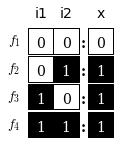

In [16]:
for nid,n in enumerate(N7.nodes):
    if n.name=='x':
        #display(HTML('<h2>'+n.name+'</h2>'))
        # Plot
        plot_look_up_table(nid,n,filename='LUT_OR.pdf')

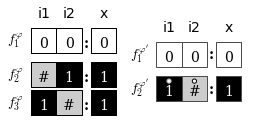

In [17]:
for nid,n in enumerate(N7.nodes):
    if n.name=='x':
        #display(HTML('<h2>'+n.name+'</h2>'))
        # Compute Prime Implicants & Two-Symbol schematas
        n._check_compute_canalization_variables(prime_implicants=True)
        n._check_compute_canalization_variables(two_symbols=True)
        # Plot
        plot_schemata(nid,n,filename='LUT_OR_schemata.pdf')

In [524]:
#make sure that OR/XOR modules make sense; confirmed
DCM = N9.dynamics_canalization_map(output=None, )
num=3
gci,mci,tmi,nmi=DCM_min_coverage(DCM,num=num,k=0,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])>=1: #nmi[top]
        seed=[s for s in nmi[top]]
        #reachables=unfolding_attractors(DM5,seed,attractors=attractors_toy,input_type='steady')
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),[x for t in tmi[top] for x in tmi[top][t]]
        #print "\tReachable attractors:",reachables[1]

if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})

 Running iteration: 1	
top modules found: 6
Running iteration: 2	
top modules found: 4
Running iteration: 3	
top modules found: 0
['a-0', 'b-0'] 	Length: 5 set(['a-0', 'b-0', 'x-0', 'c-1', 'd-1'])
['a-1', 'b-1'] 	Length: 5 set(['a-1', 'd-1', 'b-1', 'x-0', 'c-1'])
['a-0', 'b-1'] 	Length: 5 set(['d-0', 'a-0', 'b-1', 'x-1', 'c-0'])
['a-1', 'b-0'] 	Length: 5 set(['a-1', 'd-0', 'b-0', 'x-1', 'c-0'])
['x-1'] 	Length: 3 set(['d-0', 'x-1', 'c-0'])
['x-0'] 	Length: 3 set(['d-1', 'x-0', 'c-1'])
['a-0'] 	Length: 1 set(['a-0'])
['a-1'] 	Length: 1 set(['a-1'])
['b-1'] 	Length: 1 set(['b-1'])
['b-0'] 	Length: 1 set(['b-0'])
[0, None]


In [1470]:
#check toy network
DCMG = NG.dynamics_canalization_map(output=None, )
num=2
gci,mci,tmi,nmi=DCM_min_coverage(DCMG,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==num: #nmi[top]
        seed=[s for s in nmi[top]]
        #reachables=unfolding_attractors(DM5,seed,attractors=attractors_toy,input_type='steady')
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),[x for t in tmi[top] for x in tmi[top][t]]
        #print "\tReachable attractors:",reachables[1]

if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
    
seed=['P1-1', 'i2-1', 'i1-1']
print BFS_threshold(DCMG,seed,'steady',time_limit=1)

Running iteration: 1	
top modules found: 6
Running iteration: 2	
top modules found: 2
['i1-1', 'i2-0'] 	Length: 6 ['i1-1', 'i2-0', 'P2-0', 'g1-1', 'P1-1', 'g2-1']
['i2-1', 'P1-1'] 	Length: 4 ['i2-1', 'P1-1', 'g2-1', 'P2-1']
[6, ("['i1-1', 'i2-0']",)]
{0: set(['i2-1', 'i1-1', 'P1-1']), 1: set(['g2-1', 'g1-1', 'T-1_P2-1']), 2: set(['P2-1'])}


In [1481]:
#check for cover
print len(tmi)
nodes=[x for x in DCMG if DCMG.node[x]['type']=='variable']
cover,mc = graph_cover(tmi,nodes,q=4,approximate=False)
if cover:
    for c in cover: print c, len(c)
    score,max_cover=compare_cover_independence(DCMG,cover,nmi,attractors=None)
    #covers[str(num)]=max_cover
    print test_cover_independence(DCMG,max_cover,nmi),score
    
    #analyze cover
    lengths=[]
    for module in max_cover:
        lengths.append(len({x for t in tmi[module] for x in tmi[module][t]}))
    print lengths, np.mean(lengths), max(lengths)

else:
    print mc

8
("['i1-0']", "['i2-1', 'P1-1']", "['i1-1', 'i2-0']") 3
("['i1-0']", "['P2-1']", "['i2-1', 'P1-1']", "['i1-1', 'i2-0']") 4
("['i1-0']", "['P2-1']", "['i1-1', 'i2-0']", "['i2-1']") 4
("['i1-0']", "['i2-1', 'P1-1']", "['i1-1']", "['i1-1', 'i2-0']") 4
("['i1-0']", "['i2-1', 'P1-1']", "['i1-1']", "['i2-0']") 4
("['i1-0']", "['i2-1', 'P1-1']", "['P1-1']", "['i1-1', 'i2-0']") 4
("['i1-0']", "['i2-1', 'P1-1']", "['i1-1', 'i2-0']", "['i2-1']") 4
("['i1-0']", "['i2-1', 'P1-1']", "['i1-1', 'i2-0']", "['i2-0']") 4
{"['P1-1', 'i2-1']": 1.0, "['i1-1']": 1.0, "['i1-0']": 0.8, "['i2-0']": 0.5} 0.825
[5, 4, 2, 2] 3.25 5


[[56, 60, 62, 63, 59, 57], [58, 61], [0], [16], [46]] 5
['i1', 'i2', 'g1', 'P1', 'g2', 'P2']
101110 ['i2-0', 'i1-1', 'P2-0', 'g1-1', 'g2-1', 'P1-1']


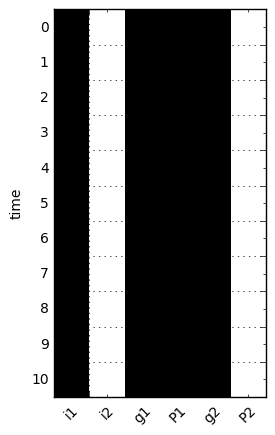

111000 ['i1-1', 'P2-0', 'g1-1', 'i2-1', 'g2-0', 'P1-0']


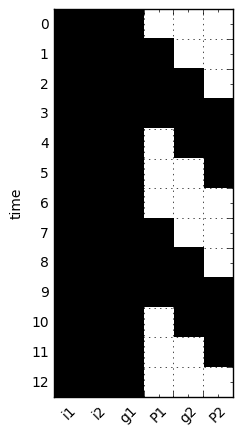

111010 ['i1-1', 'P2-0', 'g1-1', 'i2-1', 'g2-1', 'P1-0']


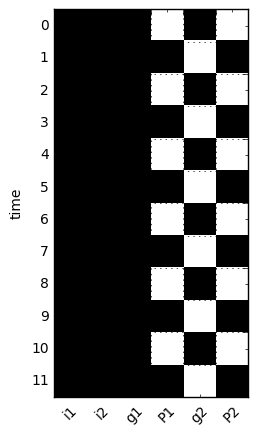

000000 ['i1-0', 'P2-0', 'i2-0', 'g1-0', 'g2-0', 'P1-0']


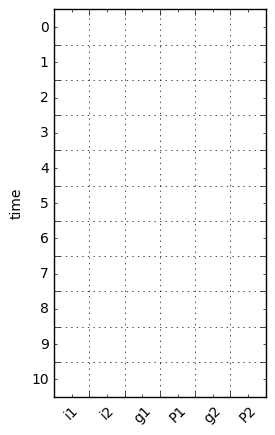

010000 ['i2-1', 'i1-0', 'P2-0', 'g1-0', 'g2-0', 'P1-0']


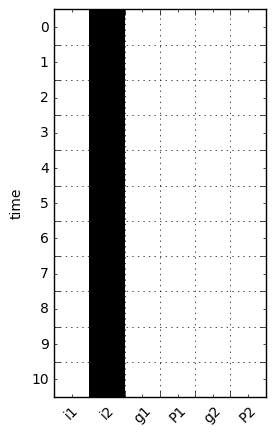

In [1469]:
#attractors
attractors_toy=attractors_to_dict(NG)
print NG.attractors(), len(attractors_toy)
print [var.name for var in NG.nodes]
for attractor in attractors_toy: 
    print attractor,list(attractors_toy[attractor])
    visualize_unfolding(DCMG,list(attractors_toy[attractor]),node_set=[var.name for var in NG.nodes],figsize=(5,5),
                        input_type='pulse',time_limit=10)
    plt.show()

In [1550]:
#analyze controllability
length=len(attractors_toy)
nlength=6
lengths=[] #hold minimal configuration lengths
drivers=set([])
input_type='pulse'
num=5
set_type='observe' #set type should be 'observe' or 'control', depending on how we want to analyze the network
gci,mci,tmi,nmi=DCM_min_coverage(DCMG,num=num,k=0,input_type=input_type,time_limit=1,conversion=True,seeds=None,
                                 ind_test=False,tops=False)
#for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
for attractor in attractors_toy:
    found=False
    for top in sorted(tmi, key=lambda x: len(nmi[x])): #start with smallest seeds to find minimal seed length
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DCMG,seed,attractors=attractors_toy,input_type=input_type)
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*length)==1:
            l=len({x for t in tmi[top] for x in tmi[top][t]})
            al=len({DCMG.node[x]['label'] for t in tmi[top] for x in tmi[top][t] if DCMG.node[x]['type']=='variable'})
            if set_type=='control' and al<nlength:
                continue #observable but not controlable
            print top,"\tLength:",l,#{x for t in tmi[top] for x in tmi[top][t]}
            print "\tReachable attractors:",int(reachables[1]*length)
            found=True #minimal driver set found
            lengths.append(len(nmi[top]))
            drivers=drivers.union(nmi[top])
            break
    if not found: print "No configuration to attractor found!", attractor
        
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

Running iteration: 1	
top modules found: 12
Running iteration: 2	
top modules found: 72
Running iteration: 3	
top modules found: 296
Running iteration: 4	
top modules found: 882
Running iteration: 5	
top modules found: 1478
['i1-1', 'i2-0'] 	Length: 6 	Reachable attractors: 1
['i2-1', 'i1-1', 'P2-0', 'g1-1', 'P1-1'] 	Length: 9 	Reachable attractors: 1
['g1-0', 'g2-0', 'P1-1'] 	Length: 6 	Reachable attractors: 1
['i2-0', 'P1-0'] 	Length: 4 	Reachable attractors: 1
['i1-0', 'i2-1'] 	Length: 6 	Reachable attractors: 1
5 2.8 5 2
set(['i2-0', 'i2-1', 'i1-1', 'i1-0', 'P2-0', 'g1-1', 'g1-0', 'g2-0', 'P1-0', 'P1-1'])


In [1551]:
#compare to FVS
fvs=NG.feedback_vertex_set_driver_nodes() #method='bruteforce'
for x in fvs:
    for node in sorted(x): 
        print NG.nodes[node]

<BNode(name='i1', k=1, inputs=[i1], state=0, outputs='[0,1]' constant=False)>
<BNode(name='i2', k=1, inputs=[i2], state=0, outputs='[0,1]' constant=False)>
<BNode(name='g1', k=1, inputs=[i1], state=0, outputs='[0,1]' constant=False)>


In [28]:
# Calculate Effective Graph
threshold = 0.00
Neg = N.effective_graph(mode='input',bound='upper', threshold=threshold)

Nodes: 17 | Edges: 32


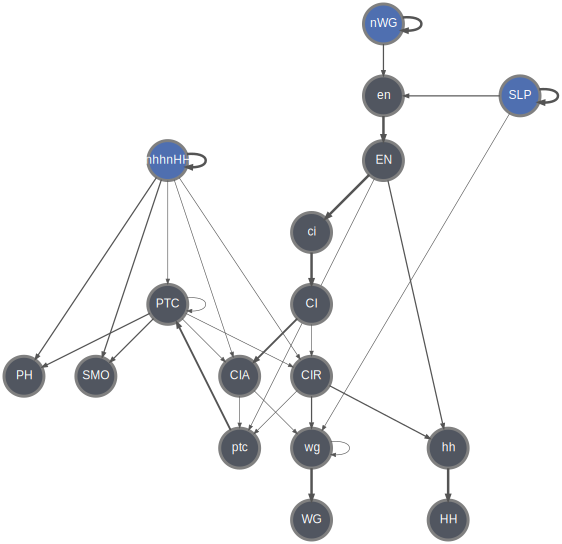

1

In [29]:
# Draw the Effective Graph
E = graphviz.Digraph(name='Effective Graph', engine='neato')
E.attr('graph', concentrate='false', simplify='false')
E.attr('node', shape='circle', fixedsize='true', width='.55', color='grey', style='filled', fillcolor='#515660', penwidth='3', 
       fontname='Helvetica', fontcolor='white',fontsize='12')
E.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for node,d in Neg.nodes(data=True):
    if d['label'] in att:
        natt = att[d['label']]
        x,y = natt['x'],natt['y']
        xy = '%.1f,%.1f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
    E.node(name=str(node), label=d['label'], pos=xy, fillcolor=fillcolor)

max_penwidth = 2.5
for s,t,d in Neg.edges(data=True):
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    E.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled)
    
print 'Nodes: %d | Edges: %d' % (len(Neg.nodes()) , len(Neg.edges()) )
# Display
display(SVG(E.pipe(format='svg')),metadata={'isolated':True})
# Export
E._format = 'svg'
efile = u'%s/../experiments/2017 - BioModels/%s/graphs/EG' % (os.getcwd(),foldername)
E.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [30]:
bound = 'upper'
print N.nodes[1].schemata_look_up_table(type="ts")
df = pd.DataFrame({
        'node':[n.name for n in N.nodes],
        'k':[n.k for n in N.nodes],
        'k_r':[n.input_redundancy(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_e':[n.effective_connectivity(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_s':[n.input_symmetry(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_r*':[n.input_redundancy(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_e*':[n.effective_connectivity(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_s*':[n.input_symmetry(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_e(out-d)':[Neg.out_degree()[n] for n in Neg.out_degree()],
        'k_e(out-s)':[Neg.out_degree(weight='weight')[n] for n in Neg.out_degree(weight='weight')],
    }).set_index('node')
df = df[['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)']]
print df

       In:  Out:
0  #̊0̊0̊#     0
1     ###1     0
2  #̊1̊1̊0     1
        k  k_r  k_e  k_s  k_r*  k_e*  k_s*  k_e(out-d)  k_e(out-s)
node                                                              
SLP     1    0    1    0     0     1     0           3         1.8
wg      4  2.2  1.8  2.2  0.56  0.44  0.56           2         1.2
WG      1    0    1    0     0     1     0           0           0
en      2 0.75  1.2    0  0.38  0.62     0           1           1
EN      1    0    1    0     0     1     0           3         1.8
hh      2 0.75  1.2    0  0.38  0.62     0           1           1
HH      1    0    1    0     0     1     0           0           0
ptc     3  1.8  1.2  1.3  0.58  0.42  0.44           1        0.75
PTC     3  1.5  1.5    1   0.5   0.5  0.33           5         1.8
PH      2 0.75  1.2    2  0.38  0.62     1           0           0
SMO     2 0.75  1.2    0  0.38  0.62     0           0           0
ci      1    0    1    0     0     1     0           1       

In [134]:
#calculate effective in and out degrees to compare to DCM path
eff_in_degree=[n.effective_connectivity(mode='input',bound=bound,norm=True) for n in N.nodes]
#neighbors=[Neg.neighbors(n) for n in Neg.nodes()]
#predecessors=[Neg.predecessors(n) for n in Neg.nodes()]
predecessors={i:[] for i in Neg.nodes()}
successors={i:[] for i in Neg.nodes()}
for edge in Neg.edges(): 
    predecessors[edge[1]].append(edge[0])
    successors[edge[0]].append(edge[1])
    
#print Neg.edges(), sorted(Neg.edges(), key=lambda x: x[1])
#note that edges are in the same order as per-input effective connectivities but networkx predecessors are not!
#effective in degree parallel with predecessors, effective out degree parallel with successors
eff_out_degree={i:[] for i in Neg.nodes()}
for i,inputs in enumerate(eff_in_degree):
    #node i has inputs with given effective connectivities; these edges must be translated to output dictionary
    for j,edge in enumerate(inputs):
        eff_out_degree[predecessors[i][j]].append(edge)#
#print eff_in_degree
#print predecessors
print successors
print eff_out_degree

#gather metrics
in_degrees=[n.effective_connectivity(mode='node',bound=bound,norm=True) for n in N.nodes]
avg_out_degrees,max_out_degrees=[0 for n in Neg.nodes()],[0 for n in Neg.nodes()]
for i,n in enumerate(Neg.nodes()):
    if eff_out_degree[n]:
        avg_out_degrees[i]=np.mean(eff_out_degree[n])
        max_out_degrees[i]=max(eff_out_degree[n])
sum_out_degrees=[sum(eff_out_degree[n]) for n in Neg.nodes()]
print "\n",in_degrees, sorted([i for i in range(len(N.nodes))], key=lambda x: in_degrees[x], reverse=True)
print avg_out_degrees, sorted([i for i in range(len(N.nodes))], key=lambda x: avg_out_degrees[x], reverse=True)
print max_out_degrees, sorted([i for i in range(len(N.nodes))], key=lambda x: max_out_degrees[x], reverse=True)
print sum_out_degrees, sorted([i for i in range(len(N.nodes))], key=lambda x: sum_out_degrees[x], reverse=True)
#print sorted(in_degrees, reverse=True)
#print sorted(avg_out_degrees, reverse=True)
#print sorted(max_out_degrees, reverse=True)
#print sorted(sum_out_degrees, reverse=True)

{0: [0, 1, 3], 1: [1, 2], 2: [], 3: [4], 4: [11, 5, 7], 5: [6], 6: [], 7: [8], 8: [8, 9, 10, 13, 14], 9: [], 10: [], 11: [12], 12: [13, 14], 13: [1, 7], 14: [1, 5, 7], 15: [8, 9, 10, 13, 14, 15], 16: [16, 3]}
{0: [1.0, 0.25, 0.5], 1: [0.25, 1.0], 2: [], 3: [1.0], 4: [0.5, 0.25, 1.0], 5: [1.0], 6: [], 7: [0.75], 8: [0.25, 0.5, 0.5, 0.25, 0.25], 9: [], 10: [], 11: [1.0], 12: [0.75, 0.25], 13: [0.25, 0.25], 14: [0.5, 0.5, 0.25], 15: [0.25, 0.5, 0.5, 0.25, 0.25, 1.0], 16: [0.5, 1.0]}

[1.0, 0.4375, 1.0, 0.625, 1.0, 0.625, 1.0, 0.4166666666666667, 0.5, 0.625, 0.625, 1.0, 1.0, 0.5, 0.4166666666666667, 1.0, 1.0] [0, 2, 4, 6, 11, 12, 15, 16, 3, 5, 9, 10, 8, 13, 1, 7, 14]
[0.58333333333333337, 0.625, 0, 1.0, 0.58333333333333337, 1.0, 0, 0.75, 0.34999999999999998, 0, 0, 1.0, 0.5, 0.25, 0.41666666666666669, 0.45833333333333331, 0.75] [3, 5, 11, 7, 16, 1, 0, 4, 12, 15, 14, 8, 13, 2, 6, 9, 10]
[1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.75, 0.5, 0, 0, 1.0, 0.75, 0.25, 0.5, 1.0, 1.0] [0, 1, 3, 4, 5, 11, 15, 1

In [135]:
#compare to DCM path lengths
DM=create_threshold_network(DCM)
variables={node for node in DM.nodes() if DM.node[node]['type']=='variable'}
positive_paths, negative_paths, unique_states = [],[],[]
for n in N.nodes:
    #print n.name
    unfolding_pos=BFS_threshold(DCM,[n.name+'-1'],'steady',time_limit=1)
    positive_paths.append( len({x for t in unfolding_pos for x in unfolding_pos[t]}.intersection(variables)) )
    unfolding_neg=BFS_threshold(DCM,[n.name+'-0'],'steady',time_limit=1)
    negative_paths.append( len({x for t in unfolding_neg for x in unfolding_neg[t]}.intersection(variables)) )
    unique_states.append({x for t in unfolding_pos for x in unfolding_pos[t]}.union({x for t in unfolding_neg for x in unfolding_neg[t]})
                      .intersection(variables))

print positive_paths, negative_paths

paths=zip(positive_paths, negative_paths)
avg_path=[np.mean([x[0],x[1]]) for x in paths]
max_path=[max([x[0],x[1]]) for x in paths]
sum_path=[sum([x[0],x[1]]) for x in paths] #for drosophila sum_path and sum_states identical, also just twice avg_path
sum_states=[len(x) for x in unique_states]
unique_vars=[{DM.node[node]['variable'] for node in s} for s in unique_states] #remove variable states
sum_vars=[len(x) for x in unique_vars] #for drosophila, this is nearly identical to max_path but differs in nhhnHH

print avg_path, sorted([i for i in range(len(N.nodes))], key=lambda x: avg_path[x], reverse=True)
print max_path, sorted([i for i in range(len(N.nodes))], key=lambda x: max_path[x], reverse=True)
#print sum_path, sorted([i for i in range(len(N.nodes))], key=lambda x: sum_path[x], reverse=True)
#print sum_states
print sum_vars, sorted([i for i in range(len(N.nodes))], key=lambda x: sum_vars[x], reverse=True)
#print sorted(avg_path, reverse=True)
#print sorted(max_path, reverse=True)
#print sorted(sum_vars, reverse=True)

[7, 2, 1, 9, 8, 2, 1, 2, 1, 1, 1, 2, 1, 1, 6, 3, 1] [1, 2, 1, 6, 5, 2, 1, 1, 4, 1, 1, 5, 4, 2, 1, 2, 7]
[4.0, 2.0, 1.0, 7.5, 6.5, 2.0, 1.0, 1.5, 2.5, 1.0, 1.0, 3.5, 2.5, 1.5, 3.5, 2.5, 4.0] [3, 4, 0, 16, 11, 14, 8, 12, 15, 1, 5, 7, 13, 2, 6, 9, 10]
[7, 2, 1, 9, 8, 2, 1, 2, 4, 1, 1, 5, 4, 2, 6, 3, 7] [3, 4, 0, 16, 14, 11, 8, 12, 15, 1, 5, 7, 13, 2, 6, 9, 10]
[7, 2, 1, 9, 8, 2, 1, 2, 4, 1, 1, 5, 4, 2, 6, 4, 7] [3, 4, 0, 16, 14, 11, 8, 12, 15, 1, 5, 7, 13, 2, 6, 9, 10]


In [137]:
#correlations between effective graph measures and DCM measures for drosophila
from scipy.stats import pearsonr
eff_measures=['in_degrees','avg_out_degrees','max_out_degrees','sum_out_degrees']
dcm_measures=['avg_path','max_path','sum_vars']

for m1 in eff_measures:
    for m2 in dcm_measures:
        print m1,m2,pearsonr(eval(m1),eval(m2))

in_degrees avg_path (0.19213056880515908, 0.46005256897660318)
in_degrees max_path (0.23114220079291484, 0.37206766943814185)
in_degrees sum_vars (0.25488288687150551, 0.32349749323716542)
avg_out_degrees avg_path (0.60730525507758404, 0.0097221897505764768)
avg_out_degrees max_path (0.58498901543761905, 0.013637063282907666)
avg_out_degrees sum_vars (0.5849312131783877, 0.013648608463292118)
max_out_degrees avg_path (0.64669925178491361, 0.0050236320309284248)
max_out_degrees max_path (0.64849204569384877, 0.0048645615714913003)
max_out_degrees sum_vars (0.67056708258829512, 0.0032179719166282633)
sum_out_degrees avg_path (0.50121348727407034, 0.040403496546858327)
sum_out_degrees max_path (0.55944083754908391, 0.019544507327833461)
sum_out_degrees sum_vars (0.61365375084769624, 0.0087907320702896325)


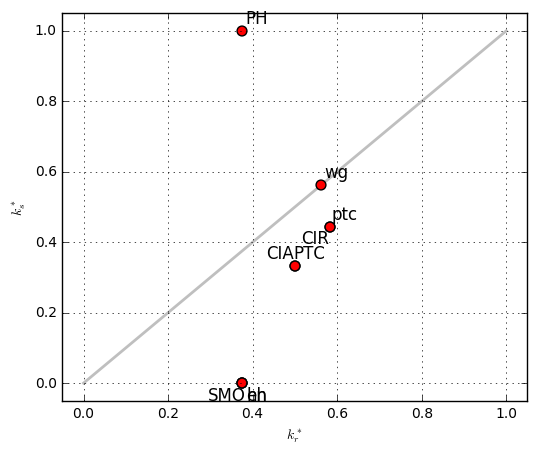

In [946]:
fig, ax = plt.subplots(1,1,figsize=(6,5), sharex=True, sharey=True)
dfp = df.loc[ (df['k']>1) , :]
ax.scatter(dfp['k_r*'],dfp['k_s*'], s=50, c='red', marker='o', zorder=2)
lx,ly = [],[]
quadrants = [-0.035,0.035]
for name, dfp_ in dfp.iterrows():
    x,y = dfp_['k_r*']+random.choice(quadrants) , dfp_['k_s*']+random.choice(quadrants)
    ax.annotate(name, (x,y),fontsize=12, va='center', ha='center')
    lx.append(x); ly.append(y)
ax.plot((0,1),(0,1),'black', lw=2,alpha=0.25, zorder=1)
ax.grid(True)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel('$k_r^*$')
ax.set_ylabel('$k_s^*$')
#plt.savefig('../experiments/2017 - BioModels/%s/plots/k_sn_vs_k_rn.png' % (foldername), dpi=150)

Inputs: ['SLP']
CM: SLP


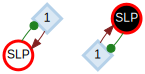

Inputs: ['SLP', 'wg', 'CIA', 'CIR']
CM: wg


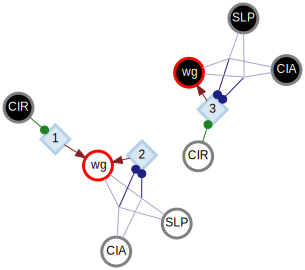

Inputs: ['wg']
CM: WG


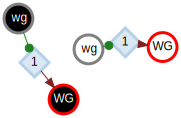

Inputs: ['SLP', 'nWG']
CM: en


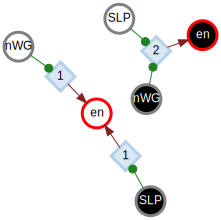

Inputs: ['en']
CM: EN


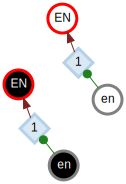

Inputs: ['EN', 'CIR']
CM: hh


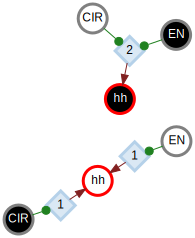

Inputs: ['hh']
CM: HH


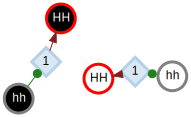

Inputs: ['EN', 'CIA', 'CIR']
CM: ptc


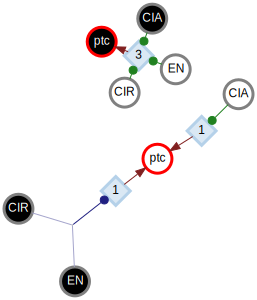

Inputs: ['ptc', 'PTC', 'nhhnHH']
CM: PTC


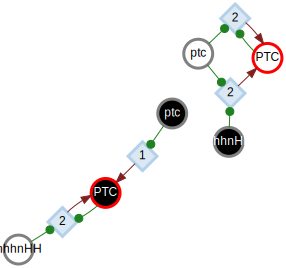

Inputs: ['PTC', 'nhhnHH']
CM: PH


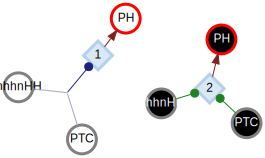

Inputs: ['PTC', 'nhhnHH']
CM: SMO


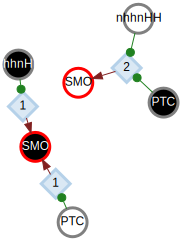

Inputs: ['EN']
CM: ci


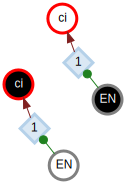

Inputs: ['ci']
CM: CI


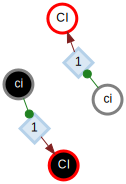

Inputs: ['PTC', 'CI', 'nhhnHH']
CM: CIA


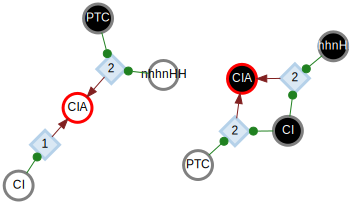

Inputs: ['PTC', 'CI', 'nhhnHH']
CM: CIR


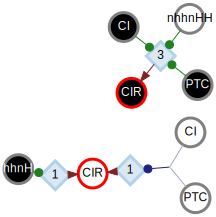

Inputs: ['nhhnHH']
CM: nhhnHH


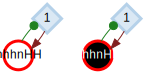

Inputs: ['nWG']
CM: nWG


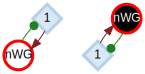

In [31]:
bound = 'upper'
for i,n in enumerate(N.nodes):
    display(HTML('<h2>'+n.name+'</h2>'))
    print 'Inputs:',n.inputs
    k = n.k
    k_r = n.input_redundancy(mode='node',bound=bound,norm=False)
    k_r_n = n.input_redundancy(mode='node',bound=bound,norm=True)
    k_e = n.effective_connectivity(mode='node', bound=bound, norm=False)
    k_s = n.input_symmetry(mode='node',bound=bound,norm=False)
    k_s_n = n.input_symmetry(mode='node',bound=bound,norm=True)
    
    dfS = pd.DataFrame([('k',k),('k_r',k_r),('k_e',k_e),('k_s',k_s),('k_r*',k_r_n),('k_s*',k_s_n)]).set_index(0).T
    #display(dfS)
    
    pi = n.schemata_look_up_table(type='pi',format='latex', ts_symbol_latex="\circ")
    ts = n.schemata_look_up_table(type='ts',format='latex', ts_symbol_latex="\circ")
    #display(Latex(pi))
    #display(Latex(ts))
    #multi_column_display([pi,ts],titles=['Prime Implicants','Two-Symbol Schemtas'],cols=4)

    # to make sure each SVG renders independently, add the "metadata={'isolated':True}
    CM = n.canalizing_map()
    gv = draw_canalizing_map_graphviz(CM)
    print CM
    display(SVG(gv.pipe(format='svg')),metadata={'isolated':True})

    # Export to .SVG
    filename = n.name
    filename = filename.replace(',','_')
    filename = filename.replace('/','_')
    gv._format = 'svg'
    #efile = u'%s/../experiments/2017 - BioModels/%s/CM/%s-%s' % (os.getcwd(),foldername,i,filename)
    #gv.render(efile, cleanup=True)
    #subprocess.call("inkscape -z -d 150 '%s.svg' -e '%s.png'" % (efile,efile) , shell=True)

    #break

In [18]:
#positional information for drosophila DCM
att={}

if N.name == 'Drosophila Melanogaster':
    foldername = 'drosophila'
    
    x,y = np.linspace(0,500,15,dtype=int), np.linspace(500,0,11,dtype=int)
    #ON states
    att['nWG-1']    = {'x':x[0],'y':y[2],'fillcolor':'#4f6fb0'}
    att['SLP-1']    = {'x':x[13],'y':y[3],'fillcolor':'#4f6fb0'}
    att['en-1']     = {'x':x[2],'y':y[3]}
    att['EN-1']     = {'x':x[4],'y':y[2]}
    att['nhhnHH-1'] = {'x':x[7],'y':y[2]}
    att['ci-1']     = {'x':x[10],'y':y[6]}
    att['PTC-1']    = {'x':x[8],'y':y[9]}
    att['CI-1']     = {'x':x[9],'y':y[5]}
    att['PH-1']     = {'x':x[7],'y':y[5]}
    att['SMO-1']    = {'x':x[9],'y':y[1]}
    att['CIA-1']    = {'x':x[12],'y':y[4]}
    att['CIR-1']    = {'x':x[7],'y':y[6]}
    att['ptc-1']    = {'x':x[10],'y':y[7]}
    att['wg-1']     = {'x':x[13],'y':y[1]}
    att['hh-1']     = {'x':x[5],'y':y[0]}
    att['WG-1']     = {'x':x[14],'y':y[2]}
    att['HH-1']     = {'x':x[8],'y':y[0]}
    #OFF states
    att['nWG-0']    = {'x':x[14],'y':y[5],'fillcolor':'#4f6fb0'}
    att['SLP-0']    = {'x':x[0],'y':y[4],'fillcolor':'#4f6fb0'}
    att['en-0']     = {'x':x[13],'y':y[5]}
    att['EN-0']     = {'x':x[12],'y':y[7]}
    att['nhhnHH-0'] = {'x':x[5],'y':y[9]}
    att['ci-0']     = {'x':x[3],'y':y[1]}
    att['PTC-0']    = {'x':x[9],'y':y[4]}
    att['CI-0']     = {'x':x[6],'y':y[4]}
    att['PH-0']     = {'x':x[5],'y':y[6]}
    att['SMO-0']    = {'x':x[3],'y':y[10]} #{'x':x[4],'y':y[10]}    
    att['CIA-0']    = {'x':x[3],'y':y[5]}
    att['CIR-0']    = {'x':x[7],'y':y[1]}
    att['ptc-0']    = {'x':x[5],'y':y[2]}
    att['wg-0']     = {'x':x[0],'y':y[6]}
    att['hh-0']     = {'x':x[10],'y':y[9]}
    att['WG-0']     = {'x':x[2],'y':y[8]}
    att['HH-0']     = {'x':x[12],'y':y[9]} #{'x':x[11],'y':y[9]}
    #threshold nodes
    att['T-2_en-1']     = {'x':x[1],'y':y[3]}
    att['T-0_PH-0']     = {'x':x[5],'y':y[7]}
    att['T-1_PH-1']     = {'x':x[8],'y':y[5]}
    att['T-1_PTC-0']     = {'x':x[8],'y':y[1]}
    att['T-2_ptc-1']     = {'x':x[12],'y':y[6]}
    att['T-2_wg-1']     = {'x':x[11],'y':y[2]} #{'x':x[13],'y':y[2]}
    att['T-0_SMO-0']     = {'x':x[5],'y':y[10]}
    att['T-2_CIA-1']     = {'x':x[10],'y':y[3]}
    att['T-3_PTC-1']     = {'x':x[6],'y':y[9]}
    att['T-3_CIA-1']     = {'x':x[10],'y':y[5]}
    att['T-0_CIR-0']     = {'x':x[6],'y':y[2]} #{'x':x[6],'y':y[2]}
    att['T-2_hh-1']     = {'x':x[5],'y':y[1]}
    att['T-2_CIR-1']     = {'x':x[8],'y':y[8]}
    att['T-0_ptc-0']     = {'x':x[5],'y':y[4]}
    att['T-0_CIA-0']     = {'x':x[5],'y':y[8]}
    att['T-0_wg-0']     = {'x':x[0],'y':y[5]} #'label':'2' if needed
    att['T-0_PTC-0']     = {'x':x[8],'y':y[3]}
    #threshold-fusion nodes
    att['F-T0']     = {'x':x[1],'y':y[5]} #wg-0
    att['F-T1']     = {'x':x[5],'y':y[1]} #CIR-0
    att['F-T2']     = {'x':x[4],'y':y[7]} #PH-0
    att['F-T3']     = {'x':x[5],'y':y[5]} #ptc-0
    att['F-T4']     = {'x':x[13],'y':y[2]} #wg-1 {'x':x[12],'y':y[2]}

In [19]:
# Request the DCM to the Network
DCM = N.dynamics_canalization_map(output=None) #simplify=True
D = draw_dynamics_canalization_map_graphviz(DCM, overlap='true')
#nodes
for node in DCM:

    if node in att:
        natt = att[node]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        #else:
        #    fillcolor = '#515660'
    #else:
    #    xy = 'false'
    #    fillcolor = '#515660'
    if DCM.node[node].get('label'):
        D.node(name=str(node), label=DCM.node[node]['label'], pos=xy) #fillcolor=fillcolor
#display(D)

# Export to .SVG
#D._format = 'svg'
#efile = u'%s/../experiments/2017 - BioModels/%s/DCM/DCM' % (os.getcwd(), foldername)
#D.render(efile, cleanup=True)
#subprocess.call("inkscape -z -d 150 '%s.svg' -e '%s.png'" % (efile,efile) , shell=True)

In [20]:
#define dynamic modules for drosophila
blue_module={'SLP-0','nWG-1','en-1','EN-1','ptc-0','ci-0','CI-0','CIR-0','hh-1','HH-1','CIA-0','wg-0','WG-0',
            'T-2_en-1','T-0_CIR-0','T-2_hh-1','T-0_ptc-0','T-0_wg-0','F-T0','F-T1','F-T3'}
#blue_module=blue_module-{'SLP-0','nWG-1','wg-0','WG-0','T-2_en-1','T-0_wg-0','F-T0'} #alternative, en-1 module
pink_module={'SLP-1','nWG-0','en-0','EN-0','ci-1','CI-1','hh-0','HH-0'}
pink_module=pink_module-{'nWG-0'} #alternative, remove 'SLP-1' or 'nWG-0'
green_module={'nhhnHH-1','SMO-1','CIR-0'}
orange_module={'nhhnHH-0','PH-0','T-0_PH-0','F-T2'}
extended_blue=blue_module.union(green_module).union({'PTC-0','PH-0','T-1_PTC-0','T-0_PTC-0','T-0_PH-0','F-T2'})
extended_pink=pink_module.union(green_module).union({'CIA-1','wg-1','WG-1','ptc-1','PTC-1','PH-1',
                                                    'T-1_PH-1','T-2_ptc-1','T-2_wg-1','T-3_CIA-1','F-T4'})
#extended_pink=extended_pink-{'SLP-1','wg-1','WG-1','T-2_wg-1','F-T4'} #alternate, nHH-1 and nWG-0
alternate_red=pink_module.union({'PTC-0','CIR-0','SMO-1','PH-0','CIA-1','wg-1','WG-1','ptc-1',#'nhhnHH-1','ptc-0',
                                'T-0_PH-0','T-2_ptc-1','T-2_wg-1','T-2_CIA-1','T-0_CIR-0','F-T1','F-T2','F-T4'})
#alternate_red=alternate_red-{'SLP-1','wg-1','WG-1','T-2_wg-1','F-T4'} #alternate, PTC-0 and nWG-0
brown_module=orange_module.union({'ptc-1','PTC-1','SMO-0','CIA-0','T-0_SMO-0','T-3_PTC-1','T-0_CIA-0'}) #'ptc-0'
#brown_module=brown_module.union({'ptc-0'})-{'ptc-1'} #alternate, nHH-0 and PTC-1
ptc0_module={'PTC-0','CIR-0','SMO-1','PH-0','T-0_PH-0','T-0_CIR-0'}
cir1_module={'CIR-1','wg-0','WG-0','ptc-0','hh-0','HH-0','T-0_ptc-0','F-T3'}
extended_cir1=cir1_module.union(green_module).union({'PTC-0','T-0_PTC-0','T-1_PTC-0'})
red_cir1=extended_cir1.union(extended_pink)-{'nWG-0','wg-1','WG-1','CIR-0','ptc-1','PTC-1','T-2_wg-1','F-T4'} #remove 'SLP-1' or 'nWG-0'
brown_pink=pink_module.union(brown_module).union(cir1_module).union({'T-2_CIR-1'})-{'ptc-0'}
wg1_module={'wg-1','WG-1'}
ptc1_module={'ptc-1','PTC-1'}
singles={'PH-1','SMO-0','SLP-0','nWG-1','CIA-1'}
alt_blue={'SLP-0','nWG-1','T-2_en-1','T-0_wg-0','F-T0','wg-0','WG-0'}
brown_blue=brown_module.union(alt_blue)-{'nWG-1','T-2_en-1'}
alt_brown=brown_module.union({'CIR-1','T-2_CIR-1'})
colors={'blue':'dodgerblue','pink':'pink2','green':'green4','orange':'orange','dark-blue':'darkslateblue','red':'red3',
        'alt-red':'orangered2','brown':'sienna','ptc0':'orangered2','cir1':'turquoise4','wg1':'deeppink4',
        'ptc1':'brown4','singles':'plum4','alt-blue':'dodgerblue','alt-brown':'salmon3',
        'ext-cir1':'green3','red-cir1':'red3','brown-pink':'sienna','brown-blue':'plum4'} #'red-cir1':'deeppink4','brown-pink':'brown4'

F-T0 {'delay': 0, 'tau': 2, 'type': 'threshold', 'group': 'wg', 'label': '2'}
F-T4 {'delay': 0, 'tau': 2, 'type': 'threshold', 'group': 'wg', 'label': '2'}
F-T3 {'delay': 0, 'tau': 1, 'type': 'threshold', 'group': 'ptc', 'label': '1'}


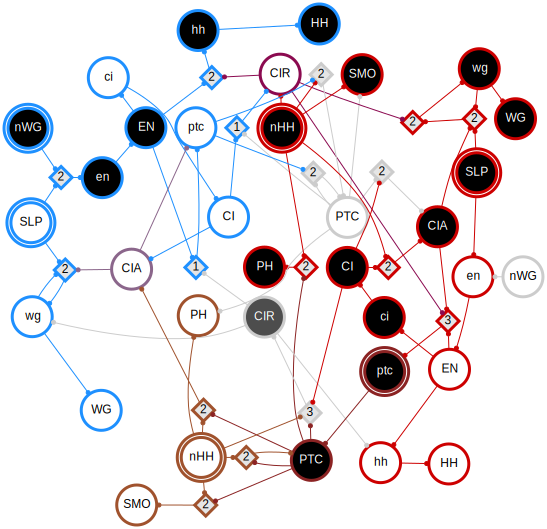

In [24]:
#alternate visualization for drosophila
DCMS = create_threshold_network(DCM)
#DCMS = N.dynamics_canalization_map(output=None)
off_node_fontcolor,off_node_fillcolor='black','white',
on_node_fontcolor,on_node_fillcolor='white','black'
node_color,t_color='grey','grey70' #'grey','#b5d1e9'
shape='circle'
inputs={'SLP-1','SLP-0','nWG-1','nWG-0','nhhnHH-1','nhhnHH-0'} #add PTC-0 for alt-red, ptc-1 for brown
inputs={'en-1','SLP-1','nWG-0','SLP-0','nWG-1','nhhnHH-1','nhhnHH-0','CIR-1','PTC-0','wg-1','CIA-1','PH-1','SMO-0','ptc-1'} #s=1 (cover)
inputs={'en-1','SLP-1','nWG-0','SLP-0','nWG-1','nhhnHH-1','nhhnHH-0','CIR-1','ptc-1'} #s=2 (cover)
inputs={'SLP-1','nWG-0','SLP-0','nWG-1','nhhnHH-1','nhhnHH-0','CIR-1','ptc-1'} #s=3 (cover)
inputs={'SLP-1','nWG-1','SLP-0','nhhnHH-1','ptc-1','nhhnHH-0'}
modules={} #s=0
#modules={'blue','pink','green','orange'} #s=1  #dark-blue, red, alt-red, brown
#modules={'blue','pink','green','orange','ptc0','cir1','wg1','ptc1','singles'} #s=1 (cover)
#modules={'dark-blue','red','brown','cir1','alt-blue'} #s=2, 'cir1' or 'ext-cir1', 'alt-red' optional
#modules={'dark-blue','red','alt-brown'} #s=3
modules={'blue','brown','red'}
faded=True #fade out the rest of the graph when doing modules
removes=['T-0_wg-0','T-0_PH-0','T-0_ptc-0','F-T1','F-T2'] #remove these nodes for a clearer representation

D = graphviz.Digraph(name='drosophila', engine='neato')
D.attr('graph', concentrate='false', simplify='false', overlap='False', splines='true', sep='+5')
D.attr('node', shape='circle', fixedsize='true', width='.55', color=node_color, style='filled', fillcolor='#515660', 
       penwidth='3', fontname='Helvetica', fontcolor='black',fontsize='12')
D.attr('edge', arrowhead='dot', arrowsize='.5', color='#545454', constraint='true')
#G.edge_attr.update(arrowhead='dot', color='gray', arrowsize='1', constraint='true')

#nodes
for node in DCMS:

    if node in att:
        natt = att[node]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        #else:
        #    fillcolor = '#515660'
        if 'label' in natt:
            label=natt['label']
        else:
            label=DCMS.node[node]['label']
    #else:
    #    xy = 'false'
    #    fillcolor = '#515660'
    
    if node in DCMS: 
        #print node,DCMS.node[node]
        #check module colors
        faded_node=False
        if 'alt-blue' in modules and node in alt_blue: node_color,t_color=colors['alt-blue'],colors['alt-blue']
        elif 'alt-brown' in modules and node in alt_brown: node_color,t_color=colors['alt-brown'],colors['alt-brown']
        elif 'dark-blue' in modules and node in extended_blue: node_color,t_color=colors['dark-blue'],colors['dark-blue']
        elif 'red' in modules and node in extended_pink: node_color,t_color=colors['red'],colors['red']
        elif 'alt-red' in modules and node in alternate_red: node_color,t_color=colors['alt-red'],colors['alt-red']
        elif 'brown' in modules and node in brown_module: node_color,t_color=colors['brown'],colors['brown']
        elif 'ext-cir1' in modules and node in extended_cir1: node_color,t_color=colors['ext-cir1'],colors['ext-cir1']
        elif 'red-cir1' in modules and node in red_cir1: node_color,t_color=colors['red-cir1'],colors['red-cir1']
        elif 'brown-pink' in modules and node in brown_pink: node_color,t_color=colors['brown-pink'],colors['brown-pink']
        elif 'brown-blue' in modules and node in brown_blue: node_color,t_color=colors['brown-blue'],colors['brown-blue']
        elif 'wg1' in modules and node in wg1_module: node_color=colors['wg1']
        elif 'ptc1' in modules and node in ptc1_module: node_color=colors['ptc1']
        elif 'singles' in modules and node in singles: node_color=colors['singles']
        elif 'blue' in modules and node in blue_module: node_color,t_color=colors['blue'],colors['blue']
        elif 'pink' in modules and node in pink_module: node_color=colors['pink']
        elif 'ptc0' in modules and node in ptc0_module: node_color,t_color=colors['ptc0'],colors['ptc0']
        elif 'green' in modules and node in green_module: node_color=colors['green']
        elif 'cir1' in modules and node in cir1_module: node_color,t_color=colors['cir1'],colors['cir1']
        elif 'orange' in modules and node in orange_module: node_color=colors['orange']
        #elif 'cir1' in modules and node in cir1_module: node_color=colors['cir1']
        elif faded: 
            node_color,t_color='grey80','grey80'
            faded_node=True
        else: node_color,t_color='grey30','grey70' #'grey'
        #MODIFICATIONS FOR PAPER
        #if node=='CIR-0': node_color='turquoise4' #both green and blue
        #if node=='nWG-0': node_color='pink3' #differentiate from SLP input, s=1
        #if node=='nWG-0': node_color='orangered3' #differentiate from SLP input, s=2, s=3
        #if node in ['ptc-0']: node_color='#b5d1e9' #destructed node for the brown module
        #if node in ['CIR-0','nhhnHH-1','SMO-1']: node_color='deeppink4' #both red and dark blue
        if node in ['CIR-0']: node_color='deeppink4' #both red and blue
        if node in ['ptc-1','PTC-1']: node_color='brown4' #both brown and red
        if node in ['CIA-0']: node_color='plum4' #both brown and blue, s=2
        #if node in ['PH-0','CIA-0']: node_color='plum4' #both brown and dark blue, s=3
        #if node in ['PH-0','CIA-0','wg-0','WG-0','T-0_ptc-0','F-T3']: node_color,t_color='plum4','plum4' #brown and dark blue, s=3
        #if node in ['nhhnHH-1','SMO-1','PTC-0','ptc-0','T-0_ptc-0','T-1_PTC-0','T-0_PTC-0','T-0_CIR-0','F-T1','F-T3']: 
        #    node_color,t_color='deeppink4','deeppink4' #both red/CIR1 and dark blue, 'CIR-0',
        #if node in ['ptc-1','PTC-1','CIR-1','wg-0','WG-0','T-0_ptc-0','F-T3'] or node in pink_module: 
        #    node_color='brown4' #both brown/pink and red/CIR1
        if 'nhhnHH' in DCMS.node[node]['label']: DCMS.node[node]['label']=DCMS.node[node]['label'].replace('nhhn','n')
        #####
        #check inputs
        if node in inputs:
            peripheries='2'
        else:
            peripheries='1'
            
    if DCMS.node[node]['type']=='variable': 
        if DCMS.node[node]['value'] == 0:
            D.node(name=node, label=DCMS.node[node]['label'], pos=xy, peripheries=peripheries,
                   fontcolor=off_node_fontcolor, fillcolor=off_node_fillcolor, color=node_color, shape=shape)
        elif DCMS.node[node]['value'] == 1:
            if faded_node:
                D.node(name=node, label=DCMS.node[node]['label'], pos=xy, peripheries=peripheries,
                   fontcolor=on_node_fontcolor, fillcolor='grey30', color=node_color, shape=shape)
            else:
                D.node(name=node, label=DCMS.node[node]['label'], pos=xy, peripheries=peripheries,
                   fontcolor=on_node_fontcolor, fillcolor=on_node_fillcolor, color=node_color, shape=shape)
    elif node in removes:
        D.node(name=node, label='', shape='diamond', style='filled,solid', 
               fillcolor='white', fontcolor='white', color='white', width='0', height='0', pos=xy)
    elif DCMS.node[node]['type'] == 'threshold' and node[0]=='T': #traditional threshold node
        D.node(name=node, label=label, shape='diamond', style='filled,solid', 
               fillcolor='grey90', fontcolor='black', color=t_color, width='.3', height='.3', pos=xy) #fillcolor='#dae8f4'
    elif DCMS.node[node]['type'] == 'threshold' and node[0]=='F': #combined threshold node from fusion node
        print node,DCMS.node[node]
        D.node(name=node, label=DCMS.node[node]['label'], shape='diamond', style='filled,solid', #shape='circle'
               fillcolor='grey90', fontcolor='black', color=t_color, width='.3', height='.3', pos=xy) #fillcolor='#dae8f4'
    elif DCMS.node[node]['type'] == 'fusion': #doesn't happen in threshold network
        D.node(name=node, label='', shape='circle', width='.4', height='.4', margin='0')
    #elif DCMS.node[node].get('label'):
    #    D.node(name=str(node), label=DCMS.node[node]['label'], pos=xy) #fillcolor=fillcolor

#edges
max_penwidth = 2.5
edges=[(s,t) for s,t,d in DCMS.edges(data=True)] #source, destination, weight
#add additional edges for a clearer representation
for s,t in [('F-T0','wg-0'),('nhhnHH-0','PH-0'),('PTC-0','PH-0'),('F-T3','ptc-0'),('PTC-0','T-0_CIR-0'),
            ('CI-0','T-0_CIR-0'),]: #('F-T2','PH-0'),('nhhnHH-1','T-0_CIR-0')
    edges.append((s,t))
for s,t in edges:
    if s==t: continue #include this line to get rid of self-loops
    #weight = '%d' % (d['weight']*100)
    #penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    #modifications to get rid of fusion edges
    if s in removes or t in removes: continue
    #check module colors
    if 'alt-blue' in modules and s in alt_blue: #and t in alt_blue: 
        edge_color=colors['alt-blue']
    elif 'alt-brown' in modules and s in alt_brown: #and t in alt_brown: 
        edge_color=colors['alt-brown']
    elif 'dark-blue' in modules and s in extended_blue: #and t in extended_blue:
        edge_color=colors['dark-blue']
    elif 'red' in modules and s in extended_pink: #and t in extended_pink:
        edge_color=colors['red']
    elif 'alt-red' in modules and s in alternate_red: #and t in alternate_red:
        edge_color=colors['alt-red']
    elif 'brown' in modules and s in brown_module: #and t in brown_module:
        edge_color=colors['brown']
    elif 'ext-cir1' in modules and s in extended_cir1: #and t in extended_cir1
        edge_color=colors['ext-cir1']
    elif 'red-cir1' in modules and s in red_cir1: #and t in red_cir1
        edge_color=colors['red-cir1']
    elif 'brown-pink' in modules and s in brown_pink: #and t in brown-pink
        edge_color=colors['brown-pink']
    elif 'brown-blue' in modules and s in brown_blue: #and t in brown-blue
        edge_color=colors['brown-blue']
    elif 'wg1' in modules and s in wg1_module: #and t in wg1_module: 
        edge_color=colors['wg1']
    elif 'ptc1' in modules and s in ptc1_module: #and t in ptc1_module: 
        edge_color=colors['ptc1']
    elif 'singles' in modules and s in singles: #and t in singles: 
        edge_color=colors['singles']
    elif 'blue' in modules and s in blue_module: #and t in blue_module: 
        edge_color=colors['blue']
    elif 'pink' in modules and s in pink_module: #and t in pink_module:
        edge_color=colors['pink']
    elif 'ptc0' in modules and s in ptc0_module: #and t in ptc0_module:
        edge_color=colors['ptc0']
    elif 'green' in modules and s in green_module: #and t in green_module:
        edge_color=colors['green']
    elif 'cir1' in modules and s in cir1_module: #and t in cir1_module:
        edge_color=colors['cir1']
    elif 'orange' in modules and s in orange_module: #and t in orange_module:
        edge_color=colors['orange']
    elif faded:
        edge_color='grey80'
    else:
        edge_color='grey'
        
    #MODIFICATIONS FOR PAPER
    #if s=='T-0_wg-0' or s=='F-T0': #s=1
    #    edge_color='grey'
    #if s=='CIR-0': #s=1
    #    edge_color='turquoise4'
    #if s=='nWG-0': 
    #    edge_color='pink3' #s=1
    #    edge_color='orangered3' #s=2, s=3
    #if s=='ptc-0': #s=2, destructed node in brown module
    #    edge_color='#b5d1e9'
    if s=='CIR-0':# or s=='nhhnHH-1' or s=='SMO-1': #s=2
        edge_color='deeppink4' 
    if s=='ptc-1' or s=='PTC-1': #s=2
        edge_color='brown4'
    if s=='CIA-0' or s=='PH-0': #s=2
        edge_color='plum4'
    #if s in ['PH-0','CIA-0','wg-0','WG-0','T-0_ptc-0','F-T3']: #s=3
    #    edge_color='plum4'
    #if s in ['nhhnHH-1','SMO-1','PTC-0','ptc-0','T-0_ptc-0','T-1_PTC-0','T-0_PTC-0','T-0_CIR-0','F-T3']: #s=3, 'CIR-0',
    #    edge_color='deeppink4'
    #if s in ['ptc-1','PTC-1','CIR-1','wg-0','WG-0','T-0_ptc-0','F-T3'] or s in pink_module: #s=3
    #    edge_color='brown4'
      
    '''
    if DCMS[s][t].get('type'):
        D.edge(str(s),str(t),color=edge_color )
    
    else: #edges with 'fusion' nodes
        D.edge(str(s),str(t),color=edge_color )
        
        if DCMS.node[s]['type']=='threshold' and DCMS.node[t]['type']=='threshold': #line between threshold nodes
            D.edge(str(s),str(t),color=edge_color )
        elif faded:
            D.edge(str(s),str(t),color='palegreen' ) #'palegreen'
        else:
            D.edge(str(s),str(t),color='seagreen' ) #'seagreen' '''
    D.edge(str(s),str(t),color=edge_color ) #add edge
    
display(D)

# Export to .SVG
D._format = 'pdf'
#efile = u'%s/../experiments/2017 - BioModels/%s/DCM/drosophila_DCM_blue-red-brown' % (os.getcwd(), foldername)
#D.render(efile, cleanup=True)
#subprocess.call("inkscape -z -d 150 '%s.svg' -e '%s.png'" % (efile,efile) , shell=True)
#plt.savefig('../../Dynamics/drosophila_DCM_blue-red-brown.pdf',dpi=300,bbox_inches = "tight")

(0.0, 1.0, 0.0, 1.0)

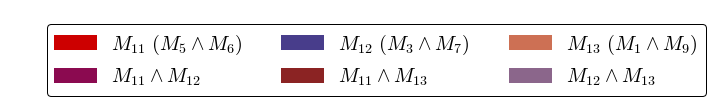

In [62]:
#create a legend for the above DCM plots (s=3)
#use hex codes for numbered variations
from matplotlib.lines import Line2D

figure, ax = plt.subplots(figsize=(10,1))
dark_blue_line = Line2D([], [], color='darkslateblue', markersize=100, linewidth=15)
red_line = Line2D([], [], color='#CD0000', markersize=100, linewidth=15)
salmon_line = Line2D([], [], color='#CD7054', markersize=100, linewidth=15)
deeppink_line = Line2D([], [], color='#8B0A50', markersize=100, linewidth=15)
plum_line = Line2D([], [], color='#8B668B', markersize=100, linewidth=15)
dark_brown_line = Line2D([], [], color='#8B2323', markersize=100, linewidth=15)
legend=plt.legend([red_line,deeppink_line,dark_blue_line,dark_brown_line,salmon_line,plum_line],
                  [#r'$M_{nWG-1 \wedge SLP-0 \wedge nHH-1} = M_1$',
                   r'$M_{11} \ (M_5 \wedge M_6)$',
                   r'$M_{11} \wedge M_{12}$',
                   #r'$M_{(SLP-1 \vee nWG-0) \wedge nHH-1 \wedge CIR-1} = M_2$',
                   r'$M_{12} \ (M_3 \wedge M_7)$',                   
                   r'$M_{11} \wedge M_{13}$',
                   #r'$M_{(SLP-1 \vee nWG-0) \wedge nHH-0 \wedge ptc-1} = M_3$',
                   r'$M_{13} \ (M_1 \wedge M_9)$',
                   r'$M_{12} \wedge M_{13}$',
                   #r'$M_{nWG-1 \wedge SLP-0 \wedge nHH-1} \wedge M_{(SLP-1 \vee nWG-0) \wedge nHH-0 \wedge ptc-1}$',
                   #r'$M_{nWG-1 \wedge SLP-0 \wedge nHH-1} \wedge M_{(SLP-1 \vee nWG-0) \wedge nHH-1 \wedge CIR-1}$',
                   #r'$M_{(SLP-1 \vee nWG-0) \wedge nHH-0 \wedge ptc-1} \wedge M_{(SLP-1 \vee nWG-0) \wedge nHH-1 \wedge CIR-1}$'
                  ],
           loc='upper left', prop={'size': 20}, #bbox_to_anchor=(0.0, 1.0),
          fancybox=True, shadow=False, ncol=3, fontsize=36) #bbox_to_anchor=(1, 0.5)

ax.axis('off')
#ax.set_xticks([])
#ax.set_yticks([])
#plt.savefig('../../Dynamics/drosophila_DCM_s3_legend.pdf',dpi=300,bbox_inches = "tight")

(0.0, 1.0, 0.0, 1.0)

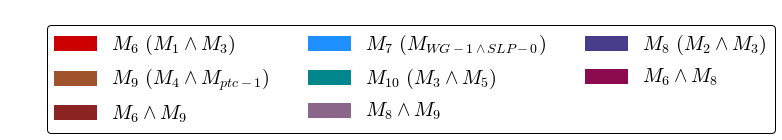

In [63]:
#create a legend for the above DCM plots (s=2)
#use hex codes for numbered variations
from matplotlib.lines import Line2D

figure, ax = plt.subplots(figsize=(10,1))
red_line = Line2D([], [], color='#CD0000', markersize=100, linewidth=15)
brown_line = Line2D([], [], color='#A0522D', markersize=100, linewidth=15)
dark_brown_line = Line2D([], [], color='#8B2323', markersize=100, linewidth=15)
blue_line = Line2D([], [], color='dodgerblue', markersize=100, linewidth=15)
turq_line = Line2D([], [], color='#00868B', markersize=100, linewidth=15)
plum_line = Line2D([], [], color='#8B668B', markersize=100, linewidth=15)
dark_blue_line = Line2D([], [], color='darkslateblue', markersize=100, linewidth=15)
deeppink_line = Line2D([], [], color='#8B0A50', markersize=100, linewidth=15)
legend=plt.legend([red_line,brown_line,dark_brown_line,blue_line,turq_line,plum_line,dark_blue_line,deeppink_line],
                  [r'$M_6 \ (M_1 \wedge M_3)$',
                   r'$M_9 \ (M_4 \wedge M_{ptc-1})$',
                   r'$M_6 \wedge M_9$',
                   r'$M_7 \ (M_{WG-1 \wedge SLP-0})$',
                   r'$M_{10} \ (M_3 \wedge M_5)$',
                   r'$M_8 \wedge M_9$',
                   r'$M_8 \ (M_2 \wedge M_3)$',
                   r'$M_6 \wedge M_8$',
                  ],
                  loc='upper left', prop={'size': 20}, #bbox_to_anchor=(0.0, 1.0),
                  fancybox=True, shadow=False, ncol=3, fontsize=36) #bbox_to_anchor=(1, 0.5)

ax.axis('off')
#plt.savefig('../../Dynamics/drosophila_DCM_s2_legend.pdf',dpi=300,bbox_inches = "tight")

(0.0, 1.0, 0.0, 1.0)

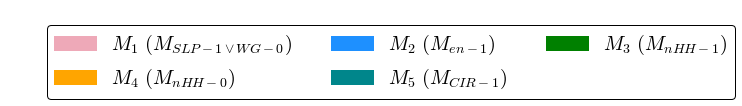

In [544]:
#create a legend for the above DCM plots (s=1)
#use hex codes for numbered variations
from matplotlib.lines import Line2D

figure, ax = plt.subplots(figsize=(10,1))
pink_line = Line2D([], [], color='#EEA9B8', markersize=100, linewidth=15)
orange_line = Line2D([], [], color='#FFA500', markersize=100, linewidth=15)
blue_line = Line2D([], [], color='dodgerblue', markersize=100, linewidth=15)
turq_line = Line2D([], [], color='#00868B', markersize=100, linewidth=15)
green_line = Line2D([], [], color='green', markersize=100, linewidth=15)
legend=plt.legend([pink_line,orange_line,blue_line,turq_line,green_line],
                  [r'$M_1 \ (M_{SLP-1 \vee WG-0})$',
                   r'$M_4 \ (M_{nHH-0})$',
                   r'$M_2 \ (M_{en-1})$',
                   r'$M_5 \ (M_{CIR-1})$',
                   r'$M_3 \ (M_{nHH-1})$',
                  ],
                  loc='upper left', prop={'size': 20}, #bbox_to_anchor=(0.0, 1.0),
                  fancybox=True, shadow=False, ncol=3, fontsize=36) #bbox_to_anchor=(1, 0.5)

ax.axis('off')
#plt.savefig('../../Dynamics/drosophila_DCM_s1_legend.pdf',dpi=300,bbox_inches = "tight")

['hh-1', 'HH-0', 'HH-1', 'T-1_HH-1', 'T-0_HH-0', 'hh-0']
F-0_T-0_wg-0 {'group': 'wg', 'type': 'fusion'}
F-0_T-0_PH-0 {'group': 'PH', 'type': 'fusion'}
F-1_T-2_wg-1 {'group': 'wg', 'type': 'fusion'}
F-0_T-2_wg-1 {'group': 'wg', 'type': 'fusion'}
F-1_T-0_wg-0 {'group': 'wg', 'type': 'fusion'}
F-0_T-0_ptc-1 {'group': 'ptc', 'type': 'fusion'}
F-0_T-0_CIR-0 {'group': 'CIR', 'type': 'fusion'}
CM: HH


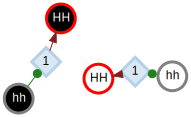

In [35]:
import networkx as nx
#F->T edge 'fused', T->V 'out', V->T 'literal', V->F 'fusing'
edge_types=['threshold','fusing','fused','literal','out']
node_types=['fusion','threshold','variable']
#print (DCM.nodes())
#for t in node_types:
#    print len([DCM.node[name] for name in DCM.nodes() if DCM.node[name]['type']==t])
#print len(DCM.edges())
CMs = []
for node in N.nodes:
    CMs.append( node.canalizing_map() )
#print node.canalizing_map().nodes()
#DCM = nx.compose_all(CMs)
print CMs[6].nodes()
for name in CMs[6].edges():
    if CMs[6][name[0]][name[1]]['type']=='fusing':
        print name,CMs[6][name[0]][name[1]]
    #print name,CMs[1].node[name]
    pass
for edge in DCM.edges():
    continue
    #if 'wg-0' in edge: print edge,DCM[edge[0]][edge[1]]
    if 'F-0_T-0_wg-0' in edge or 'F-1_T-0_wg-0' in edge: 
        print edge,DCM[edge[0]][edge[1]]
#print DCM.neighbors('wg-1')
#print DCM.node['F-0_T-2_wg-1']
for name in DCM.nodes():
    if DCM.node[name]['type']=='fusion':
        print name,DCM.node[name]
for n in [6]: #1,7,9,14]:
    CM=N.nodes[n].canalizing_map()
    gv=draw_canalizing_map_graphviz(CM)
    print CM
    display(SVG(gv.pipe(format='svg')),metadata={'isolated':True})
#print DCM.node['F-1_T-2_wg-1']['type']

In [14]:
import random
#threshold network conversion
def create_threshold_network(n):
    """ Create a digraph compatible with threshold network manipulation
    Expects a DCM-like digraph as input, returns a threshold-like digraph where every node is a literal and/or threshold node
    
    Valid nodes include these properties: label, threshold (tau), type, time delay, variable, state
    Valid edges include these properties: type 
    
    NOTE: the DCM originally has a separate fusion node for each literal enput of the same state involved in the same symmetry group
    However, this means that the same enput can activate multiple edges rather than just one
    As a solution, each group of fusion nodes that are associated with the same state and the same symmetry group are replaced
    by one threshold node with tau=n, where n is the number of fusion nodes that were combined into that threshold node """
    
    n=n.copy() #don't change the original graph
    
    #check for similar fusion nodes
    fusion_nodes=[name for name in n.nodes() if n.node[name]['type']=='fusion']
    groups={} #each group will share the same predecessors and successors
    i=0
    for f in fusion_nodes:
        predecessors=set(n.predecessors(f))
        successors=set(n[f])
        found=False
        for key in groups:
            if groups[key]['predecessors']==predecessors and groups[key]['successors']==successors: #we have a match
                groups[key]['nodes'].append(f)
                found=True
                break
        if not found: #make a new group
            groups[i]={'predecessors':predecessors, 'successors':successors, 'nodes':[f]}
            i+=1
    #delete fusion nodes and replace with new threshold nodes
    for t in groups: #add new threshold nodes
        name="F-T"+str(t)
        tau=len(groups[t]['nodes'])
        group=n.node[random.choice(tuple(groups[t]['successors']))]['group'] #take group attribute of random successor, necessary for visualization
        n.add_node(name,{'label':str(tau),'type':'threshold','tau':tau,'group':group})
        #adjust successor node thresholds; add 1 for new threshold node and then substract for each fusion node deleted
        for successor in groups[t]['successors']: #there should only be one
            n.add_edge(name,successor)
            n.node[successor]['tau'] += 1 - tau
            n.node[successor]['label'] = str(n.node[successor]['tau'])
        #add new edges to threshold nodes from predecessors
        for predecessor in groups[t]['predecessors']:
            n.add_edge(predecessor,name)
        
    #delete fusion nodes and adjacent edges
    for f in fusion_nodes:
        n.remove_node(f)
    #print groups
    
    for name in n.nodes():
        
        if 'label' not in n.node[name]:
            n.node[name]['label']='unknown'
            
        if 'type' not in n.node[name]:
            n.node[name]['type']='unknown'
            
        if 'tau' not in n.node[name]:
            if n.node[name]['type']=='threshold':
                n.node[name]['tau']=1
            else:
                n.node[name]['tau']=0
                
        if 'delay' not in n.node[name]:
            if n.node[name]['type']=='threshold':
                n.node[name]['delay']=0
            else:
                n.node[name]['delay']=1
        
        #assume variable name comes from the label
        if 'variable' not in n.node[name] and n.node[name]['type']=='variable':
            n.node[name]['variable']=n.node[name]['label']
            
        #assume states are only positive integers
        if 'state' not in n.node[name] and n.node[name]['type']=='variable':
            state_str=name.replace(n.node[name]['variable'],"") #remove variable name
            state_str=''.join([s for s in state_str if s.isdigit()]) #concatenate string from all integers left in name (in case of double-digit states)
            n.node[name]['state']=int(state_str)
                
        #print name,n.node[name]
        
    return n

#create_threshold_network(DCM)

In [15]:
from collections import deque
#specialized BFS to work for threshold network
def BFS_threshold(n,seed,input_type='steady',time_limit=1,conversion=True):
    
    """ Does specialized BFS on a threshold network n
    input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
    or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    seed may be a single node or a list of starting nodes
    
    Implementation based on BFS with a priority queue of times {t: q} 
    where t is the time when those nodes become active and q are the nodes active at that time step 
    
    Returns a dictionary of nodes visited at each time step
    
    NOTE: a threshold network is required, this will break if fusion nodes have not been removed
    Assume that a conversion is needed; will not run conversion if conversion argument set to False 
    
    NOTE: if run with input_type='steady', unfolding contains only the new states visited at that time step
    while all previous states visited are also considered active
    if run with input_type='pulse', unfolding contains EVERY node that is active at that time step, 
    even if it has been active before 
    
    NOTE: if run with input_type='steady', then ignore any node that is a different state of the starting seed;
    because we are pinning control of that variable, we need to remove all other possible variable states from the network """
    
    if conversion: #note conversion is slow due to a network deep copy
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation")
        
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]
    
    for node in seed:
        if node not in n.nodes():
            raise Exception('Seed not in the network!  Hint: did you specify both the node and current state? e.g. wg-1')
            
    #if there is steady-state input (pinning control), note any contradictions to any node in the seed
    #NOTE: if given a logical contradiction, this function picks only ONE of the states to use
    #however, this doesn't affect steady-state (because the variable was already added to the queue and active step)
    if input_type=='steady':
        vals={n.node[x]['variable']:n.node[x]['state'] for x in seed if n.node[x]['type']=='variable'}
        contradictory_nodes={node for node in n if 
                        n.node[node]['type']=='variable' and n.node[node]['variable'] in vals and n.node[node]['state']!=vals[n.node[node]['variable']]}
    else:
        contradictory_nodes={}
        
    counter=0  #this will increment towards the time limit and provide an exit if we get stuck
    visited=set() #visited nodes during the entire history
    thresholds={} #global threshold dictionary to populate with discounted threshold nodes
        
    #create 'priority queue', actually a dictionary of time steps due to difficulty in changing priorities in a heap
    time_steps={0: deque(seed)} #FIFO queue for each time step of nodes to attempt to visit
    time=0 #global chronometer, iterates by one as dynamic unfolding takes place
    unfolding={} #track the unfolding of the dynamics over iterated time, mirrors time_steps but only holds visited nodes    
    active_step=set(seed) #active nodes for this time step, will be different than visited if input_type='pulse'
    
    
    while time<=max(time_steps): #allows for possibility of time jumps, i.e. updates further ahead than one time step
        
        #update counter
        old_length=len(visited)
        visited.update(active_step)
        if len(visited)==old_length: #increase counter if we have not added anything new
            counter+=1
        #print time,len(visited)
        #reset thresholds and active_step if this is pulse (so that we may revisit nodes, including the starting nodes)
        #print time,active_step
        if input_type=='pulse':
            thresholds={}
            active_step=set()
        
        #check for exit due to being stuck in a cycle
        if counter>=time_limit: 
            break

        #run BFS
        while time_steps.get(time): 
            node=time_steps[time].popleft()
            #add node to unfolding
            unfolding.setdefault(time,set())
            unfolding[time].add(node)
            
            #check neighbors - note that for steady state we assume all past actors are still activated, but pulse requires repeat activation
            for neighbor in n[node]:
                #ignore any contradictory nodes; better to ignore than remove because we don't want BFS to be destructive to the graph
                if neighbor in contradictory_nodes:
                    continue
                if neighbor not in active_step:
                    #check that neighbor passes the threshold test if it has a non-trivial threshold
                    if n.node[neighbor]['tau']>1:
                        thresholds.setdefault(neighbor,set())
                        thresholds[neighbor].add(node)  #add node due to this incoming edge, ensures node can only contribute once
                    if neighbor not in thresholds or len(thresholds[neighbor])>=n.node[neighbor]['tau']:
                        #at this point we have passed the threshold, so insert neighbor at proper time slot t
                        t = time + n.node[neighbor]['delay']
                        time_steps.setdefault(t,deque())
                        time_steps[t].append(neighbor)
                        active_step.add(neighbor)
                           
        #next iteration
        time+=1
    
    return unfolding

#print BFS_threshold(DCM,['nWG-1','SLP-0'],'steady',time_limit=1) #'SLP-1','CIR-0','CIA-1','SLP-0','nWG-1','en-1'
#print BFS_threshold(DM,['Six-1','Four-0','Two-0','Three-1'],'steady')

In [1373]:
# Request the DCM to the Network
DCM = N.dynamics_canalization_map(output=None) #simplify=True
# Draws using the graphviz interface.
#D2 = draw_dynamics_canalization_map_graphviz(DM, overlap='true')
#display(D2)

       In:  Out:
0  #̊0̊0̊#     0
1     ###1     0
2  #̊1̊1̊0     1
0 [('2002', [[0, 1, 2]], [[1, 2]]), ('2221', [], [[0, 1, 2]])]
1 [('2110', [[0, 1, 2]], [[1, 2]])]
CM: wg


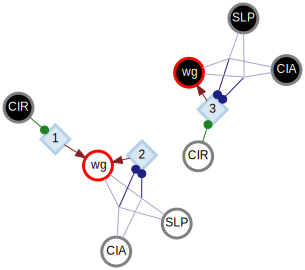

In [480]:
CM=N.nodes[1].canalizing_map()
print N.nodes[1].schemata_look_up_table(type="ts")
for out, tspsss in zip( [0,1] , N.nodes[1]._two_symbols ): print out,tspsss
gv=draw_canalizing_map_graphviz(CM)
print CM
display(SVG(gv.pipe(format='svg')),metadata={'isolated':True})

In [38]:
#drosophila color modules
#print BFS_threshold(DCM,['nWG-1','SLP-0','nhhnHH-1'],input_type='steady') #blue, purple
#print BFS_threshold(DCM,['nWG-0','SLP-1','nhhnHH-1'],input_type='steady') #pink, red
#print BFS_threshold(DCM,['nhhnHH-0','ptc-1'],input_type='steady') #green, gold, brown
#print BFS_threshold(DCM,['nWG-0','SLP-1','PTC-0'],input_type='steady') #orange
#print BFS_threshold(DCM,['CIR-1'],input_type='steady') #grey?
#print BFS_threshold(DCM,['PTC-0'],input_type='steady') #grey?
#print BFS_threshold(DCM,['SLP-1','nhhnHH-1','CIR-1'],input_type='steady')
#print BFS_threshold(DCM,['nWG-0','nhhnHH-0','ptc-1'],input_type='steady')
print BFS_threshold(DCM,['SLP-0','nhhnHH-0','ptc-1'],input_type='steady')

{0: set(['T-0_PH-0', 'nhhnHH-0', 'ptc-1', 'SLP-0', 'F-T2']), 1: set(['T-0_CIA-0', 'PH-0', 'PTC-1', 'T-3_PTC-1', 'T-0_SMO-0']), 2: set(['SMO-0', 'F-T0', 'T-0_wg-0', 'CIA-0']), 3: set(['wg-0']), 4: set(['WG-0'])}


In [25]:
#function to find top modules given a set of modules
def find_top_modules(nu,tm,sizes,candidates,input_type='steady'):
    """ Determines the top modules by seeing which modules can be subsumed into other modules
    Specifically, it tests every candidate to see if it is along the path of a larger module in nu, O(n**2) time 
    Candidates is a dictionary where the keys are node names and the values are actual nodes to check """
    
    nodes_seen=[] #track which nodes the candidate might be found in
    for node in sorted(sizes,key=lambda x:sizes[x],reverse=True): #start with the largest modules

        if node in candidates: #only check our candidates
            
            seen=False
            for step in nodes_seen: #compare against all dynamic steps we've seen before 
                
                if not candidates[node]-step: #the candidate is a subset of the nodes seen
                    #print node,"eaten by",step
                    seen=True
                    break
            
            if not seen:
                #add to top_modules
                tm[node]=nu[node]
                #add the node's unfolding to nodes_seen
                if input_type=='steady':
                    nodes_seen.append({x for t in nu[node] for x in nu[node][t]})
                else: #add a separate set for each time step
                    for t in nu[node]:
                        nodes_seen.append({x for x in nu[node][t]})
                        
            
    return tm

#n,t,s,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True)
#print len(t),len(n)
#for node in sorted(s,key=lambda x: s[x],reverse=True):
#    if node in t: pass #print node,s[node]#,t[node]

In [55]:
#function to find all dynamic modules of single seed perturbations
def find_dynamic_modules(n,num=1,input_type='steady',time_limit=1,conversion=True,samples=None,tm=True,seeds=None):
    
    """ Test all possible seeds of a network to determine each seed's dynamic unfolding
    If tm=True, combines any unfolding that is a subset of another unfolding and returns the largest unique unfoldings 
    
    input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
    or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    
    num dictates how many nodes the seed should contain; the default is to only search dynamic modules from one starting node
    NOTE: this function does a combinatoric search over all possible seed configurations, be careful with memory constraints
    when running with high n
    If samples=x, then this will draw x samples from the possible combinations with replacement
    If tm=True, this will try to compute all top modules
    If seeds is not None, this will find all dynamic modules from the seeds contained in that iterable (must be hashable);
    Note that seeds takes precedence over samples
    
    Converts the network n to a thresholded representation """
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    network_unfolding,sizes={},{}
    #remove all non-variable nodes for cleaner visibility and comparison
    nodes=[x for x in n if n.node[x]['type']=='variable']

    if not seeds:
        if samples: #sampling to avoid memory issues with high combinations
            seeds=[[random.choice(nodes) for j in range(num)] for i in range(samples)]
        else: #get all combinations
            seeds=combinations(nodes,num)
    #elif num>1:
    #    #find combinations of our starting seeds; may need to be explicitly passed 
    #    seeds=combinations(seeds,num)
    candidates={} #used for top modules later
    #print seeds

    for seed in seeds:
        seed=list(seed)
        #quick check for contradiction
        vals=[n.node[x]['variable'] for x in seed]
        if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
            continue
        
        unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)        
        unfolding={t:{x for x in unfolding[t] if n.node[x]['type']=='variable'} for t in unfolding} #simplify
        #if num==1: 
        #    seed=seed[0] #special case for single nodes, allows us to find top modules
        network_unfolding[str(seed)]=unfolding
        sizes[str(seed)]=sum([len(unfolding[t]) for t in unfolding])
        #update candidates
        candidates[str(seed)]=set(seed)
        #if tm: candidates[str(seed)]=set(seed)
 
    #condense down to the top modules by finding which modules are subsets of other modules (only consider variables)
    #NOTE: if a node is turned on at any point, it is guaranteed to follow the trajectory specified by its own module
    #a node along the path of another module can therefore have its trajectory be subsumed into that module
    top_modules={}
    if tm:
        top_modules=find_top_modules(network_unfolding,top_modules,sizes,candidates,input_type=input_type)
    
    
        
    return network_unfolding,top_modules,sizes,candidates

#nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True,seeds=[['CIA-0'],['en-1','SMO-1'],['en-1']])
#nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True,seeds=None)
#print tm

In [27]:
#independence test of two modules 
def run_independence_test(n,seeds,input_type='steady',time_limit=1,conversion=True):
    """ Indicates whether the unfoldings of the given seeds are dynamically independent 
    This depends on synergy within the unfoldings; if A and B are independent seed nodes, then the unfolding U(A,B)=U(A)+U(B), 
    whereas U(A,B)>U(A)+U(B) or U(A,B)<U(A)+U(B) indicates synergy and either interference or subsumption, respectively
    
    Returns -1 if the modules are destructive/subsumptive, 0 if independent, and +1 if they are synergistic """
    
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    #ensure all seeds are proper lists
    if not seeds:
        return 0
    joint_seed=set([])
    for s in seeds:
        joint_seed=joint_seed.union(set(s))
    joint_seed=[s for s in joint_seed]
    #print joint_seed
    
    #test joint length
    unfolding=BFS_threshold(n,joint_seed,input_type=input_type,time_limit=time_limit,conversion=False)
    joint_set={x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'}
    joint_length=len(joint_set)
            
    #test sum of individual lengths
    ind_set,ind_length=set([]),0
    for seed in seeds:
        seed=[s for s in seed]
        unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
        ind_set=ind_set.union({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
        ind_length+=len({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
    #print seeds,joint_length,ind_length #,joint_set,ind_set
    
    #test for independence
    if joint_length<ind_length: #these are destructive or subsumptive
        return -1
    elif joint_length>ind_length: #these are synergistic
        return 1
    #check there isn't a case with both destruction and synergy where the effects of both cancel out numerically
    #in other words, independence implies joint sets of the same size (every node counted exactly once) that contain the same exact set of nodes
    elif joint_set.intersection(ind_set)==joint_set.union(ind_set): #independence
        return 0 
    else: #opposing destruction and synergy, not sure what to do here
        #print "destruction and synergy:",seeds,joint_set
        return -2

In [ ]:
#TODO: synergistic module test function
#save memory if all submodules have already been stored, uses powerset logic and s-unit mapping

In [39]:
#FUNCTIONS FROM INFO DIFFUSION

#NT=create_threshold_network(DCM)
print DCM.nodes()
#TODO: write a generic read-in function to create any discrete network (no Boolean requirements)

['HH-1', 'HH-0', 'CIR-0', 'CIR-1', 'F-0_T-0_wg-0', 'T-2_en-1', 'wg-1', 'wg-0', 'F-0_T-0_PH-0', 'SMO-1', 'SMO-0', 'T-0_PH-0', 'CIA-1', 'CIA-0', 'T-1_PH-1', 'T-1_PTC-0', 'hh-1', 'hh-0', 'ci-1', 'ci-0', 'WG-1', 'WG-0', 'T-2_ptc-1', 'T-2_wg-1', 'T-0_SMO-0', 'CI-1', 'CI-0', 'SLP-1', 'SLP-0', 'T-2_CIA-1', 'T-3_PTC-1', 'F-1_T-2_wg-1', 'F-0_T-2_wg-1', 'ptc-1', 'ptc-0', 'PH-1', 'PH-0', 'en-0', 'en-1', 'PTC-1', 'PTC-0', 'F-1_T-0_wg-0', 'EN-0', 'EN-1', 'F-0_T-0_ptc-1', 'T-3_CIA-1', 'T-0_CIR-0', 'T-2_hh-1', 'T-2_CIR-1', 'nhhnHH-1', 'nhhnHH-0', 'T-0_ptc-0', 'nWG-0', 'nWG-1', 'T-0_CIA-0', 'T-0_wg-0', 'T-0_PTC-0', 'F-0_T-0_CIR-0']


In [75]:
#define s-units and modules; map any node set to numbers starting with 0
#NOTE: this function only works with fully Boolean graphs
def get_sunits(N):
    sunits,sunit_map=set([]),{}
    num=0
    for node in N.nodes:
        for state in ['0','1']:
            sunits.add(num)
            sunit_map[num]=node.name+'-'+state
            num+=1
        
    return sunits,sunit_map

sunits,sunit_map=get_sunits(N)
print sunit_map

{0: 'SLP-0', 1: 'SLP-1', 2: 'wg-0', 3: 'wg-1', 4: 'WG-0', 5: 'WG-1', 6: 'en-0', 7: 'en-1', 8: 'EN-0', 9: 'EN-1', 10: 'hh-0', 11: 'hh-1', 12: 'HH-0', 13: 'HH-1', 14: 'ptc-0', 15: 'ptc-1', 16: 'PTC-0', 17: 'PTC-1', 18: 'PH-0', 19: 'PH-1', 20: 'SMO-0', 21: 'SMO-1', 22: 'ci-0', 23: 'ci-1', 24: 'CI-0', 25: 'CI-1', 26: 'CIA-0', 27: 'CIA-1', 28: 'CIR-0', 29: 'CIR-1', 30: 'nhhnHH-0', 31: 'nhhnHH-1', 32: 'nWG-0', 33: 'nWG-1'}


In [221]:
#retrieve variables from a list of sunits
import re
def get_variables(sunits):
    
    #print sunits
    variables=set([])
    for sunit in sunits:
        match=re.search('-{1}[0-9]+$',sunit) #match based on -x where x is the state of the variable
        variables.add(sunit.replace(match.group(0),'')) #remove -x
        
    return variables

sunit_set={sunit_map[sunit] for sunit in sunit_map}
print get_variables(sunit_set)

set(['WG', 'wg', 'CIA', 'EN', 'SLP', 'ci', 'PTC', 'CI', 'ptc', 'en', 'SMO', 'CIR', 'HH', 'nWG', 'nhhnHH', 'PH', 'hh'])


In [556]:
seeds=list(combinations(sunits,2)) #[['en-1']] or list(combinations(sunits,s)) for example
print len(seeds)
#for seed in seeds:
modules={str(seed): set([]) for seed in seeds}
translator={str(seed): seed for seed in seeds}
#print modules
#print translator

561


In [53]:
#list method that ensures that s-unit combinations are in the correct order
#order is based on node number and state, starting with 0
def to_list(seed,smap,translator=None):
    """ determine the sunits involved in the seed, based on the sunit_map 
    this make take either a tuple of s-units, or a string of s-units (requires the translator argument)
    the smap maps individual node numbers to names, the translator maps seed strings to node numbers """
    
    ls = []
    if isinstance(seed,str):
        seed = translator[seed]
        
    for node in seed:
        ls.append(smap[node])
    return ls

seed=(33,)
print seed,to_list(seed,sunit_map) #seed is a tuple
print str(seed),to_list(str(seed),sunit_map,translator)

(33,) ['nWG-1']
(33,) ['nWG-1']


In [111]:
#returns a valid seed in numbered order from a list of sunits
#this does a reverse lookup the sunit dictionary and is consquently slower
def name_to_index(seed,smap):
    """ returns an indexed seed based on the sunit names """
    
    reverse_map={smap[k]:k for k in smap}
    #print reverse_map  
    units=sorted([reverse_map[s] for s in seed])
    
    return tuple(units)

def names_to_index(seeds,smap):
    """ returns a list of indexed seeds based on the sunit names """
    
    return [name_to_index(seed,smap) for seed in seeds]
        
units=names_to_index([['en-1'],['WG-0'],['en-1','WG-0']],sunit_map)
for seed in units: print seed,to_list(seed,sunit_map)

(7,) ['en-1']
(4,) ['WG-0']
(4, 7) ['WG-0', 'en-1']


In [50]:
#solution from https://stackoverflow.com/questions/374626/how-can-i-find-all-the-subsets-of-a-set-with-exactly-n-elements
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))

#NOTE: there is symmetry with powersets (a set and its complement); therefore, we only need to check half of the powerset
#the sum (the set) must be greater (synergistic) than the addition of its parts (addition of all subsets)
ps=list(powerset(set([1,2,3,4])))
for i in range(1,int(len(ps)/2)): print i,ps[i],ps[len(ps)-i-1]

1 (1,) (2, 3, 4)
2 (2,) (1, 3, 4)
3 (3,) (1, 2, 4)
4 (4,) (1, 2, 3)
5 (1, 2) (3, 4)
6 (1, 3) (2, 4)
7 (1, 4) (2, 3)


In [187]:
#function to reduce a pathway module to a pathway set of sunits
#NOTE: DCM gets converted to the thresholded representation
def module_reduce(modules,n):
    
    module_set={}
    for seed in modules:
        unfolding=modules[seed]
        #print unfolding
        module_set[seed]=[x for t in unfolding for x in unfolding[t] if x in n and n.node[x]['type']=='variable']
        
    return module_set
   
#module_reduce(modules,DCM) #works with a DCM or a thresholded graph, to see the seed: to_list(module,sunit_map,translator)

In [368]:
#string method to sort a set of modules and display them by seed, length
def module_to_string(modules,smap,translator=None,reduced=True,n=None,unfolding=False,tops=None,s=None):
    """ displays the modules in sorted order, along with their length
    assumes modules have already been reduced; otherwise, this will reduce them (network parameter required) """
    
    if not reduced:
        modules=module_reduce(modules,n)
    
    total=0
    for module in sorted(modules,key=lambda x: len(modules[x]), reverse=True):
        if s and s!=len(to_list(module,smap,translator)): #compare seed size
            continue
        if tops and total>=tops: #only print out the top modules by length (for the given seed size)
            break
        print to_list(module,smap=smap,translator=translator),len(modules[module])
        if unfolding: 
            print modules[module]
        total+=1

#rmodules=module_reduce(modules,DCM)
#module_to_string(rmodules,sunit_map,translator)
#module_to_string(modules,sunit_map,translator,reduced=False,n=DCM,tops=10,s=2)

In [562]:
#find all pathway modules per given seed size s
#NOTE: uses BFS_threshold for now, generic function solver later
def find_modules(N,s=1,sunits=None,sunit_map=None,modules={},translator={},pinning=True,seeds=None):
    """ find all pathway modules for a given network N and seed size s, with the given modules and translator,
    can iteratively add to modules for different s values
    
    set pinning to True to make the assumption that once states are resolved, they never change,
    set seeds to a list of which seeds you want to find modules for (by s-unit number) """
    
    #define s-units if they are not defined outside the function
    if not sunits or not sunit_map:
        sunits,sunit_map = get_sunits(N)
    #define seeds
    if not seeds:
        seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
    print 'seeds:',len(seeds)
    for seed in seeds:
        modules[str(seed)] = set([])
        translator[str(seed)] = seed #map between the string and the actual seed numbers
    #network, TODO: fix this to work with representations that can't be converted
    if True: #assume we can convert to DCM
        n=N.dynamics_canalization_map() #output=None
    #other parameters
    if pinning:
        input_type='steady'
    else: input_type='pulse'

    #iterate through given seeds
    for seed in seeds:
        units=to_list(seed,sunit_map)
        #quick check for contradiction
        vals=get_variables(units)
        if len(vals)<len(units): #we have multiple nodes sharing the same variable
            continue
            
        unfolding=BFS_threshold(n,units,input_type=input_type,time_limit=1,conversion=True)
    
        modules[str(seed)]=unfolding

    return modules,translator

#seeds=[name_to_index(['CIA-0'],sunit_map)] #individual seed
#seeds=names_to_index([['en-1'],['SLP-1']],sunit_map) #multiple seeds [['CIA-0'],['en-1','SMO-1'],['en-1']]
#modules,translator=find_modules(N,s=1,pinning=True,seeds=None) #None or seeds, s=1
#modules,translator=find_modules(N,5,sunits,sunit_map,modules,translator,pinning=True,seeds=None) #s=2 or higher
module_to_string(modules,sunit_map,translator,reduced=False,n=DCM,unfolding=False,tops=10,s=4)

['SLP-0', 'CIA-0', 'nhhnHH-1', 'nWG-1'] 17
['SLP-1', 'hh-0', 'nhhnHH-1', 'nWG-0'] 17
['SLP-1', 'CIR-1', 'nhhnHH-1', 'nWG-0'] 17
['SLP-0', 'PTC-0', 'nhhnHH-1', 'nWG-1'] 17
['SLP-1', 'CIA-1', 'nhhnHH-1', 'nWG-0'] 17
['SLP-1', 'ci-1', 'nhhnHH-1', 'nWG-1'] 17
['SLP-1', 'PTC-1', 'nhhnHH-1', 'nWG-1'] 17
['SLP-1', 'PH-0', 'nhhnHH-1', 'nWG-1'] 17
['SLP-1', 'CIR-1', 'nhhnHH-1', 'nWG-1'] 17
['SLP-0', 'PTC-1', 'nhhnHH-1', 'nWG-1'] 17


In [272]:
#find top modules by removing those whose unfolding is a subset of another
#NOTE: this only checks the resulting set and therefore only works with pinning perturbation
#NOTE: this only works with the set description
def top_modules(modules,translator,s=1):
    """ reduces a set of pathway modules sets to a subset whose unfolding is not a subset of any other set
    expects a dictionary of sets, {seed: module set} """
    
    top_modules={}
    #iterate through modules, largest first
    for seed in sorted(modules,key=lambda x: len(modules[x]),reverse=True):
        if len(translator[seed])!=s: continue #only subsume for a given s value
        subsumed=False 
        for tm in top_modules:
            if not modules[seed] - modules[tm]: #the seed module is a subset of a top module already seen
                subsumed=True
                break
        
        #TODO: add a check for pulse perturbation, relies on temporal dependency
        
        if not subsumed:
            top_modules[seed] = modules[seed]
        
    return top_modules

rmodules=module_reduce(modules,DCM)
rmodules={module:set(rmodules[module]) for module in rmodules}
tm=top_modules(rmodules,translator,s=2)
module_to_string(tm,sunit_map,translator,reduced=True,unfolding=False,tops=15)

['SLP-1', 'nhhnHH-1'] 16
['SLP-1', 'PTC-0'] 15
['nhhnHH-1', 'nWG-0'] 14
['en-1', 'nhhnHH-1'] 13
['SLP-0', 'nWG-1'] 13
['PTC-0', 'nWG-0'] 13
['en-1', 'nhhnHH-0'] 11
['CIR-1', 'nWG-0'] 11
['en-1', 'CIR-1'] 11
['SLP-1', 'CIR-1'] 11
['wg-1', 'en-1'] 11
['en-1', 'nWG-0'] 10
['EN-1', 'nWG-0'] 10
['CI-0', 'nWG-0'] 10
['en-1', 'ptc-1'] 10


In [275]:
#find synergistsic modules by removing those whose seed combination does not add synergy
#NOTE: assumes that submodules are already included in modules
#NOTE: based on powersets, requires a standard numbering convention to check the lengths of submodules
#NOTE: this only checks the resulting set and therefore only works with pinning perturbation
def syn_modules(tm,modules,translator,s=1):
    """ checks for synergy within tm (top modules) by checking submodules in modules using 
    translator to map module strings to lists, given seed size s """
    
    sm={}
    for module in tm:
        seed = translator[module]
        if len(seed)!=s: continue
        #seeds of length 1 are automatically synergistic
        if s==1 and len(seed)==1:
            sm[str(seed)] = modules[str(seed)]
            continue
            
        #find powerset for seeds of length > 1
        ps=list(powerset(seed))
        synergistic=True
        for i in range(1,int(len(ps)/2)):
            set1=str(ps[i])
            set2=str(ps[len(ps)-i-1])
            joint_set=modules[set1].union(modules[set2])
            #print i,seed,set1,set2,modules[str(seed)],joint_set
            if not(modules[str(seed)] - joint_set):
                synergistic=False
                break
        if synergistic:
            sm[str(seed)] = modules[str(seed)]
        
    return sm

rmodules=module_reduce(modules,DCM)
rmodules={module:set(rmodules[module]) for module in rmodules}
sm=syn_modules(rmodules,rmodules,translator,s=2)
module_to_string(sm,sunit_map,translator,reduced=True,unfolding=False)

['SLP-1', 'nhhnHH-1'] 16
['SLP-1', 'PTC-0'] 15
['nhhnHH-1', 'nWG-0'] 14
['en-0', 'nhhnHH-1'] 13
['en-1', 'nhhnHH-1'] 13
['PTC-0', 'nWG-0'] 13
['SLP-0', 'nWG-1'] 13
['SLP-0', 'en-1'] 12
['en-0', 'PTC-0'] 12
['EN-0', 'nhhnHH-1'] 12
['EN-1', 'nhhnHH-1'] 12
['SLP-0', 'EN-1'] 11
['EN-0', 'PTC-0'] 11
['CIR-1', 'nhhnHH-1'] 10
['ci-0', 'nhhnHH-1'] 9
['SLP-0', 'ci-0'] 8
['CI-0', 'nhhnHH-1'] 8
['SLP-0', 'CI-0'] 7
['PTC-0', 'ci-1'] 7
['CIA-0', 'nhhnHH-1'] 7
['ptc-1', 'nhhnHH-1'] 6
['ci-1', 'nhhnHH-1'] 6
['ptc-0', 'nhhnHH-1'] 6
['PTC-1', 'nhhnHH-0'] 6
['ptc-1', 'nhhnHH-0'] 6
['PTC-0', 'CI-1'] 6
['SLP-0', 'CIA-0'] 5
['PTC-1', 'nhhnHH-1'] 5
['CI-1', 'nhhnHH-1'] 5


In [320]:
#find modules that are both maximal and synergistic given a seed size s
#NOTE: this only checks the resulting set and therefore only works with pinning perturbation
#TODO: add check for perturbation type
def info_modules(modules,translator,s=1,reduced=True,n=None):
    """ find modules that are both maximal and synergistic given a seed size s
    either takes a dictionary of module sets or reduces pathway modules to sets, {seed: module set} """
    
    if not reduced:
        modules=module_reduce(modules,n)
        modules={module:set(modules[module]) for module in modules}
        
    tm = top_modules(modules,translator,s)
    return syn_modules(tm,modules,translator,s)


ims={} #info_modules(rmodules,translator,s=2)
for i in range(5):
    im=info_modules(modules,translator,s=i+1,reduced=False,n=DCM)
    ims.update(im)
    print 's=%d: %d' % (i+1,len(im))
    module_to_string(im,sunit_map,translator,reduced=True,unfolding=False,tops=None)

s=1: 14
['en-1'] 9
['SLP-1'] 7
['nWG-0'] 7
['CIR-1'] 6
['PTC-0'] 4
['nhhnHH-1'] 3
['wg-1'] 2
['nhhnHH-0'] 2
['ptc-1'] 2
['PH-1'] 1
['nWG-1'] 1
['CIA-1'] 1
['SLP-0'] 1
['SMO-0'] 1
s=2: 9
['SLP-1', 'nhhnHH-1'] 16
['SLP-1', 'PTC-0'] 15
['nhhnHH-1', 'nWG-0'] 14
['PTC-0', 'nWG-0'] 13
['en-1', 'nhhnHH-1'] 13
['SLP-0', 'nWG-1'] 13
['CIR-1', 'nhhnHH-1'] 10
['PTC-1', 'nhhnHH-0'] 6
['ptc-1', 'nhhnHH-0'] 6
s=3: 19
['SLP-0', 'nhhnHH-1', 'nWG-1'] 17
['ptc-1', 'nhhnHH-0', 'nWG-0'] 16
['SLP-1', 'PTC-1', 'nhhnHH-0'] 16
['CIR-1', 'nhhnHH-1', 'nWG-0'] 16
['PTC-1', 'nhhnHH-0', 'nWG-0'] 16
['SLP-1', 'CIR-1', 'nhhnHH-1'] 16
['SLP-1', 'ptc-0', 'nhhnHH-1'] 16
['SLP-1', 'ptc-1', 'nhhnHH-0'] 16
['ptc-0', 'nhhnHH-1', 'nWG-0'] 14
['SLP-1', 'ci-0', 'CIA-1'] 13
['en-1', 'ci-1', 'nhhnHH-1'] 13
['SLP-1', 'CI-0', 'CIA-1'] 13
['en-1', 'CI-1', 'nhhnHH-1'] 13
['SLP-1', 'en-1', 'CIA-1'] 12
['SLP-1', 'EN-1', 'CIA-1'] 12
['ci-0', 'CIA-1', 'nWG-0'] 11
['CI-0', 'CIA-1', 'nWG-0'] 11
['SLP-0', 'PTC-1', 'nhhnHH-0'] 9
['SLP-0', 

In [477]:
#display cover function
def cover_to_string(cover,smap,translator):
    """ display a single cover """
    
    return [to_list(seed,smap=sunit_map,translator=translator) for seed in cover]

In [478]:
#display cover function
def covers_to_string(covers,smap,translator):
    """ display multiple covers """
    
    for cover in covers:
        print cover_to_string(cover,smap,translator)
        
#covers_to_string(covers,sunit_map,translator)

In [573]:
#DCM coverage function based on overlapping modules
def DCM_coverage(modules,translator,smap,max_s=1,max_q=1,reduced=True,n=None):
    """ finds covers of a DCM based on given modules, where a cover is a set of module seeds whose unfolding includes all sunits
    returns all complete covers with fewer than max_q modules and max seed size max_s
    and the max cover based on shortest length and most complete coverage as a tuple (sunits covered, seeds) """
    
    if not reduced:
        modules=module_reduce(modules,n)
        modules={module:set(modules[module]) for module in modules}
    
    covers,max_cover=set([]),(0,None)
    sunits={sunit_map[sunit] for sunit in sunit_map}
    i=1
    msubset={module:modules[module] for module in modules if len(translator[str(module)])<=max_s}
    print len(msubset)
    while i<=max_q:
        combos=combinations(msubset.keys(),i)
        for combo in combos:
            #test for graph cover, combine all elements in combo to see if it reaches all variable states
            covered_units={x for seed in combo for x in msubset[seed]}
            #print combo,covered_units
            if covered_units==sunits: #we have found a cover
                covers.add(combo)
            #TODO: among equivalent max covers, select ones with the smallest sets
            if len(covered_units)>max_cover[0] or len(covered_units)==max_cover[0] and max_cover[1] and len(combo)<len(max_cover[1]):
                max_cover=(len(covered_units),combo)
                
        i+=1    
    return covers,max_cover
            
covers,max_cover=DCM_coverage(ims,translator,sunit_map,max_s=4,max_q=3)
print cover_to_string(max_cover[1],sunit_map,translator),max_cover[0] #max cover
print 'covers: ',len(covers)
#covers_to_string(covers,sunit_map,translator) #all covers
print max_cover[1]

56
[['PTC-1', 'nhhnHH-0', 'nWG-0'], ['SLP-0', 'nhhnHH-1', 'nWG-1'], ['SLP-1', 'nhhnHH-1']] 34
covers:  2
[['PTC-1', 'nhhnHH-0', 'nWG-0'], ['SLP-0', 'nhhnHH-1', 'nWG-1'], ['SLP-1', 'nhhnHH-1']]
[['SLP-0', 'nhhnHH-1', 'nWG-1'], ['SLP-1', 'nhhnHH-1'], ['ptc-1', 'nhhnHH-0', 'nWG-0']]
('(17, 30, 32)', '(0, 31, 33)', '(1, 31)')


In [554]:
#DCM coverage function based on greedy selection of sunit coverage in the DCM
def DCM_coverage_greedy(modules,translator,smap,max_s=1,reduced=True,n=None,opt='d'): 
        """ finds covers of a DCM based on given modules, where a cover is a set of module seeds whose unfolding includes all sunits
    returns all complete covers with fewer than max_q modules and max seed size max_s
    and the max cover based on shortest length and most complete coverage as a tuple (sunits covered, seeds) """
        
        if not reduced:
            modules=module_reduce(modules,n)
            modules={module:set(modules[module]) for module in modules}

        cover=set([])
        sunits={sunit_map[sunit] for sunit in sunit_map}
        i=1
        msubset={module:modules[module] for module in modules if len(translator[str(module)])<=max_s}
        print len(msubset)
        sunits_seen=set([])
        
        #algorithm selects module that will add the most new nodes or most unique fraction of new nodes, O(n**2)
        while sunits - sunits_seen:
            if opt=='d':
                top=max(msubset, key=lambda x: len(msubset[x]-sunits_seen)/len(msubset[x])) #fraction of unique nodes
            else:
                top=max(msubset, key=lambda x: len(msubset[x]-sunits_seen)) #most new nodes
            sunits_seen=sunits_seen.union(msubset[top])
            print to_list(top,smap,translator)
            cover.add(top)
        
        return cover

cover=DCM_coverage_greedy(ims,translator,sunit_map,max_s=2,opt='d') #None or 'd'
print cover_to_string(cover,sunit_map,translator),len(cover),average_mod(cover,ims)

23
['nhhnHH-0']
['nWG-0']
['SMO-0']
['wg-1']
['SLP-0', 'nWG-1']
['ptc-1']
['CIA-1']
['PH-1']
['nhhnHH-1']
['PTC-0']
['CIR-1']
['SLP-1']
[['CIR-1'], ['SLP-1'], ['CIA-1'], ['wg-1'], ['PTC-0'], ['nhhnHH-0'], ['PH-1'], ['nWG-0'], ['SMO-0'], ['nhhnHH-1'], ['SLP-0', 'nWG-1'], ['ptc-1']] 12 0.602335164835


In [485]:
#dynamical modularity score function
def dynamical_modularity(cover,modules,reduced=True,n=None):
    """ returns the dynamical modularity scores of individual modules based on overlap of a cover 
    takes a single cover composed of reduced modules (module sets) """
    
    if not reduced:
        modules=module_reduce(modules,n)
        modules={module:set(modules[module]) for module in modules}
    
    covered_units={x for seed in cover for x in modules[seed]}
    #print covered_units
    ind_scores={} #score each module based on unique nodes

    for module in cover: 
        other_set={x for seed in cover if seed!=module for x in modules[seed]}
        #print modules[module],other_set,len(other_set)
        ind_scores[module]=len(modules[module]-other_set)/len(modules[module]) #fraction of unique nodes
        
            
    return ind_scores

#for cover in covers: 
#    scores=dynamical_modularity(cover,ims)
#    print [(to_list(seed,smap=sunit_map,translator=translator),scores[seed]) for seed in scores]

[(['nhhnHH-1'], 0.3333333333333333), (['nWG-1'], 1.0), (['CIR-1'], 0.5), (['SLP-1'], 0.14285714285714285), (['CIA-1'], 1.0), (['wg-1'], 1.0), (['PTC-0'], 0.25), (['en-1'], 0.7777777777777778), (['SLP-0'], 1.0), (['PH-1'], 1.0), (['nhhnHH-0'], 0.5), (['SMO-0'], 1.0), (['nWG-0'], 0.14285714285714285), (['ptc-1'], 1.0)]


In [530]:
#average dynamical modularity score
def average_mod(cover,modules,reduced=True,n=None):
    
    cover_score=dynamical_modularity(cover,modules,reduced,n)
    return np.mean([cover_score[module] for module in cover_score])

#cover=max_cover[1]
#print cover,average_mod(cover,ims)

In [563]:
#compare covers based on dynamicl modularity scores of included modules
def compare_covers(covers,modules,reduced=True,n=None,max_only=False):
    """ returns the average dynamical modularity score of covers within a cover sorted by maximum score """
    
    scores={}
    max_cover=(None,0)
    
    for cover in covers:
        scores[cover]=average_mod(cover,modules,reduced,n)
        if scores[cover]>max_cover[1]:
            max_cover=(cover,scores[cover])
    
    if max_only:
        return [max_cover]
    
    scores=[(cover,scores[cover]) for cover in sorted(scores, key=lambda x: scores[x], reverse=True)]
    return scores

modularities=compare_covers(covers,ims,max_only=False)
for mod in modularities[:10]:
    print cover_to_string(mod[0],sunit_map,translator),mod[1]

[['nWG-0'], ['CIR-1', 'nhhnHH-1'], ['PTC-1', 'nhhnHH-0'], ['SLP-0', 'nWG-1'], ['SLP-1', 'nhhnHH-1']] 0.333315018315
[['nWG-0'], ['CIR-1', 'nhhnHH-1'], ['ptc-1', 'nhhnHH-0'], ['SLP-0', 'nWG-1'], ['SLP-1', 'nhhnHH-1']] 0.320815018315
[['SLP-1', 'PTC-0'], ['nhhnHH-1', 'nWG-0'], ['ptc-1', 'nhhnHH-0'], ['SLP-0', 'nWG-1'], ['CIR-1']] 0.319267399267
[['SLP-1', 'PTC-0'], ['PTC-1', 'nhhnHH-0'], ['nhhnHH-1', 'nWG-0'], ['SLP-0', 'nWG-1'], ['CIR-1']] 0.319267399267
[['PTC-0', 'nWG-0'], ['ptc-1', 'nhhnHH-0'], ['SLP-0', 'nWG-1'], ['SLP-1', 'nhhnHH-1'], ['CIR-1']] 0.316346153846
[['PTC-1', 'nhhnHH-0'], ['PTC-0', 'nWG-0'], ['SLP-0', 'nWG-1'], ['SLP-1', 'nhhnHH-1'], ['CIR-1']] 0.316346153846
[['CIR-1', 'nhhnHH-1'], ['nhhnHH-1', 'nWG-0'], ['ptc-1', 'nhhnHH-0'], ['SLP-0', 'nWG-1'], ['SLP-1', 'nhhnHH-1']] 0.281529304029
[['CIR-1', 'nhhnHH-1'], ['PTC-1', 'nhhnHH-0'], ['nhhnHH-1', 'nWG-0'], ['SLP-0', 'nWG-1'], ['SLP-1', 'nhhnHH-1']] 0.281529304029
[['SLP-1', 'PTC-0'], ['CIR-1', 'nhhnHH-1'], ['PTC-1', 'nhhnH

In [565]:
#END INFO DIFFUSION FUNCTIONS
modules['(31,)']

{0: {'nhhnHH-1'}, 1: {'CIR-0', 'SMO-1'}}

In [28]:
#synergy test
#TODO: add argument to include all submodules
def run_synergy_test(n,seeds,input_type='steady',time_limit=1,conversion=True):
    """ Indicates whether the unfoldings of the given seeds are dynamically synergistic 
    Uses an alternate definition of synergistic where we return True
    for any modules whose combination results in at least one other node state resolved 
    
    This function may be given a tuple of multiple seeds (sets) in which case it tests for synergy between seeds 
    Alternatively, it may be given one seed (set) in which case it checks that every component adds synergy vs the rest """
    
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    #ensure all seeds are proper lists
    if not seeds:
        return 0
    if isinstance(seeds, set):
        joint_seed=[s for s in seeds]
    else: #we have a tuple of sets
        joint_seed=set([])
        for s in seeds:
            joint_seed=joint_seed.union(set(s))
        joint_seed=[s for s in joint_seed]
    #print joint_seed, type(joint_seed)
    
    #test joint seed
    unfolding=BFS_threshold(n,joint_seed,input_type=input_type,time_limit=time_limit,conversion=False)
    joint_set={x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'}
            
    #test individual seeds
    if not isinstance(seeds,set):
        ind_set=set([])
        for seed in seeds:
            seed=[s for s in seed]
            unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
            ind_set=ind_set.union({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
        #print seeds,joint_length,ind_length #,joint_set,ind_set
    
        #test for independence
        return joint_set-ind_set
    
    else: #run all vs one checks; if any fail, return false because at least one component isn't adding synergy
        for s in joint_seed: #single node
            module=[x for x in set(joint_seed)-{s}]
            ind_set=set([])
            for seed in [{s}, module]:
                seed=[s for s in seed]
                unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
                ind_set=ind_set.union({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
            if not joint_set-ind_set:
                return False
        
        return True
        

In [29]:
#DCM min coverage
#TODO: rewrite cleaner function AND figure out why this is finding bad modules when testing all seeds
def DCM_min_coverage(n,num=1,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=False,tops=True,test_all=False):
    
    """ Find the minimum coverage of a DCM-like graph where the objective is to find the smallest number of dynamic modules
    and minimize the number of starting nodes (inputs)
    This is essentially an approximation of the set cover problem (NP-complete) using a top module heuristic
    
    The algorithm starts with num=1 top modules, then finds num=2 top modules based on those, and so forth;
    because modules are additive for steady-state, at each step we add one to the top modules found so far
    NOTE: for pulse input, this has to test adding the new node at each step along the module trajectory
    
    The algorithm stops when the network is completely covered (every variable state is realized) by combining
    less than k modules where k is a parameter to the function OR it stops after trying all seeds of size n
    and returns the largest cover found so far
    
    This will NOT necessarily return the optimal solutions (note there may be multiple) for a given k if n is high enough 
    Adding an interferer to a top module can destroy part of that module due to contradiction
    A subsumed interferer and a subsumed node from a destroyed module pathway may create their own unique top module
    Alternatively, this can be run for a subset of seeds in which case it is not guaranteed to find any cover of the graph 
    This may also be run without removing redundant modules in an attempt to find lost synergies (tops=False) """
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
                
    network_unfolding,top_modules,sizes,node_mapping={},{},{},{}
    #remove all non-variable nodes for cleaner visibility and comparison
    nodes=[[x] for x in n if n.node[x]['type']=='variable'] #initial seeds nodes=[x for x in n if n.node[x]['type']=='variable']
    modules=len(nodes) #trivially, if every node is its own module the network is covered
    iteration=1
    if not seeds: #use all nodes to cover the graph
        seeds=nodes
        
    graph_covers=[] #hold all solutions found
    max_cover=[0,None] #indexed [length of max cover, seed resulting in max cover]

    while iteration<=num:
        if test_all: #ignore heuristic seeds and test all combinations
            seeds=[]
            for seed in combinations(nodes,iteration):
                seeds.append([s[0] for s in seed])
            #seeds=[s[0] for seed in combinations(nodes,iteration) for s in seed]
            
        print "Running iteration: "+str(iteration)+'\t',len(seeds)
        nu,tm,si,translator=find_dynamic_modules(n,num=iteration,input_type=input_type,time_limit=time_limit,
                                   conversion=False,samples=None,tm=tops,seeds=seeds)
        

        if not tops: 
            tm=nu #all modules top modules
        #update top modules
        for key in tm:
            top_modules[key]=tm[key]
            node_mapping[key]=translator[key]
            network_unfolding[key]=nu[key]
        if iteration==1: #special case for adding nodes
            top_nodes=[translator[key] for key in tm.keys()]
            
        #test if we have fewer than k modules, where modules is the number of top modules that cover the graph
        #note that one module can only have one state per variable, so at most n/2 for a binary graph
        #start with i=2 and increase; for each i, test all combinations of (modules choose i) and stop when we reach a cover
        #at each i, at least one module in the combination should be have been just added to top_modules of length=iteration
        i=1 #note the assumption that there are at least binary states, that is, one module cannot cover the whole graph
        while i<=k:
            combos=combinations(top_modules.keys(),i)
            for combo in combos:
                #check that at least one is newly added (length==iteration); otherwise, we checked a previous iteration
                if len(max(combo,key=lambda x:len(x.split(","))).split(","))!=iteration:
                    continue
                #print combo
                #test for graph cover, combine all elements in combo to see if it reaches all variable states
                cover=set([])
                for c in combo:
                    cover=cover.union({x for t in network_unfolding[c] for x in network_unfolding[c][t]})
                if len(cover)==len(nodes): #we have found a cover
                    graph_covers.append(combo)
                #TODO: among equivalent max covers, select ones with the smallest sets
                if len(cover)>max_cover[0]:
                    max_cover[0]=len(cover)
                    max_cover[1]=combo
                
            i+=1
            
        if graph_covers: #found solution
            break
            
        #update seeds based on top module heuristic
        seeds=[]
        observed=set([])
        #i=0
        for seed in tm:
            seed=translator[seed]
            #add one node; for steady_state we only need top nodes, but for pulse we need to try all nodes at each time step
            if input_type: #=='steady'
                for tn in top_nodes:
                    
                    #may need to observe same combination multiple times because different sub-combinations may cause synergy
                    #if seed.union(tn) in observed: #we've already added it
                    #        continue
                    #observed.add(frozenset(seed.union(tn)))
                    if tn-seed: #top node is not found in our seed
                        #NOTE: don't worry about contradictions because find_dynamic_modules (or the independence test) will pass over these
                        #run independence test here to filter out bad seeds
                        if ind_test:
                            #if run_independence_test(n,(seed,tn),input_type=input_type,time_limit=time_limit,conversion=False):
                            #if run_synergy_test(n,(seed.union(tn)),input_type=input_type,time_limit=time_limit,conversion=False):
                            #    seeds.append(seed.union(tn))
                                #print seed,"combined with",tn
                            
                            #alternative: run the synergy test on ALL submodules; NOTE: this works on both steady and pulse inputs
                            #NOTE also that this includes many more (cheap) operations, O(n**3) for total seed generation
                            #but may not be bad in practice due to top module filtering
                            include=True
                            joint_seed=seed.union(tn)
                            for  module in top_modules:
                                module={x for x in node_mapping[module]}
                                #i+=1
                                #print module,joint_seed,i
                                if module < joint_seed: #if module contributes (proper subset of the seed), it's required to be synergistic
                                    if not run_synergy_test(n,(module, joint_seed-module),input_type=input_type,
                                                            time_limit=time_limit,conversion=False):
                                        include=False
                            if include:
                                seeds.append(joint_seed)

                        else:
                            seeds.append(seed.union(tn))
            
            else:
                pass
        #print seeds,tm.keys()
            
        print "top modules found:",len(tm)
        iteration+=1
        
        #early exit if we run out of top modules
        if not seeds:
            break
    
    return graph_covers,max_cover,top_modules,node_mapping 

gca,mca,tma,nma=DCM_min_coverage(DCM,num=2,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True,tops=True,test_all=True)
#if gca: print gca,len(gca[0])
#else: print mca
print tma.keys()
#print BFS_threshold(DCM,['nhhnHH-1', 'nhhnHH-0', 'SLP-1'],input_type='pulse',time_limit=1) #'nhhnHH-0' or 'PTC-0'
#print BFS_threshold(DCM,['PH-1', 'nhhnHH-0'],input_type='pulse',time_limit=3)
#print BFS_threshold(DCM,['en-1'],input_type='pulse',time_limit=5) #TODO: check if pulse time limit is consistent
run_synergy_test(DCM,[['SMO-0'],['CIA-1']],input_type='steady',time_limit=1,conversion=True)

Running iteration: 1	34
top modules found: 14
Running iteration: 2	561
top modules found: 75
["['nWG-1']", "['SMO-0', 'nhhnHH-1']", "['en-1', 'CIA-1']", "['ptc-1']", "['CIR-1', 'nhhnHH-1']", "['nWG-0']", "['CIR-1', 'PH-1']", "['wg-1', 'SLP-0']", "['EN-1', 'nWG-0']", "['HH-1', 'CIR-1']", "['PTC-0', 'nhhnHH-0']", "['CIR-1', 'nWG-1']", "['PTC-0', 'PH-1']", "['CIR-1', 'wg-1']", "['wg-1', 'en-1']", "['SMO-0', 'nWG-0']", "['SLP-1', 'en-1']", "['SLP-1', 'SMO-0']", "['SLP-0', 'PH-1']", "['SLP-0', 'SMO-0']", "['CIR-1']", "['CI-1', 'CIA-0']", "['PTC-0', 'SMO-0']", "['wg-1', 'SMO-0']", "['SLP-1', 'nWG-1']", "['CIR-1', 'WG-1']", "['wg-1']", "['CIR-1', 'hh-1']", "['SLP-1', 'nWG-0']", "['PTC-0']", "['wg-1', 'nWG-1']", "['CIR-1', 'nhhnHH-0']", "['SLP-1', 'nhhnHH-1']", "['EN-0', 'en-1']", "['HH-0', 'hh-1']", "['en-1', 'nWG-0']", "['en-1', 'PH-1']", "['SLP-1', 'nhhnHH-0']", "['nWG-1', 'PH-1']", "['nhhnHH-0', 'CIA-1']", "['PH-1']", "['SLP-0', 'nWG-0']", "['SLP-1', 'ci-0']", "['nhhnHH-0', 'nWG-0']", "['S

set()

In [30]:
#prune a cover to only include intersecting (non-independent) modules
def intersecting_modules(n,modules,nm,input_type='steady',time_limit=1,conversion=True):
    """ Returns a new set of covers that only contain intersecting modules 
    This depends on synergy within the modules; if A and B are independent seed nodes, then the unfolding U(A,B)=U(A)+U(B) 
    Return instead the covers where all modules have U(A,B)>U(A)+U(B) or U(A,B)<U(A)+U(B)
    where the first case represents synergy and the second either interference or subsumption """
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
                
    new_cover=[] #our set of new covers
    
    for cover in modules:        
        include=True
        
        for seed in cover:
            #test joint length
            seed=[s for s in nm[seed]] #uses a node_mapping to get the proper seed
            unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
            joint_length=len({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
            
            #test sum of individual lengths
            ind_length=0
            for s in seed:
                unfolding=BFS_threshold(n,[s],input_type=input_type,time_limit=time_limit,conversion=False)
                ind_length+=len({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
                #ind_set=ind_set.union({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
            if joint_length==ind_length: #these are independent
                include=False
                
        if include:
            new_cover.append(cover)
            
    return new_cover

#DCM_min_coverage(DCM,num=2,k=5,input_type='steady',time_limit=1,conversion=True,seeds=None)
#new_cover=intersecting_modules(DCM,gc,nm)

In [603]:
#filter cover by intersecting modules
#DCM_min_coverage(DCM,num=2,k=5,input_type='steady',time_limit=1,conversion=True,seeds=None)
new_cover=intersecting_modules(DCM,gc,nm)
print len(new_cover)
for cover in new_cover: 
    print sorted(cover,key=lambda x: len([z for t in tm[str([y for y in nm[x]])] for z in tm[str([y for y in nm[x]])][t]]),
                reverse=True) #sorted cover
    #print sorted([len([z for t in tm[str([y for y in nm[x]])] for z in tm[str([y for y in nm[x]])][t]]) for x in cover],
    #            reverse=True) #seed lengths within cover
#for h in gc: pass
#print h,[len([z for t in tm[str([y for y in nm[x]])] for z in tm[str([y for y in nm[x]])][t]]) for x in h]

24
["['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-1']", "['nWG-1', 'SLP-0']", "['ptc-1', 'CIR-1']", "['nhhnHH-0', 'ptc-1']"]
["['nhhnHH-1', 'SLP-1']", "['nWG-0', 'PTC-0']", "['nWG-1', 'SLP-0']", "['ptc-1', 'CIR-1']", "['nhhnHH-0', 'ptc-1']"]
["['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-1']", "['nWG-1', 'SLP-0']", "['CIR-1', 'en-1']", "['nhhnHH-0', 'ptc-1']"]
["['nhhnHH-1', 'SLP-1']", "['nWG-0', 'PTC-0']", "['nWG-1', 'SLP-0']", "['CIR-1', 'en-1']", "['nhhnHH-0', 'ptc-1']"]
["['nhhnHH-1', 'SLP-1']", "['SLP-1', 'PTC-0']", "['nWG-1', 'SLP-0']", "['nWG-0', 'CIR-1']", "['nhhnHH-0', 'ptc-1']"]
["['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-1']", "['nWG-1', 'SLP-0']", "['nhhnHH-1', 'CIR-1']", "['nhhnHH-0', 'ptc-1']"]
["['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-1']", "['nWG-1', 'SLP-0']", "['nhhnHH-0', 'ptc-1']", "['wg-1', 'CIR-1']"]
["['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-1']", "['nWG-1', 'SLP-0']", "['SLP-1', 'CIR-1']", "['nhhnHH-0', 'ptc-1']"]
["['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-1']", "['nWG-1', 'S

In [45]:
#function to find the cover with the maximum module lengths
def maximum_module_cover(n,modules,nm,input_type='steady',time_limit=1,conversion=True):
    """ Returns a new set of covers that contain modules of the maximum length """
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
                
    cover_lengths={} #our set of cover lengths
    max_cover=[[],None] #indexed [max list of lengths, associated cover]
    
    for cover in modules:        
        include=True
        cover_lengths[cover]=[]
        
        for seed in cover:
            seed=[s for s in nm[seed]] #uses a node_mapping to get the proper seed
            unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
            length=len({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
            cover_lengths[cover].append(length)
        cover_lengths[cover]=sorted(cover_lengths[cover],reverse=True)
        if cover_lengths[cover]>max_cover[0]:
            max_cover[0]=cover_lengths[cover]
            max_cover[1]=cover
        
    return cover_lengths,max_cover
    
#mmc,mc=maximum_module_cover(DCM,new_cover,nm)
#print mc

In [46]:
#test for independence of dynamic modules in a cover
def test_cover_independence(n,cover,nm,input_type='steady',time_limit=1,conversion=True):
    """ Returns the independence score of a single cover based on how many modules are independent
    This depends on overlap between the modules in the cover; 
    if A and B are independent modules, then the unfolding U(A) intersect U(B) is null """    
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    pathways={}
    ind_scores={} #score each module based on unique nodes

    for module in cover:   
        seed=[s for s in nm[module]] #uses a node_mapping to get the proper seed
        unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
        pathways[str(seed)]={x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'}
    
    #test for independence of modules
    for module in pathways:
        other_set=set([])
        for path in pathways: #one versus all
            if module!=path:
                other_set=other_set.union(pathways[path])
        ind_scores[module]=len(pathways[module]-other_set)/len(pathways[module]) #fraction of unique nodes
            
    return ind_scores

#test_cover_independence(DCM,new_cover[0],nm)

In [47]:
def check_attractor_viability(n,cover,nm,attractors,input_type='steady',time_limit=1,conversion=True):
    ''' Check a given cover or set of modules to ensure that all seeds within it can result in an attractor of the network
    Returns True if yes, False otherwise '''
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
          
    for module in cover:
        seed=[s for s in nm[module]] #uses a node_mapping to get the proper seed
        if not unfolding_attractors(n,seed,attractors=attractors,input_type=input_type)[1]:
            return False
    return True

In [48]:
def compare_cover_independence(n,covers,nm,input_type='steady',time_limit=1,conversion=True,attractors=None):
    ''' Compare independence scores between multiple covers
    Returns the cover with the maximum score (least overlap between modules) 
    
    If given attractors, this will throw out any cover that contains modules which cannot resolve an attractor '''
    
    #function based on average independence score
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
                
    scores={}
    max_cover=[None,None] #indexed [max independence scores, associated cover]
    
    for i,cover in enumerate(covers):
        if attractors: #make sure we only consider modules that can result in natural network attractors
            if not check_attractor_viability(n,cover,nm,attractors,input_type=input_type,time_limit=time_limit,conversion=False):
                continue
        scores[cover]=[]
        ind_scores=test_cover_independence(n,cover,nm,input_type=input_type,time_limit=time_limit,conversion=False)
        #scores[cover]=sorted([ind_scores[score] for score in ind_scores],reverse=True)
        scores[cover]=np.mean([ind_scores[score] for score in ind_scores])

        if scores[cover]>max_cover[0]:
            max_cover[0]=scores[cover]
            max_cover[1]=cover
            
    return max_cover

#mcs,mcc=compare_cover_independence(DCM,new_cover,nm)
#print mcs,mcc

In [9]:
#convert attractors from the STG of the network to a dictionary representation where each attractor is {variable names:ON or OFF}
def attractors_to_dict(n):
    
    attractor_dict={}
    attractors=n.attractors()
    for attractor in attractors:
        label=n._stg.node[attractor[0]]['label'] #only pay attention to the first state for now
        #for i,var in enumerate(N.nodes): print i,type(var.name),type(label)
        #attractor_dict[label]={var.name:label[i] for i,var in enumerate(N.nodes)}
        attractor_dict[label]={var.name+'-'+label[i] for i,var in enumerate(n.nodes)} #alternative, assumes labeling standard
    return attractor_dict

#attractors=attractors_to_dict(N)
#attractors3=attractors_to_dict(N3) #leukemia results in overflow error

In [50]:
#check for attractor controllability from given seed/module
def unfolding_attractors(n,seed,attractors=None,input_type='steady',time_limit=1,conversion=True):
    
    """ Return all known (single point) attractors that are still available after this dynamic unfolding 
    NOTE: this requires a BooleanNetwork object so that attractors can be computed 
    
    NOTE: some unfoldings may not be able to reach any attractor if run in steady-state
    (because pinning control may destroy natural dynamics of the network) """

    if not attractors:
        attractors=attractors_to_dict(n) #NOTE: this assumes a BooleanNetwork object
    #TODO: be able to compute for limit cycles (other than their first state listed)
    #print "Attractors found:",len(attractors)
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
                
                
    unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
    if input_type=='steady': #all nodes still active
        active_nodes={x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'}
    else:
        active_nodes={x for x in unfolding[max(unfolding)] if n.node[x]['type']=='variable'}
    #print active_nodes
    
    #determine which attractors are reachable
    #NOTE: this assumes active nodes are present in attractor, may be violated in the pulse condition
    reachable_attractors={}
    for attractor in attractors:
        if not active_nodes-attractors[attractor]: #active nodes are a subset of attractors
            reachable_attractors[attractor]=attractors[attractor]
            
    return reachable_attractors,len(reachable_attractors)/len(attractors)
    
    
#ra,score=unfolding_attractors(DCM,['nhhnHH-0', 'ptc-1'],attractors=attractors,input_type='steady') #'SLP-1','nWG-0','nhhnHH-1'
#print ra,score

In [51]:
def compare_attractor_controllability(n,covers,nm,attractors=None,input_type='steady',time_limit=1,conversion=True):
    ''' Compare attractor controllability between multiple covers
    Returns the cover with the maximum score, defined by the most attractors reached
    but where each module has the most constrained set of reachable attractors 
    
    NOTE: some modules may not be able to reach any attractor if run in steady-state
    (because pinning control may destory natural dynamics of the network) '''
    
    if not attractors:
        attractors=attractors_to_dict(n) #NOTE: this assumes a BooleanNetwork object
    #TODO: be able to compute for limit cycles (other than their first state listed)
    
    #TODO
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
                
    scores={}
    max_cover=[[],None] #indexed [max independence scores, associated cover]
    
    for i,cover in enumerate(covers):
        #print cover
        scores[cover]=[]
        for module in cover:
            seed=[s for s in nm[module]] #uses a node_mapping to get the proper seed
            ra,score=unfolding_attractors(n,seed,attractors,input_type=input_type,time_limit=time_limit,conversion=False)
            scores[cover].append(score)
        scores[cover]=sorted(scores[cover],reverse=True)
        print scores[cover]
        
        #if scores[cover]>max_cover[0]:
        #    max_cover[0]=scores[cover]
        #    max_cover[1]=cover
            
    return max_cover

#compare_attractor_controllability(DCM,new_cover,nm,attractors=attractors)
#print mcs,mcc

####Functions

In [53]:
#TODO: rewrite clean versions of functions

In [52]:
#utility functions for converting between seeds and corresponding sets
#note that seeds are always lists, or string representations thereof, while values are sets
#note these assume a threshold network is given to them

#hash function for seed->set
def hash_unfolding(unfolding,seed,n,unfolded_set={}):
    ''' Add unfolding to unfolded_set keyed by {seed: {unfolded s-units}}, discards all temporal information '''
    seed=set(seed) #remove any redunancies
    unfolded_set[str(sorted(seed))] = {x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'}
    return unfolded_set

#retrieval function for seed to get set
def retrieve_units(seed,n,unfolded_set={},input_type='steady',time_limit=1):
    ''' Retrieve set that corresponds to the given seed (list) from the given unfolded_set 
    If it does not exist, discover and hash the module first '''
    seed=set(seed) #remove any redunancies
    if not str(sorted(seed)) in unfolded_set:
        unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
        hash_unfolding(unfolding,seed,n,unfolded_set)
    return unfolded_set.get(str(sorted(seed)))


unfolding = BFS_threshold(DCM,['nhhnHH-1', 'SLP-1'],input_type='pulse',time_limit=1) 
unfolded_units=hash_unfolding(unfolding,['nhhnHH-1','nhhnHH-1', 'SLP-1'],create_threshold_network(DCM))
unfolding = BFS_threshold(DCM,['nhhnHH-1', 'SLP-0','nWG-1'],input_type='steady',time_limit=1)
unfolded_units=hash_unfolding(unfolding,['nhhnHH-1', 'SLP-0','nWG-1'],create_threshold_network(DCM))
print unfolded_units
print retrieve_units(['SLP-1','nhhnHH-1'],create_threshold_network(DCM),unfolded_units)
print retrieve_units(['nWG-1','SLP-0','nhhnHH-1'],create_threshold_network(DCM),unfolded_units)

{"['SLP-0', 'nWG-1', 'nhhnHH-1']": set(['hh-1', 'nWG-1', 'CIR-0', 'ptc-0', 'SMO-1', 'CI-0', 'WG-0', 'PH-0', 'HH-1', 'CIA-0', 'ci-0', 'SLP-0', 'nhhnHH-1', 'EN-1', 'wg-0', 'PTC-0', 'en-1']), "['SLP-1', 'nhhnHH-1']": set(['hh-0', 'CIR-0', 'WG-1', 'SMO-1', 'ptc-1', 'PTC-1', 'PH-1', 'CI-1', 'ci-1', 'HH-0', 'SLP-1', 'en-0', 'wg-1', 'nhhnHH-1', 'CIA-1', 'EN-0'])}
set(['hh-0', 'CIR-0', 'WG-1', 'SMO-1', 'ptc-1', 'PTC-1', 'PH-1', 'CI-1', 'ci-1', 'HH-0', 'SLP-1', 'en-0', 'wg-1', 'nhhnHH-1', 'CIA-1', 'EN-0'])
set(['hh-1', 'nWG-1', 'CIR-0', 'ptc-0', 'SMO-1', 'CI-0', 'WG-0', 'PH-0', 'HH-1', 'CIA-0', 'ci-0', 'SLP-0', 'nhhnHH-1', 'EN-1', 'wg-0', 'PTC-0', 'en-1'])


In [53]:
#run synergy check
def test_synergy(n,seed,unfolded_set={},input_type='steady',time_limit=1,conversion=True):
    ''' Indicates whether the given seed (list) is synergistic; if so, then every submodule adds synergy '''
    
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    #ensure all seeds are proper lists
    if not seeds:
        return 0
    joint_seed=[s for s in seed]

    
    #test joint seed
    #if not retrieve_units(joint_seed,unfolded_set):
    #    unfolding=BFS_threshold(n,joint_seed,input_type=input_type,time_limit=time_limit,conversion=False)
    #    unfolded_set=hash_unfolding(unfolding,joint_seed,n,unfolded_set)
    joint_set=retrieve_units(joint_seed,unfolded_set)
            
    #test submodules
    for s in submodules(joint_seed):
            module=[x for x in set(joint_seed)-{s}]
            ind_set=set([])
            for seed in [{s}, module]:
                seed=[s for s in seed]
                ind_set=ind_set.union(retrieve_units(seed,unfolded_set))
                #unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
                #ind_set=ind_set.union({x for t in unfolding for x in unfolding[t] if n.node[x]['type']=='variable'})
            if not joint_set-ind_set:
                return False
        
    return True
        

In [54]:
#TODO: find all information modules given a DCM, seed nodes, and maximum size s
def find_info_modules(n,num=1,input_type='steady',time_limit=1,conversion=True,samples=None,tm=True,seeds=None):
    
    """ Test all possible seeds of a network to determine each seed's dynamic unfolding
    If tm=True, combines any unfolding that is a subset of another unfolding and returns the largest unique unfoldings 
    
    input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
    or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    
    num dictates how many nodes the seed should contain; the default is to only search dynamic modules from one starting node
    NOTE: this function does a combinatoric search over all possible seed configurations, be careful with memory constraints
    when running with high n
    If samples=x, then this will draw x samples from the possible combinations with replacement
    If tm=True, this will try to compute all top modules
    If seeds is not None, this will find all dynamic modules from the seeds contained in that iterable (must be hashable);
    Note that seeds takes precedence over samples
    
    Converts the network n to a thresholded representation """
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    network_unfolding,sizes={},{}
    #remove all non-variable nodes for cleaner visibility and comparison
    nodes=[x for x in n if n.node[x]['type']=='variable']

    if not seeds:
        if samples: #sampling to avoid memory issues with high combinations
            seeds=[[random.choice(nodes) for j in range(num)] for i in range(samples)]
        else: #get all combinations
            seeds=combinations(nodes,num)
    #elif num>1:
    #    #find combinations of our starting seeds; may need to be explicitly passed 
    #    seeds=combinations(seeds,num)
    candidates={} #used for top modules later
    #print seeds

    for seed in seeds:
        
        seed=list(seed)
        #quick check for contradiction
        vals=[n.node[x]['variable'] for x in seed]
        if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
            continue
        
        unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)        
        unfolding={t:{x for x in unfolding[t] if n.node[x]['type']=='variable'} for t in unfolding} #simplify
        #if num==1: 
        #    seed=seed[0] #special case for single nodes, allows us to find top modules
        network_unfolding[str(seed)]=unfolding
        sizes[str(seed)]=sum([len(unfolding[t]) for t in unfolding])
        #update candidates
        candidates[str(seed)]=set(seed)
        #if tm: candidates[str(seed)]=set(seed)
 
    #condense down to the top modules by finding which modules are subsets of other modules (only consider variables)
    #NOTE: if a node is turned on at any point, it is guaranteed to follow the trajectory specified by its own module
    #a node along the path of another module can therefore have its trajectory be subsumed into that module
    top_modules={}
    if tm:
        top_modules=find_top_modules(network_unfolding,top_modules,sizes,candidates,input_type=input_type)
    
    
        
    return network_unfolding,top_modules,sizes,candidates

nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True,seeds=[['CIA-0'],['en-1','SMO-1'],['en-1']])
nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True,seeds=None)
print tm

{"['wg-1']": {0: set(['wg-1']), 1: set(['WG-1'])}, "['PH-1']": {0: set(['PH-1'])}, "['nhhnHH-0']": {0: set(['nhhnHH-0']), 1: set(['PH-0'])}, "['SLP-1']": {0: set(['SLP-1']), 1: set(['en-0']), 2: set(['EN-0']), 3: set(['ci-1', 'hh-0']), 4: set(['CI-1', 'HH-0'])}, "['SMO-0']": {0: set(['SMO-0'])}, "['nhhnHH-1']": {0: set(['nhhnHH-1']), 1: set(['SMO-1', 'CIR-0'])}, "['en-1']": {0: set(['en-1']), 1: set(['EN-1']), 2: set(['ci-0', 'ptc-0']), 3: set(['CI-0']), 4: set(['CIR-0', 'CIA-0']), 5: set(['hh-1']), 6: set(['HH-1'])}, "['ptc-1']": {0: set(['ptc-1']), 1: set(['PTC-1'])}, "['SLP-0']": {0: set(['SLP-0'])}, "['CIA-1']": {0: set(['CIA-1'])}, "['PTC-0']": {0: set(['PTC-0']), 1: set(['SMO-1', 'PH-0', 'CIR-0'])}, "['nWG-0']": {0: set(['nWG-0']), 1: set(['en-0']), 2: set(['EN-0']), 3: set(['ci-1', 'hh-0']), 4: set(['CI-1', 'HH-0'])}, "['nWG-1']": {0: set(['nWG-1'])}, "['CIR-1']": {0: set(['CIR-1']), 1: set(['hh-0', 'wg-0', 'ptc-0']), 2: set(['HH-0', 'WG-0'])}}


In [55]:
#heuristic version of graph cover
def graph_cover(top_modules,nodes,q=1,approximate=True,exact=False):
    ''' Checks for graph cover based on given sets (sets in top modules equivalent to the set nodes)
    If approximate=True, will employ a greedy heuristic that selects the longest modules first 
    
    q is the maximum number of sets to use to try to cover the graph, this is ignored by the greedy heuristic
    Returns a list of tuples where each tuple is one cover solution '''
    
    graph_covers=[] #hold all solutions found
    max_cover=[0,None] #indexed [length of max cover, seed resulting in max cover]
    i=1
    #hash so we don't have to keep iterating over modules
    modules={top:{x for t in top_modules[top] for x in top_modules[top][t]} for top in top_modules}
    nodes={x for x in nodes} #make sure this is a set

    #algorithm selects module that will add the most new nodes, O(n**2)
    if approximate: #employ greedy heuristic
        all_nodes={x for module in modules for x in modules[module]} #all node states that we've seen (*should* be all nodes)
        if len(all_nodes)<len(nodes):
            return "Cannot cover these nodes with the given modules!"
        nodes_seen=set([])
        combo=[]
        #add module that results in the most new nodes
        while nodes - nodes_seen:
            #top=max(modules, key=lambda x: len(modules[x]-nodes_seen))
            #optimize for independence
            top=max(modules, key=lambda x: len(modules[x]-nodes_seen)/len(modules[x])) #fraction of unique nodes
            nodes_seen=nodes_seen.union(modules[top])
            combo.append(top)
        combo=tuple(combo)
        graph_covers.append(combo)
        '''
        for top in sorted(modules,key=lambda x: len(modules[x]),reverse=True):
            if modules[top] - nodes_seen: #we've found a new node
                nodes_seen=nodes_seen.union(modules[top])
                combo.append(top)
                if len(nodes_seen)==len(nodes): #we have found a cover
                    graph_covers.append(combo)

                    break '''
    
    else:
        while i<=q:
            if exact and i<q: #cases to check exactly sized combinations
                i+=1
                continue
            combos=combinations(top_modules.keys(),i)
            for combo in combos:
                #check that at least one is newly added (length==iteration); otherwise, we checked a previous iteration
                #if len(max(combo,key=lambda x:len(x.split(","))).split(","))!=iteration:
                #    continue
                #print combo
                #test for graph cover, combine all elements in combo to see if it reaches all variable states
                cover=set([])
                for c in combo:
                    cover=cover.union(modules[c])
                #print combo,nodes-cover
                if not(nodes - cover): #we have found a cover
                    graph_covers.append(combo)
                #TODO: among equivalent max covers, select ones with the smallest sets
                if len(cover)>max_cover[0]:
                    max_cover[0]=len(cover)
                    max_cover[1]=combo
                
            i+=1
            
            #if graph_covers: #found solution
            #    break
            
    return graph_covers, max_cover

#nodes=[x for x in DCM if DCM.node[x]['type']=='variable']
#cover,mc = graph_cover(tm,nodes,q=3,approximate=True)
#print cover,mc

In [56]:
def filter_modules(n,tm,nm,attractors,input_type='steady',time_limit=1,conversion=True):
    ''' Filters a set of modules to only keep those that can still reach a natural attractor of the network '''
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")

    new_modules={}
    for key in tm.keys():
        seed=[s for s in nm[key]]
        if unfolding_attractors(n,seed,attractors=attractors,input_type=input_type,time_limit=time_limit,conversion=False)[1]:
            new_modules[key]=tm[key]
            
    return new_modules

In [57]:
#visualize one dynamic module
def visualize_pathway(n,seed,start_color='red',path_color='orange',input_type='steady',time_limit=1,conversion=True):

    """ Visualize one pathway by setting starting seed as constant mode, other nodes to controlled mode 
    Can visualize on a thresholded network or on the original DCM """
    
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]
        
    #determine pathway
    unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=conversion)
    #visualize
    DM=n.copy()
    for node in seed:
        DM.node[node]['mode']='constant'
    pathway=set([node for t in unfolding for node in unfolding[t] if (node not in seed and node in n)])
    for node in pathway: DM.node[node]['mode']='controled'
    D = draw_dynamics_canalization_map_graphviz(DM, overlap='true',
                                            constant_node_bordercolor=start_color, controlled_node_bordercolor=path_color)
    display(D)
    
#visualize_pathway(DCM,['nWG-0'],input_type='pulse') #'SLP-0','nWG-1

In [45]:
#grid representation of dynamic unfolding
#code from https://github.com/brahmcapoor/cellular-automata/blob/master/main.py
from matplotlib import colors

def visualize_unfolding(n,seed,node_set=None,node_ranges=None,input_type='steady',time_limit=1,conversion=True,figsize=(10,10),
                       interference=True,rotation=45,fontsize=16,fontweight=None,labels=True):

    """ Visualize one pathway by using a grid-like representation of node states 
    Can visualize using thresholded network or the original DCM 
    
    Expects a node_set of which nodes we want to display on the x-axis or else uses all variables by default 
    If interference is True, we assume a node's state during only one time step with pulse input
    If interference is False, we assume a node keeps its state until it is changed with pulse input 
    Rotation changes the rotation of the x-axis labels; for simplicity, fontsize and fontweight apply to both axes and the ylabel 
    Setting labels to False suppresses any axis labels from being shown """
    
    #TODO: allow for node ranges to be set to express full range of states (normalized to 0 to 1)
    
    if conversion:
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation")
            
    if not node_set: #use all variables from the network
        node_set={n.node[x]['variable'] for x in n if n.node[x]['type']=='variable'}
        
    #determine pathway
    unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)
    xvalues=list(node_set)
    time=max(unfolding)
    grid=[[-1 for x in xvalues] for t in range(time+1)] #use -1 for wildcard value to accomodate multi-state nodes
    #visualize unfolding, assumes variable can only be in one state at one time step
    for t in range(time+1): #make sure to include time 0 and time t
        vals={n.node[x]['variable']:n.node[x]['state'] for x in unfolding[t] if n.node[x]['type']=='variable'}
        for i,x in enumerate(xvalues):
            if x in vals: 
                grid[t][i]=vals[x]
                #if this is steady_state, assume this condition holds for the rest of time (or if no interference is assumed)
                if input_type=='steady' or not interference:
                    for t2 in range(t+1,time+1):
                        grid[t2][i]=vals[x]

    #print unfolding, grid 

    #TODO: create gradation for multi-state
    cmap = colors.ListedColormap(['grey', 'white', 'black'])
    bounds = [-1, 0, 1, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.set_xticks(np.linspace(-0.5,len(node_set)-1.5,num=len(node_set))) #major ticks used for grid
    ax.set_xticks(np.linspace(0,len(node_set)-1,num=len(node_set)),minor=True) #minor ticks used for labeling
    ax.set_yticks(np.linspace(-0.5,time-0.5,num=time+1)) #major ticks used for grid
    ax.set_yticks(np.linspace(0,time,num=time+1),minor=True) #minor ticks used for labeling
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    if labels:
        ax.set_xticklabels(list(node_set),rotation=rotation,minor=True,fontsize=fontsize,fontweight=fontweight)
        ax.set_yticklabels([t for t in range(time+1)],minor=True,fontsize=fontsize,fontweight=fontweight)
        plt.ylabel("time",fontsize=fontsize,fontweight=fontweight)
    plt.grid()
    
    grid = plt.imshow(grid, interpolation='nearest', cmap=cmap,norm=norm)
    #plt.show()
    return fig,ax


#nodes = {node.name for node in N.nodes}
#visualize_unfolding(DCM,['SLP-0','nWG-1'],nodes,input_type='steady',rotation=45,fontsize=16,labels=True,fontweight=None) #'SLP-0','nWG-1' or 'nWG-0' or 'en-1'

['CI-1', 'CIA-1', 'CIR-0', 'EN-0', 'HH-0', 'PH-1', 'PTC-1', 'SMO-1', 'WG-1', 'ci-1', 'en-0', 'hh-0', 'ptc-1', 'wg-1']
['CI-1', 'CIA-1', 'CIR-0', 'EN-0', 'HH-0', 'PH-1', 'PTC-1', 'SMO-1', 'WG-1', 'ci-1', 'en-0', 'hh-0', 'ptc-1', 'wg-1']
['CI-1', 'CIA-1', 'CIR-0', 'EN-0', 'HH-0', 'PH-1', 'PTC-1', 'SMO-1', 'WG-1', 'ci-1', 'en-0', 'hh-0', 'ptc-1', 'wg-1']
['CI-0', 'CIA-0', 'CIR-0', 'EN-1', 'HH-1', 'PH-0', 'PTC-0', 'SMO-1', 'WG-0', 'ci-0', 'en-1', 'hh-1', 'ptc-0', 'wg-0']
['CI-1', 'CIA-0', 'CIR-1', 'EN-0', 'HH-0', 'PH-0', 'PTC-1', 'SMO-0', 'WG-0', 'ci-1', 'en-0', 'hh-0', 'ptc-0', 'wg-0']
['CI-0', 'CIA-0', 'CIR-0', 'EN-1', 'HH-1', 'PH-0', 'PTC-0', 'SMO-1', 'WG-0', 'ci-0', 'en-1', 'hh-1', 'ptc-0', 'wg-0']
['CI-1', 'CIA-1', 'CIR-0', 'EN-0', 'HH-0', 'PH-1', 'PTC-1', 'SMO-1', 'WG-0', 'ci-1', 'en-0', 'hh-0', 'ptc-1', 'wg-0']
['CI-0', 'CIA-0', 'CIR-0', 'EN-1', 'HH-1', 'PH-0', 'PTC-1', 'SMO-0', 'WG-0', 'ci-0', 'en-1', 'hh-1', 'ptc-0', 'wg-0']
['CI-1', 'CIA-0', 'CIR-1', 'EN-0', 'HH-0', 'PH-0', 'PTC-

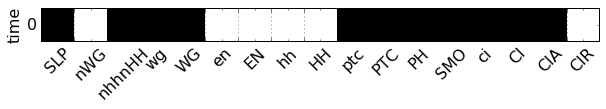

01100001111111010 ['nhhnHH-1', 'nWG-0', 'hh-0', 'CIR-0', 'EN-0', 'SMO-1', 'ptc-1', 'PTC-1', 'CI-1', 'ci-1', 'HH-0', 'WG-1', 'SLP-0', 'wg-1', 'PH-1', 'CIA-1', 'en-0']


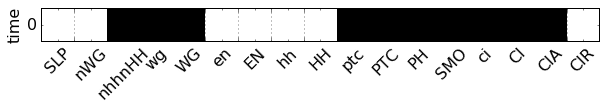

11100001111111011 ['nhhnHH-1', 'hh-0', 'CIR-0', 'EN-0', 'SMO-1', 'ptc-1', 'PTC-1', 'CI-1', 'ci-1', 'HH-0', 'wg-1', 'WG-1', 'SLP-1', 'PH-1', 'CIA-1', 'en-0', 'nWG-1']


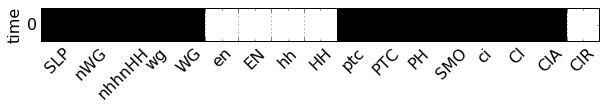

00011110001000011 ['hh-1', 'PH-0', 'CIR-0', 'nWG-1', 'ptc-0', 'PTC-0', 'wg-0', 'CI-0', 'HH-1', 'CIA-0', 'SMO-1', 'ci-0', 'WG-0', 'nhhnHH-1', 'en-1', 'SLP-0', 'EN-1']


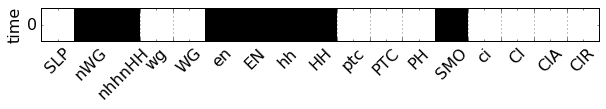

10000000100110101 ['hh-0', 'CIR-1', 'ptc-0', 'en-0', 'CI-1', 'CIA-0', 'nWG-1', 'ci-1', 'HH-0', 'SLP-1', 'wg-0', 'SMO-0', 'PTC-1', 'PH-0', 'nhhnHH-0', 'EN-0', 'WG-0']


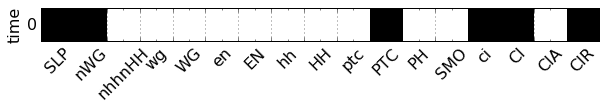

00011110001000001 ['hh-1', 'PH-0', 'CIR-0', 'nWG-1', 'ptc-0', 'PTC-0', 'wg-0', 'CI-0', 'HH-1', 'CIA-0', 'SMO-1', 'ci-0', 'WG-0', 'en-1', 'nhhnHH-0', 'SLP-0', 'EN-1']


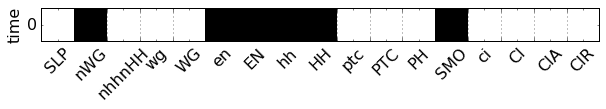

00000001111111010 ['nhhnHH-1', 'nWG-0', 'hh-0', 'CIR-0', 'SMO-1', 'en-0', 'CI-1', 'ci-1', 'HH-0', 'ptc-1', 'WG-0', 'PTC-1', 'PH-1', 'wg-0', 'CIA-1', 'EN-0', 'SLP-0']


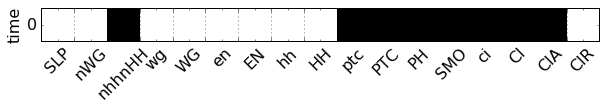

00011110100000001 ['hh-1', 'PH-0', 'CIR-0', 'nWG-1', 'ptc-0', 'wg-0', 'CI-0', 'HH-1', 'CIA-0', 'ci-0', 'PTC-1', 'WG-0', 'SMO-0', 'en-1', 'nhhnHH-0', 'SLP-0', 'EN-1']


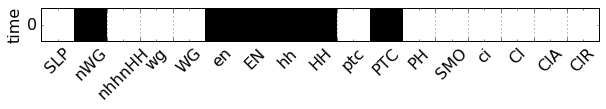

00000000100110100 ['nWG-0', 'hh-0', 'CIR-1', 'ptc-0', 'en-0', 'CI-1', 'CIA-0', 'ci-1', 'HH-0', 'PTC-1', 'WG-0', 'SMO-0', 'PH-0', 'wg-0', 'nhhnHH-0', 'EN-0', 'SLP-0']


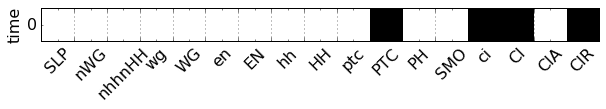

10000000100110100 ['nWG-0', 'hh-0', 'CIR-1', 'ptc-0', 'en-0', 'CI-1', 'CIA-0', 'ci-1', 'HH-0', 'SLP-1', 'wg-0', 'SMO-0', 'PTC-1', 'PH-0', 'nhhnHH-0', 'EN-0', 'WG-0']


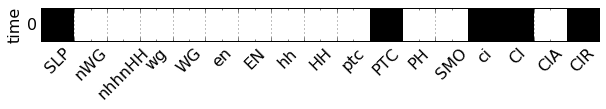

In [72]:
#note there are more than 5 attractors because inputs are also included (for Drosophila)
#11100001111111010,01100001111111010,11100001111111011 and 00011110001000011,00011110001000001
#and 10000000100110101,00000000100110100,10000000100110100 same without inputs [numbered (1,2,3),(4,6),(5,9,10)]
#00000001111111010 and 00011110100000001 unique [numbered (7),(8)]
attractors=attractors_to_dict(N)
for attractor in attractors: print sorted(attractors[attractor]-{'nhhnHH-1','nhhnHH-0','nWG-1','nWG-0','SLP-1','SLP-0'})
#print attractors
print [var.name for var in N.nodes]
nodes=['SLP','nWG','nhhnHH','wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
for attractor in attractors: 
    print attractor,list(attractors[attractor])
    visualize_unfolding(DCM,list(attractors[attractor]),node_set=nodes)
    plt.show()

(<matplotlib.figure.Figure at 0x18562d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x185622e8>)

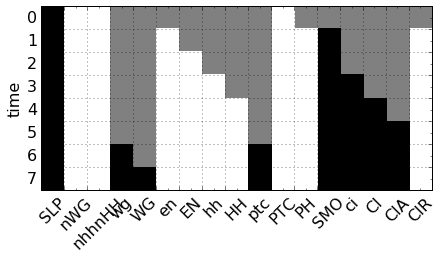

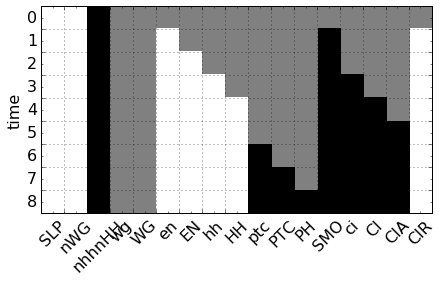

In [67]:
#orange module
nodes=['SLP','nWG','nhhnHH','wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
DCM = N.dynamics_canalization_map(output=None) #simplify=True
fig,ax=visualize_unfolding(DCM,['SLP-1','PTC-0','nWG-0','nhhnHH-0'],node_set=nodes,figsize=(7,7))
visualize_unfolding(DCM,['nhhnHH-1', 'nWG-0', 'SLP-0'],node_set=nodes,figsize=(7,7))

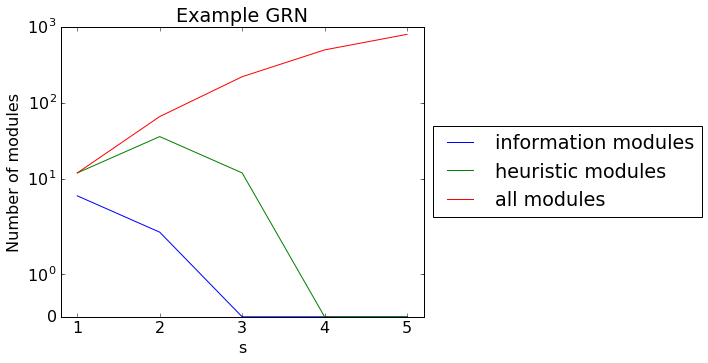

In [649]:
#create plot for number of combinations per s, between heuristic and if we tried all combinations
s=5 #specify max s value
xvalues=[i+1 for i in range(s)]
y1values=[6,2,0,0,0] #information modules
y2values=[12,36,12,0,0] #combinations checked with our heuristic
y3values=[12,66,220,495,792] #all possible combinations

plt.figure(figsize=(6.5,5.2))
plt.plot(xvalues,y1values,label='information modules')
plt.plot(xvalues,y2values,label='heuristic modules')
plt.plot(xvalues,y3values,label='all modules')
plt.title("Example GRN")
plt.ylabel("Number of modules")
plt.xlabel("s")
plt.yscale("symlog")
plt.xlim([.8,5.2])
#plt.ylim([-5,1005])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

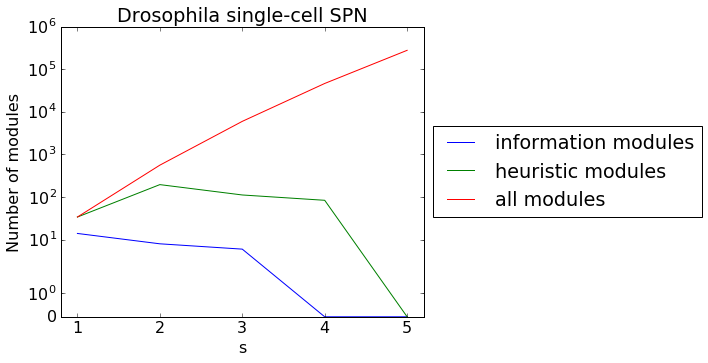

In [650]:
#create plot for number of combinations per s, between heuristic and if we tried all combinations
s=5 #specify max s value
xvalues=[i+1 for i in range(s)]
y1values=[14,8,6,0,0] #information modules
y2values=[34,196,112,84,0] #combinations checked with our heuristic
y3values=[34,561,5984,46376,278256] #all possible combinations

plt.figure(figsize=(6.5,5.2))
plt.plot(xvalues,y1values,label='information modules')
plt.plot(xvalues,y2values,label='heuristic modules')
plt.plot(xvalues,y3values,label='all modules')
plt.title("Drosophila single-cell SPN")
plt.ylabel("Number of modules")
plt.xlabel("s")
plt.yscale("symlog")
plt.xlim([.8,5.2])
#plt.ylim([-5,1005])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

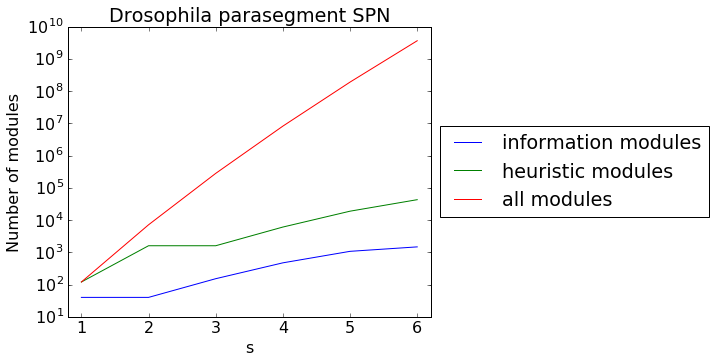

In [651]:
#create plot for number of combinations per s, between heuristic and if we tried all combinations
s=6 #specify max s value
xvalues=[i+1 for i in range(s)]
y1values=[40,40,152,472,1073,1475] #information modules
y2values=[120,1600,1600,6080,18880,42920] #combinations checked with our heuristic
y3values=[120,7140,280840,8214570,190578024,3652745460] #all possible combinations

plt.figure(figsize=(6.5,5.2))
plt.plot(xvalues,y1values,label='information modules')
plt.plot(xvalues,y2values,label='heuristic modules')
plt.plot(xvalues,y3values,label='all modules')
plt.title("Drosophila parasegment SPN")
plt.ylabel("Number of modules")
plt.xlabel("s")
plt.yscale("symlog")
plt.xlim([.8,6.2])
#plt.ylim([-5,1005])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

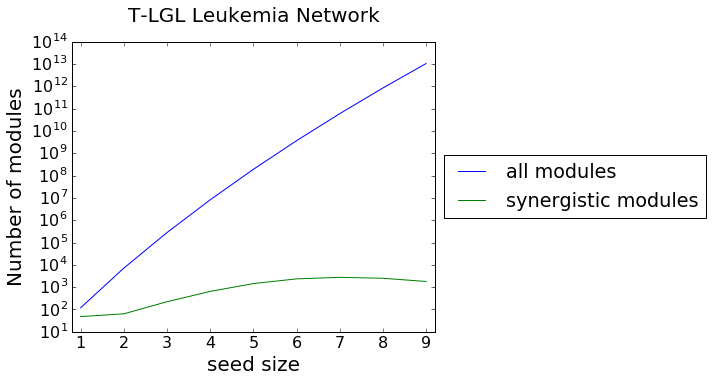

In [145]:
#create plot for number of combinations per s, between heuristic and if we tried all combinations
s=9 #specify max s value
xvalues=[i+1 for i in range(s)]
y1values=[48,64,223,646,1446,2353,2759,2501,1798] #information modules
#y2values=[120,2304,3072,10704,31008,69408,112944,132432,120048] #combinations checked with our heuristic
y3values=[120,7140,280840,8214570,190578024,3652745460,59487568920,840261910995,10456593000000] #all possible combinations

plt.figure(figsize=(6.5,5.2))
plt.plot(xvalues,y3values,label='all modules')
#plt.plot(xvalues,y2values,label='heuristic modules')
plt.plot(xvalues,y1values,label='synergistic modules')
plt.title("T-LGL Leukemia Network", y=1.05, fontsize=20)
plt.ylabel("Number of modules", fontsize=20)
plt.xlabel("seed size", fontsize=20)
plt.yscale("symlog")
plt.xlim([.8,9.2])
#plt.ylim([-5,1005])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('../../Dynamics/leukemia_speedup2.pdf',dpi=300,bbox_inches = "tight")

####Toy Network

In [1168]:
#TOY Network
attractors_toy=attractors_to_dict(N5)
print N5.attractors(), len(attractors_toy)
#for attractor in attractors_toy: print sorted(attractors_toy[attractor])

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [73], [74], [75], [76], [77], [78], [79], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [104], [105], [106], [107], [108], [109], [110], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63]] 64


In [228]:
# Request the DCM to the Network
DM5 = N5.dynamics_canalization_map(output=None, simplify=True) #simplify=False
# Draws using the graphviz interface.
#D2 = draw_dynamics_canalization_map_graphviz(DM5, overlap='true')
#display(D2)

In [229]:
#positional information for the toy network
att={}

if N5.name == '':
    foldername = 'toy'
    
    x,y = np.linspace(0,500,11,dtype=int), np.linspace(500,0,8,dtype=int)
    #ON states
    att['One-1']    = {'x':x[2],'y':y[3],'fillcolor':'#4f6fb0'}
    att['Two-1']    = {'x':x[7],'y':y[2],'fillcolor':'#4f6fb0'}
    att['Three-1']     = {'x':x[6],'y':y[3]}
    att['Four-1']     = {'x':x[1],'y':y[4]}
    att['Five-1'] = {'x':x[1],'y':y[5]}
    att['Six-1']     = {'x':x[3],'y':y[6]}
    att['X-1']    = {'x':x[5],'y':y[7]}
    #OFF states
    att['One-0']     = {'x':x[8],'y':y[3]}
    att['Two-0']     = {'x':x[4],'y':y[3]}
    att['Three-0']    = {'x':x[3],'y':y[2]}
    att['Four-0']    = {'x':x[9],'y':y[4]}
    att['Five-0']    = {'x':x[9],'y':y[5]}
    att['Six-0']    = {'x':x[7],'y':y[6]}
    att['X-0']     = {'x':x[5],'y':y[0]}
    #threshold nodes
    att['T-1_X-0']     = {'x':x[10],'y':y[2]}
    att['T-3_X-0']     = {'x':x[0],'y':y[2]}
    att['T-4_X-1']     = {'x':x[5],'y':y[5]}
    att['T-2_X-0']     = {'x':x[4],'y':y[1]}
    att['T-0_X-0']     = {'x':x[6],'y':y[1]}
    att['F-T1']     = {'x':x[3],'y':y[5]}
    att['F-T0']     = {'x':x[7],'y':y[5]}

set(['Five-1', 'Five-0', 'Six-1', 'Four-1', 'Four-0', 'Two-1', 'Three-0', 'Three-1', 'Six-0', 'T-4_X-1', 'One-0', 'F-T0', 'T-3_X-0', 'Two-0', 'F-T1', 'T-1_X-0', 'One-1', 'X-0', 'X-1'])


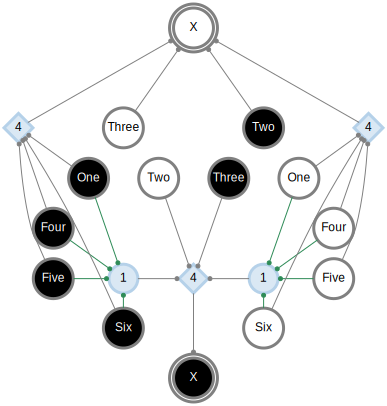

In [230]:
#print T5.nodes(data=True)
T5=create_threshold_network(DM5)
#D2 = draw_dynamics_canalization_map_graphviz(T5, overlap='true')
off_node_fontcolor,off_node_fillcolor='black','white',
on_node_fontcolor,on_node_fillcolor='white','black'
node_color,t_color='grey','#b5d1e9'
shape='circle'
skip_nodes=set([])

D = graphviz.Digraph(name='toy', engine='neato')
D.attr('graph', concentrate='false', simplify='false', overlap='False', splines='true', sep='+5')
D.attr('node', shape='circle', fixedsize='true', width='.55', color=node_color, style='filled', fillcolor='#515660', 
       penwidth='3', fontname='Helvetica', fontcolor='black',fontsize='12')
D.attr('edge', arrowhead='dot', arrowsize='.5', color='#545454', constraint='true')
#G.edge_attr.update(arrowhead='dot', color='gray', arrowsize='1', constraint='true')

#nodes
for node in T5:

    if node in att:
        natt = att[node]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        #else:
        #    fillcolor = '#515660'
    #else:
    #    xy = 'false'
    #    fillcolor = '#515660'
    
    if T5.node[node]['type']=='variable': 
        
        if T5.node[node]['variable']=='X':
            peripheries='2'
        else:
            peripheries='1'

        if T5.node[node]['value'] == 0:
            D.node(name=node, label=T5.node[node]['label'], pos=xy, peripheries=peripheries,
                   fontcolor=off_node_fontcolor, fillcolor=off_node_fillcolor, color=node_color, shape=shape)
        elif T5.node[node]['value'] == 1:
            D.node(name=node, label=T5.node[node]['label'], pos=xy, peripheries=peripheries,
                   fontcolor=on_node_fontcolor, fillcolor=on_node_fillcolor, color=node_color, shape=shape)
    elif T5.node[node]['type'] == 'threshold' and T5.node[node]['tau'] == 0:
        skip_nodes.add(node) #don't add this node
    elif T5.node[node]['type'] == 'threshold' and node[0]=='T': #traditional threshold node
        D.node(name=node, label=T5.node[node]['label'], shape='diamond', style='filled,solid', 
               fillcolor='#dae8f4', fontcolor='black', color=t_color, width='.4', height='.4', pos=xy)
    elif T5.node[node]['type'] == 'threshold' and node[0]=='F': #combined threshold node from fusion node
        #print node,T5.node[node]
        D.node(name=node, label=T5.node[node]['label'], shape='circle', style='filled,solid', 
               fillcolor='#dae8f4', fontcolor='black', color=t_color, width='.4', height='.4', pos=xy)
    elif T5.node[node]['type'] == 'fusion': #doesn't happen in threshold network
        D.node(name=node, label='', shape='circle', width='.4', height='.4', margin='0')
    #elif DCMS.node[node].get('label'):
    #    D.node(name=str(node), label=DCMS.node[node]['label'], pos=xy) #fillcolor=fillcolor
print set(T5.nodes())-skip_nodes
#edges
max_penwidth = 2.5
for s,t,d in T5.edges(data=True): #source, destination, weight
    #print s,t,d
    if s==t: continue #include this line to get rid of self-loops
    if s in skip_nodes or t in skip_nodes: continue #include this line to get rid of false 0-tau thresholds
    #weight = '%d' % (d['weight']*100)
    #penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    edge_color='grey'
        
    if T5[s][t].get('type'):
        D.edge(str(s),str(t),color=edge_color )
    
    else: #edges with 'fusion' nodes
        if T5.node[s]['type']=='threshold' and T5.node[t]['type']=='threshold': #line between threshold nodes
            D.edge(str(s),str(t),color=edge_color )
        else:
            D.edge(str(s),str(t),color='seagreen' )
    
display(D)

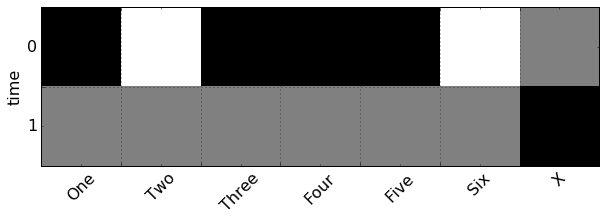

In [150]:
#how can this only have one attractor??
#note error with how toy network is constructed, see update file
#seed=['Five-1', 'Four-1', 'One-1', 'Seven-0', 'Six-1', 'Three-1', 'Two-1']
seed=['Five-1', 'Four-1', 'One-1', 'Six-1', 'Three-0', 'Two-0']
seed=['Five-1', 'Four-1', 'One-1', 'Six-0', 'Three-1', 'Two-0']
nodes=['One','Two','Three','Four','Five','Six','X']
visualize_unfolding(DM5,seed,node_set=nodes,input_type='pulse',time_limit=1)

In [1240]:
#find all dynamic modules
#NOTE: when finding minimal control configurations, we don't want to run the independence test!
#covers={}
num=6
#for num in range(1,8):
gci,mci,tmi,nmi=DCM_min_coverage(DM5,num=num,k=0,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
#tmi,tm,sizes,nmi=find_dynamic_modules(DCM,input_type='steady',num=3,samples=None,tm=True,seeds=None)
attractor=attractors_toy.keys()[0]
#print attractor
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==1: #nmi[top]
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DM5,seed,attractors=attractors_toy,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors_toy,input_type='steady')[1]!=0:
        #if attractor in reachables[0] and int(reachables[1]*10)==1:
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
        print "\tReachable attractors:",reachables[1]
#print BFS_threshold(DCM,['CIA-1'],'steady',time_limit=1),
#print int(unfolding_attractors(DCM,['CIA-1'],attractors=attractors,input_type='steady')[1]*10)
#print unfolding_attractors(DCM,['SLP-1', 'PTC-0'],attractors=attractors,input_type='pulse')
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
#print nodes_seen,len(nodes_seen),{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['nWG-0', 'nhhnHH-1', 'wg-0']" ]
#print ['X-0'],unfolding_attractors(DM5,['X-0'],attractors=attractors_toy,input_type='steady')[1]

Running iteration: 1	
top modules found: 13
['Two-1'] 	Length: 2 	Reachable attractors: 0.5
['Three-0'] 	Length: 2 	Reachable attractors: 0.5
['Two-0'] 	Length: 1 	Reachable attractors: 0.5
['Six-0'] 	Length: 1 	Reachable attractors: 0.5
['One-1'] 	Length: 1 	Reachable attractors: 0.5
['X-1'] 	Length: 1 	Reachable attractors: 0.21875
['Six-1'] 	Length: 1 	Reachable attractors: 0.5
['Five-0'] 	Length: 1 	Reachable attractors: 0.5
['Five-1'] 	Length: 1 	Reachable attractors: 0.5
['Four-0'] 	Length: 1 	Reachable attractors: 0.5
['One-0'] 	Length: 1 	Reachable attractors: 0.5
['Four-1'] 	Length: 1 	Reachable attractors: 0.5
['Three-1'] 	Length: 1 	Reachable attractors: 0.5
[0, None]


In [1241]:
#use greedy heuristic to check for cover
print len(tmi)
nodes=[x for x in DM5 if DM5.node[x]['type']=='variable']
cover,mc = graph_cover(tmi,nodes,q=13,approximate=False)
if cover:
    for c in cover: print c, len(c)
    score,max_cover=compare_cover_independence(DM5,cover,nmi,attractors=None)
    covers[str(num)]=max_cover
    print test_cover_independence(DM5,max_cover,nmi),score
    
#analyze cover
lengths=[]
for module in max_cover:
    lengths.append(len({x for t in tmi[module] for x in tmi[module][t]}))
print lengths, np.mean(lengths), max(lengths)

13
("['Two-0']", "['Six-0']", "['One-1']", "['Two-1']", "['X-1']", "['Six-1']", "['Five-0']", "['Three-0']", "['Five-1']", "['Four-0']", "['One-0']", "['Four-1']", "['Three-1']") 13
{"['Two-0']": 1.0, "['Six-0']": 1.0, "['One-1']": 1.0, "['Two-1']": 0.5, "['X-1']": 1.0, "['Six-1']": 1.0, "['Five-0']": 1.0, "['Three-0']": 0.5, "['Five-1']": 1.0, "['Four-0']": 1.0, "['One-0']": 1.0, "['Four-1']": 1.0, "['Three-1']": 1.0} 0.923076923077
[1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1] 1.15384615385 2


{'1': ["['Two-1']", "['Two-0']", "['Six-0']", "['One-1']", "['Five-1']", "['Six-1']", "['Five-0']", "['Four-0']", "['Three-0']", "['X-1']", "['One-0']", "['Four-1']", "['Three-1']"], '3': ["['Three-0', 'Two-1', 'Six-0']", "['Five-1', 'Four-0', 'X-1']", "['Five-0', 'Four-1', 'One-1']", "['Three-1', 'Six-1', 'One-0']", "['Two-0', 'Five-0', 'Three-1']"], '2': ["['Two-1', 'One-1']", "['Two-0', 'Five-1']", "['Four-1', 'X-1']", "['Three-0', 'Six-0']", "['Three-1', 'Four-0']", "['Five-0', 'Six-1']", "['Two-0', 'One-0']"], '5': ["['Five-1', 'Two-1', 'Three-1', 'Four-0', 'One-1']", "['Two-0', 'Three-0', 'Six-1', 'Four-1', 'X-1']", "['Five-0', 'Six-0', 'Four-1', 'One-0']"], '4': ["['Two-0', 'Five-1', 'One-0', 'Three-1']", "['Three-0', 'Five-0', 'Four-1', 'One-1']", "['Two-1', 'Six-1', 'Four-0', 'Three-1']", "['Two-1', 'Six-0', 'X-1']"], '7': ["['Two-0', 'Five-0', 'Four-1', 'Three-1', 'Six-1', 'One-0']", "['Five-1', 'Two-1', 'Four-0', 'Three-0', 'Six-0', 'One-1']"], '6': ["['Two-0', 'Five-0', 'Fo

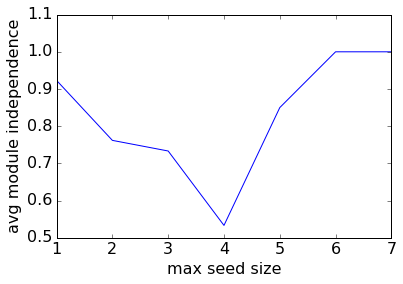

In [340]:
#compare covers
print covers
xvalues,yvalues=[i+1 for i in range(7)],[]
for i in xvalues:
    yvalues.append(np.mean([v for k,v in test_cover_independence(DM5,covers[str(i)],nmi).items()]))
plt.plot(xvalues,yvalues)
plt.xlabel("max seed size")
plt.ylabel("avg module independence")
print yvalues

In [1238]:
#analyze controllability
length=len(attractors_toy)
nlength=7
lengths=[] #hold minimal configuration lengths
drivers=set([])
input_type='steady'
num=7
set_type='control' #set type should be 'observe' or 'control', depending on how we want to analyze the network
gci,mci,tmi,nmi=DCM_min_coverage(DM5,num=num,k=0,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=False)
#for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
for attractor in attractors_toy:
    found=False
    for top in sorted(tmi, key=lambda x: len(nmi[x])): #start with smallest seeds to find minimal seed length
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DM5,seed,attractors=attractors_toy,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*length)==1:
            l=len({x for t in tmi[top] for x in tmi[top][t]})
            if set_type=='control' and l<nlength:
                continue #observable but not controlable
            print top,"\tLength:",l,#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*length)
            found=True #minimal driver set found
            lengths.append(len(nmi[top]))
            drivers=drivers.union(nmi[top])
            break
    if not found: print "No configuration to attractor found!"
        
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

Running iteration: 1	
top modules found: 13
Running iteration: 2	
top modules found: 72
Running iteration: 3	
top modules found: 220
Running iteration: 4	
top modules found: 368
Running iteration: 5	
top modules found: 360
Running iteration: 6	
top modules found: 196
Running iteration: 7	
top modules found: 64
['Two-1', 'Four-0', 'Five-0', 'Three-1', 'Six-1', 'One-0'] 	Length: 7 	Reachable attractors: 1
['Two-1', 'Four-0', 'Five-0', 'Three-1', 'Six-0', 'One-0'] 	Length: 7 	Reachable attractors: 1
['Five-0', 'Four-1', 'Two-1', 'Three-1', 'Six-0', 'One-0'] 	Length: 7 	Reachable attractors: 1
['Two-1', 'Four-1', 'Five-0', 'Three-1', 'Six-1', 'One-0'] 	Length: 7 	Reachable attractors: 1
['Five-1', 'Two-1', 'Four-0', 'Three-1', 'Six-0', 'One-1'] 	Length: 7 	Reachable attractors: 1
['Two-0', 'Five-0', 'Four-0', 'Three-0', 'Six-1', 'One-0'] 	Length: 7 	Reachable attractors: 1
['Two-0', 'Five-0', 'Four-0', 'Three-0', 'Six-0', 'One-0'] 	Length: 7 	Reachable attractors: 1
['Five-1', 'Two-0', 'Fo

In [1327]:
#compare to FVS
fvs=N5.feedback_vertex_set_driver_nodes()
for x in fvs:
    for node in x: print N5.nodes[node]

<BNode(name='One', k=1, inputs=[One], state=0, outputs='[0,1]' constant=False)>
<BNode(name='Two', k=1, inputs=[Two], state=0, outputs='[0,1]' constant=False)>
<BNode(name='Three', k=1, inputs=[Three], state=0, outputs='[0,1]' constant=False)>
<BNode(name='Four', k=1, inputs=[Four], state=0, outputs='[0,1]' constant=False)>
<BNode(name='Five', k=1, inputs=[Five], state=0, outputs='[0,1]' constant=False)>
<BNode(name='Six', k=1, inputs=[Six], state=0, outputs='[0,1]' constant=False)>


####Drosophila SPN

In [70]:
nodes=['SLP','nWG','nhhnHH','wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
DCM = N.dynamics_canalization_map(output=None) #simplify=True

In [469]:
new_modules={}
nm_scores={}
for module in tm.keys():
    seed=[s for s in nm[module]] #uses a node_mapping to get the proper seed
    if len(seed)<=2:
        ra,score=unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')
        if score>0:
            new_modules[str(seed)]=tm[str(seed)]
            nm_scores[str(seed)]=score
#for module in new_modules.keys()
#for cover in gc: pass
print len(tm),len(new_modules),len(gc)
for module in sorted(nm_scores,key=lambda x: nm_scores[x]):
    print module,nm_scores[module]

75 51 228
['wg-1', 'SLP-0'] 0.1
['nhhnHH-1', 'en-1'] 0.1
['nWG-1', 'wg-1'] 0.1
['SMO-0', 'en-1'] 0.1
['nWG-1', 'CIR-1'] 0.1
['nhhnHH-0', 'PTC-0'] 0.1
['nWG-1', 'ptc-1'] 0.1
['nWG-1', 'CIA-1'] 0.1
['PH-1', 'nWG-1'] 0.1
['SLP-0', 'CIR-1'] 0.1
['nWG-0', 'nhhnHH-0'] 0.2
['SMO-0', 'nWG-0'] 0.2
['ptc-1', 'SLP-0'] 0.2
['nhhnHH-0', 'en-1'] 0.2
['nWG-0', 'wg-1'] 0.2
['nWG-1', 'PTC-0'] 0.2
['SMO-0', 'nWG-1'] 0.2
['PTC-0'] 0.2
['nhhnHH-1', 'SLP-1'] 0.2
['nhhnHH-1', 'nWG-1'] 0.2
['SLP-0', 'CIA-1'] 0.2
['SLP-0', 'PTC-0'] 0.2
['PH-1', 'SLP-0'] 0.2
['SMO-0', 'SLP-0'] 0.2
['SMO-0', 'SLP-1'] 0.2
['nhhnHH-0', 'SLP-1'] 0.2
['nWG-1', 'SLP-1'] 0.2
['nWG-0', 'SLP-1'] 0.2
['SLP-1', 'CIR-1'] 0.2
['nWG-0', 'CIR-1'] 0.2
['CIR-1'] 0.3
['nhhnHH-1', 'SLP-0'] 0.3
['nhhnHH-0', 'CIR-1'] 0.3
['nWG-1', 'nhhnHH-0'] 0.3
['wg-1'] 0.3
['en-1'] 0.3
['nhhnHH-0', 'SLP-0'] 0.3
['nWG-1', 'SLP-0'] 0.3
['SMO-0', 'CIR-1'] 0.3
['nWG-0', 'nhhnHH-1'] 0.3
['nWG-0', 'SLP-0'] 0.3
['PH-1'] 0.4
['ptc-1'] 0.4
['SMO-0'] 0.4
['SLP-1'] 0.4
['

In [74]:
#modules of the input combinations
seeds=[['SLP-1'],['SLP-0'],['nWG-1'],['nWG-0'],['nhhnHH-1'],['nhhnHH-0']]
num=1
input_type='steady'
gci,mci,tmi,nmi=DCM_min_coverage(DCM,num=num,k=1,input_type=input_type,time_limit=2,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==num:
        seed=[s for s in nmi[top]]
        if unfolding_attractors(DCM,seed,attractors=attractors,input_type=input_type)[1]>=0:
            print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#'\n',[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(unfolding_attractors(DCM,seed,attractors=attractors,input_type=input_type)[1]*10)
            #print [x for x in tmi[top][max(tmi[top])]] #show last time step
            #print unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
#print nodes_seen,len(nodes_seen),{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['SLP-1', 'PTC-0']"] #extended pink module #"['nhhnHH-1', 'SLP-1']"
#print tmi["['nhhnHH-1', 'CIR-1']"]
#print tmi["['nhhnHH-1', 'nWG-1', 'SLP-0']"] #extended blue module
#print tmi["['nhhnHH-1']"]

Running iteration: 1	
top modules found: 14
['en-1'] 	Length: 9 	Reachable attractors: 3
['SLP-1'] 	Length: 7 	Reachable attractors: 4
['nWG-0'] 	Length: 7 	Reachable attractors: 5
['CIR-1'] 	Length: 6 	Reachable attractors: 3
['PTC-0'] 	Length: 4 	Reachable attractors: 2
['nhhnHH-1'] 	Length: 3 	Reachable attractors: 5
['wg-1'] 	Length: 2 	Reachable attractors: 3
['nhhnHH-0'] 	Length: 2 	Reachable attractors: 5
['ptc-1'] 	Length: 2 	Reachable attractors: 4
['PH-1'] 	Length: 1 	Reachable attractors: 4
['SMO-0'] 	Length: 1 	Reachable attractors: 4
['SLP-0'] 	Length: 1 	Reachable attractors: 6
['CIA-1'] 	Length: 1 	Reachable attractors: 4
['nWG-1'] 	Length: 1 	Reachable attractors: 5
[9, ("['en-1']",)]


In [1041]:
seed=['nhhnHH-1','SLP-1']
tn=['en-1']
run_synergy_test(DCM,(seed,tn),input_type='steady',time_limit=1,conversion=True)

{'PH-0', 'PTC-0'}

In [775]:
for i,cover in enumerate(gci): 
    if "['nWG-1', 'SLP-0']" in cover: print i,cover
    print i,cover

0 ("['nhhnHH-1', 'SLP-1', 'nWG-0']", "['nhhnHH-1', 'nWG-1', 'SLP-0']", "['nWG-0', 'nhhnHH-0', 'ptc-1']")
1 ("['nhhnHH-1', 'nWG-1', 'SLP-0']", "['PH-1', 'SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-0', 'ptc-1']")
2 ("['nhhnHH-1', 'nWG-1', 'SLP-0']", "['nhhnHH-1', 'SLP-1']", "['nWG-0', 'nhhnHH-0', 'ptc-1']")
3 ("['nhhnHH-1', 'nWG-1', 'SLP-0']", "['nWG-0', 'nhhnHH-0', 'ptc-1']", "['SMO-0', 'nhhnHH-1', 'SLP-1']")


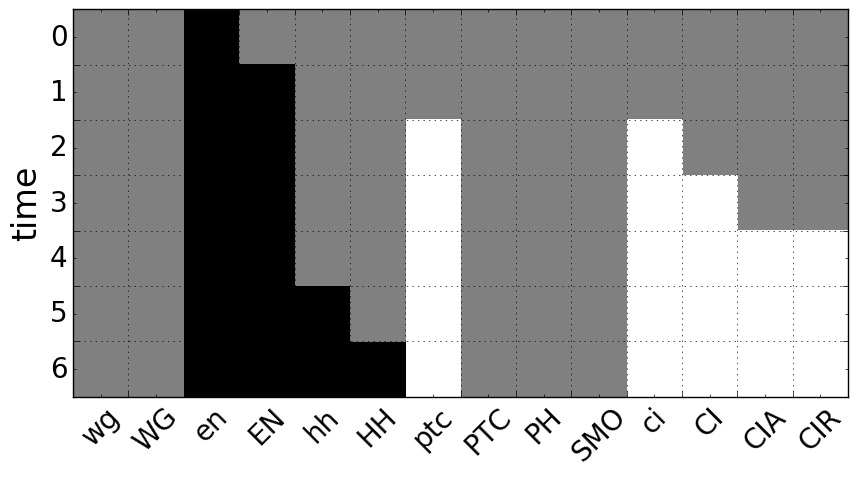

In [1383]:
nodes=['wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
seed=['nWG-0', 'nhhnHH-1', 'CIR-1'] 
seed=['SLP-1', 'nhhnHH-1', 'CIR-1'] 
seed=['nhhnHH-1', 'nWG-0', 'en-1'] 
seed=['SLP-1', 'nhhnHH-0', 'ptc-1']
seed=['nhhnHH-1', 'nWG-0', 'SLP-0', 'en-1'] 
seed=['nhhnHH-1', 'en-1', 'ptc-1', 'SLP-0'] 
seed=['en-1']
fig,ax=visualize_unfolding(DCM,seed,node_set=nodes,input_type='steady',time_limit=1)
ax.yaxis.label.set_fontsize(24)
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_minor_ticks():
    tick.label.set_fontsize(20)
#plt.savefig('../../Dynamics/drosophila_en_1_unfolding_steady-state.pdf',dpi=300,bbox_inches = "tight")

In [571]:
#Optimal Modules:
#should contain a connected unfolding (not fragmented)  -- include test for independence
#should be initiated by a minimum number of nodes  -- start with num=1, increase num
#should be as long as possible  -- when condensing, start with the longest modules
#a proper set of modules should cover the graph  -- test for graph cover at each stage or return max cover after k steps

In [337]:
#TODO: compute control from unfolding, conditional control of adding seed as information gain
#TODO: the same for observability but work backwards also... what configurations could lead to this seed?
#TODO: compare above with seeds found via fvs/structural methods

In [123]:
#check against top modules previously found
n,t,s,c=find_dynamic_modules(DCM,input_type='steady',num=2,samples=None,tm=True)
oddballs=set([])
for mod1 in t:
    found=False
    for mod2 in tm:
        if c[mod1]==translator[mod2]: 
            found=True
    if not found:
        oddballs.add(mod1)
print oddballs
#check one
print n["['CI-1', 'CIA-0']"]
print n["['CI-1', 'en-1']"] #note this doesn't unfold anymore due to contradiction
#adding more seed nodes lead to more contradictions
unfolding=BFS_threshold(DCM,['CI-1', 'en-1'])
print unfolding

set(["['CI-1', 'CIA-0']", "['CIR-1', 'hh-1']", "['CI-0', 'ci-1']", "['CIR-1', 'WG-1']", "['EN-1', 'ci-1']", "['SLP-1', 'ci-0']", "['CI-1', 'EN-1']", "['wg-1', 'WG-0']", "['PTC-1', 'nhhnHH-0']", "['EN-0', 'en-1']", "['EN-0', 'hh-1']", "['EN-1', 'nWG-0']", "['HH-1', 'CIR-1']", "['HH-0', 'hh-1']"])
{0: set(['CI-1', 'CIA-0']), 1: set(['ptc-0'])}
{0: set(['CI-1', 'en-1']), 1: set(['EN-1']), 2: set(['ci-0', 'ptc-0'])}
{0: set(['CI-1', 'en-1']), 1: set(['T-0_ptc-0', 'F-T3', 'EN-1']), 2: set(['ci-0', 'ptc-0'])}


In [97]:
s1={'nWG-1', 'EN-1'}
s2={'hh-1', 'CIR-0', 'SMO-0', 'HH-1', 'CIA-0', 'CI-0', 'ptc-0', 'ci-0', 'en-1', 'EN-1'}
s3={'hh-1', 'nWG-1', 'CIR-0', 'HH-1', 'CI-0', 'ptc-0', 'ci-0', 'CIA-0', 'EN-1'}
print s1-s3
s4={'nWG-1'}
for e in s4: print e

set([])
nWG-1


In [78]:
#record all dynamic modules of one starting node
num=4 #numbers 4+ are no longer instantaneous for drosophila
nu,tm,sizes,candidates=find_dynamic_modules(DCM,input_type='steady',num=num)
if num==1: #visualize top modules
    for node in sorted(tm,key=lambda x:sizes[x],reverse=True): 
        print node,[x for t in tm[node] for x in tm[node][t]] #tm[node]
        #print node,len({x for t in tm[node] for x in tm[node][t]})
else: #visualize number of node states discovered, may be repeats if input_type=pulse
    for node in sorted(sizes,key=lambda x:sizes[x],reverse=True)[:15]: 
        print node,sizes[node]
        #print node,len({x for t in nu[node] for x in nu[node][t]})
        #print nu[node]
print len(tm),len(nu)

['CIR-1', 'SLP-0', 'nhhnHH-1', 'nWG-1'] 17
['HH-0', 'SLP-1', 'nhhnHH-1', 'nWG-1'] 17
['en-0', 'SLP-1', 'nhhnHH-1', 'nWG-0'] 17
['HH-1', 'SLP-1', 'nhhnHH-1', 'nWG-1'] 17
['wg-0', 'SLP-1', 'nhhnHH-1', 'nWG-1'] 17
['SLP-0', 'nhhnHH-1', 'nWG-1', 'ci-0'] 17
['SLP-0', 'nhhnHH-1', 'en-1', 'nWG-0'] 17
['PTC-0', 'SLP-0', 'nhhnHH-0', 'nWG-1'] 17
['SLP-1', 'SMO-1', 'nhhnHH-1', 'nWG-0'] 17
['SLP-1', 'nhhnHH-1', 'hh-0', 'nWG-1'] 17
['wg-1', 'SLP-0', 'nhhnHH-1', 'nWG-0'] 17
['SLP-0', 'SMO-1', 'nhhnHH-1', 'nWG-1'] 17
['SLP-1', 'nhhnHH-1', 'nWG-1', 'CIA-1'] 17
['SLP-0', 'nhhnHH-1', 'hh-1', 'nWG-1'] 17
['SLP-0', 'nhhnHH-1', 'nWG-0', 'CIA-0'] 17
1092 38080


In [539]:
#record ALL modules without using the heuristic and then check for synergy
num=1
gc,mc,tm,nm=DCM_min_coverage(DCM,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True,tops=True
                             ,test_all=True)
#print run_synergy_test(DCM,seeds,input_type='steady',time_limit=1,conversion=True)
for top in sorted(tm,key=lambda x: len({y for t in tm[x] for y in tm[x][t]}),reverse=True):
    if len(nm[top])==num:
        print top,"\tLength:",len({x for t in tm[top] for x in tm[top][t]})

#unfolding=BFS_threshold(DCM,['nhhnHH-0', 'PTC-1'])
#print unfolding

Running iteration: 1	34
top modules found: 14
['en-1'] 	Length: 9
['SLP-1'] 	Length: 7
['nWG-0'] 	Length: 7
['CIR-1'] 	Length: 6
['PTC-0'] 	Length: 4
['nhhnHH-1'] 	Length: 3
['wg-1'] 	Length: 2
['nhhnHH-0'] 	Length: 2
['ptc-1'] 	Length: 2
['PH-1'] 	Length: 1
['SMO-0'] 	Length: 1
['SLP-0'] 	Length: 1
['CIA-1'] 	Length: 1
['nWG-1'] 	Length: 1


In [573]:
#use heuristic of building off top modules
#dcovers={}
#mcovers={} #min size cover scores
num=3
gc,mc,tm,nm=DCM_min_coverage(DCM,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tm,key=lambda x: len({y for t in tm[x] for y in tm[x][t]}),reverse=True):
    if len(nm[top])==num: #nmi[top]
        seed=[s for s in nm[top]]
        reachables=unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        #if attractor in reachables[0] and int(reachables[1]*10)==1:
        if reachables[1]>=0:
            print top,"\tLength:",len({x for t in tm[top] for x in tm[top][t]}),
            print "\tReachable attractors:",reachables[1]
print gc

Running iteration: 1	34
top modules found: 14
Running iteration: 2	20
top modules found: 8
Running iteration: 3	12
top modules found: 6
['nhhnHH-1', 'nWG-1', 'SLP-0'] 	Length: 17 	Reachable attractors: 0.1
['nWG-0', 'nhhnHH-1', 'CIR-1'] 	Length: 16 	Reachable attractors: 0.0
['nhhnHH-1', 'SLP-1', 'CIR-1'] 	Length: 16 	Reachable attractors: 0.0
['SLP-1', 'nhhnHH-0', 'ptc-1'] 	Length: 16 	Reachable attractors: 0.0
['nWG-0', 'nhhnHH-0', 'ptc-1'] 	Length: 16 	Reachable attractors: 0.0
['nhhnHH-0', 'ptc-1', 'SLP-0'] 	Length: 9 	Reachable attractors: 0.0
[]


In [574]:
#use greedy heuristic to check for cover
q=3
nodes=[x for x in DCM if DCM.node[x]['type']=='variable']
#new_modules=filter_modules(DCM,tm,nm,attractors,input_type='steady',time_limit=1,conversion=True)
print len(tm)#,len(new_modules)
cover,mc = graph_cover(tm,nodes,q=q,approximate=False) #new_modules
#print type(cover),type(cover[0]),cover[0],len(cover[0])
#print cover, mc, len(cover[0]), len(cover)
score,max_cover=compare_cover_independence(DCM,cover,nm,attractors=None)
#dcovers[str(q)]=max_cover
#dcovers[str(num)]=max_cover
#mcovers[str(num)]=max_cover
print score, len(cover) #,max_cover,
#print cover
#for c in cover:
#    print test_cover_independence(DCM,c,nm)
if max_cover: print test_cover_independence(DCM,max_cover,nm)

28
0.383578431373 1
{"['nhhnHH-1', 'nWG-1', 'SLP-0']": 0.5882352941176471, "['nWG-0', 'nhhnHH-0', 'ptc-1']": 0.25, "['nhhnHH-1', 'SLP-1']": 0.3125}


In [1111]:
print mcovers

{'1': ("['wg-1']", "['PH-1']", "['nhhnHH-0']", "['SLP-1']", "['SMO-0']", "['nhhnHH-1']", "['en-1']", "['CIR-1']", "['ptc-1']", "['SLP-0']", "['CIA-1']", "['PTC-0']", "['nWG-0']", "['nWG-1']"), '3': ("['nhhnHH-1', 'nWG-1', 'SLP-0']", "['nhhnHH-1', 'SLP-1']", "['nWG-0', 'nhhnHH-0', 'ptc-1']"), '2': ("['nhhnHH-0', 'ptc-1']", "['nWG-0']", "['nhhnHH-1', 'SLP-1']", "['nhhnHH-1', 'CIR-1']", "['nWG-1', 'SLP-0']")}


In [922]:
#analyze cover
lengths=[]
for module in max_cover:
    lengths.append(len({x for t in tm[module] for x in tm[module][t]}))
print lengths, np.mean(lengths), max(lengths)

[1, 1, 7, 1, 2, 13, 16, 1] 5.25 16


{'1': ("['wg-1']", "['PH-1']", "['nhhnHH-0']", "['SLP-1']", "['SMO-0']", "['nhhnHH-1']", "['en-1']", "['CIR-1']", "['ptc-1']", "['SLP-0']", "['CIA-1']", "['PTC-0']", "['nWG-0']", "['nWG-1']")}
[(1, 14), (2, 10), (3, 8), (4, 8)]


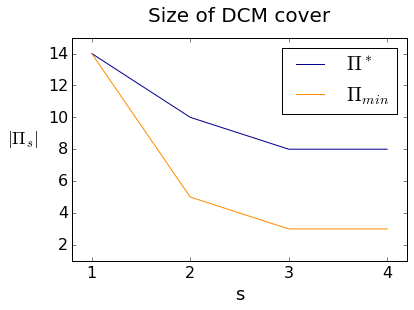

In [566]:
#compare covers across N values
#print dcovers
#xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
#for i in xvalues:
#    yvalues.append(len(dcovers[str(i)]))
#yvalues.append(yvalues[-1])
#xvalues.append(xvalues[-1]+1)
#plt.figure(figsize=(6.5,5.2))
xvalues=[1,2,3,4]
yvalues=[14,10,8,8]
y2values=[14,5,3,3]
plt.plot(xvalues,yvalues,label=r'$\Pi^*$',color='darkblue') #label=r'max $d$' or r'$\Pi^*_s$'
plt.plot(xvalues,y2values,label=r'$\Pi_{min}$',color='darkorange') #label=r'min $|\Pi_s|$'
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel(r'$|\Pi_s|$',fontsize=18,rotation=0,labelpad=25) #plt.ylabel("number of modules",fontsize=18)
plt.title("Size of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.xlim([.8,4.2])
plt.xticks([1,2,3,4])
plt.ylim([1,15])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/drosophila_cover_size2.pdf',dpi=300,bbox_inches = "tight")

[(1, 0.6890589569160996), (2, 0.733015873015873), (3, 0.8111263736263736), (4, 0.8111263736263736)]


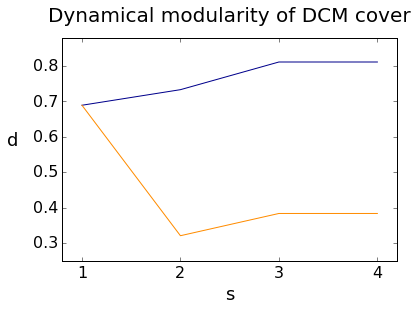

In [581]:
#compare covers across N values
#print dcovers
'''
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
y2values=[]
for i in xvalues:
    yvalues.append(np.mean([v for k,v in test_cover_independence(DCM,dcovers[str(i)],nm).items()]))
    y2values.append(np.mean([v for k,v in test_cover_independence(DCM,mcovers[str(i)],nm).items()]))
yvalues.append(yvalues[-1])
xvalues.append(xvalues[-1]+1)
y2values.append(y2values[-1]) #'''
xvalues=[1,2,3,4]
yvalues=[0.68905895691609964,0.73301587301587301,0.81112637362637363,0.81112637362637363]
y2values=[.6891,.3208,.3836,.3836]
plt.plot(xvalues,yvalues,label=r'$\Pi^*$',color='darkblue') #label=r'min $d$'
plt.plot(xvalues,y2values,label=r'$\Pi_{min}$',color='darkorange') #label=r'min $|\Pi|$'
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel("d",fontsize=18,rotation=0,labelpad=20) #plt.ylabel("dynamical modularity",fontsize=18)
plt.title("Dynamical modularity of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(fontsize=20)
plt.xlim([.8,4.2])
plt.xticks([1,2,3,4])
plt.ylim([0.25,0.88])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/drosophila_cover_score2.pdf',dpi=300,bbox_inches = "tight")

{'1': None, '3': ("['nhhnHH-1', 'nWG-1', 'SLP-0']", "['nhhnHH-1', 'SLP-1']", "['nWG-0', 'nhhnHH-0', 'ptc-1']"), '2': None, '5': ("['PH-1']", "['wg-1']", "['nWG-0', 'nhhnHH-1', 'CIR-1']", "['SLP-1', 'nhhnHH-0', 'ptc-1']", "['nWG-1', 'SLP-0']"), '4': ("['PH-1']", "['nhhnHH-1', 'nWG-1', 'SLP-0']", "['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-0', 'ptc-1']"), '7': ("['PH-1']", "['SLP-0']", "['nWG-1']", "['wg-1']", "['nWG-0', 'nhhnHH-1', 'CIR-1']", "['en-1']", "['SLP-1', 'nhhnHH-0', 'ptc-1']"), '6': ("['PH-1']", "['SLP-0']", "['nWG-1']", "['nhhnHH-1', 'en-1']", "['SLP-1', 'PTC-0']", "['nWG-0', 'nhhnHH-0', 'ptc-1']"), '8': ("['PH-1']", "['SLP-0']", "['nWG-0']", "['nWG-1']", "['wg-1']", "['nhhnHH-1', 'en-1']", "['SLP-1', 'nhhnHH-0', 'ptc-1']", "['CIA-1']")}
[(3, 0.38357843137254904), (4, 0.54185049019607845), (5, 0.66346153846153855), (6, 0.71992521367521378), (7, 0.77182539682539686), (8, 0.81112637362637363)]


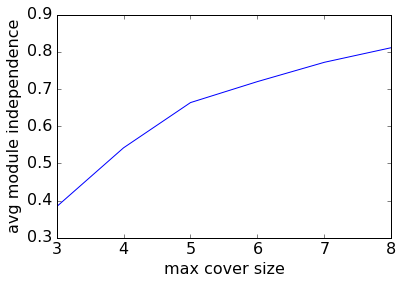

In [923]:
#compare covers with the same N value
print dcovers
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
for i in xvalues:
    yvalues.append(np.mean([v for k,v in test_cover_independence(DCM,dcovers[str(i)],nm).items()]))
plt.plot(xvalues,yvalues)
plt.xlabel("max cover size")
plt.ylabel("avg module independence")
#plt.title("N="+str(num))
print zip(xvalues,yvalues)

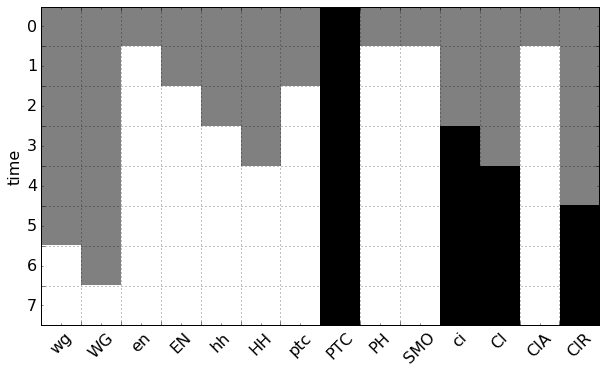

In [91]:
#test dynamic unfolding of three nodes from the paper; results the same for both steady and pulse (because inputs have self-loops)
#nodes = {node.name for node in N.nodes}
nodes=['wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
seed=['SLP-1','nWG-0','nhhnHH-1']  #['SLP-0','nWG-0','nhhnHH-0'], ['PTC-0', 'SLP-1', 'ptc-0'], ['PTC-0', 'CIR-1', 'en-0'] 
seed=['SLP-0', 'wg-1', 'nWG-1', 'nhhnHH-1']  #['PTC-1', 'CI-1', 'nhhnHH-0', 'SLP-1']
seed=['nWG-0', 'nhhnHH-1', 'SLP-0', 'wg-1']
seed=['SLP-1','nWG-1','nhhnHH-0','PTC-1']
#seed=['SLP-1','nWG-0','nhhnHH-1'] #extended pink (red) module
#seed=['SLP-0','nWG-1','nhhnHH-1'] #extended blue module
#seed=['SLP-1','nWG-0','PTC-0'] #alternate pink extension (salmon module)
#seed=['ptc-1','nhhnHH-0'] #extended orange(brown) module
visualize_unfolding(DCM,seed,node_set=nodes,input_type='steady',time_limit=1)

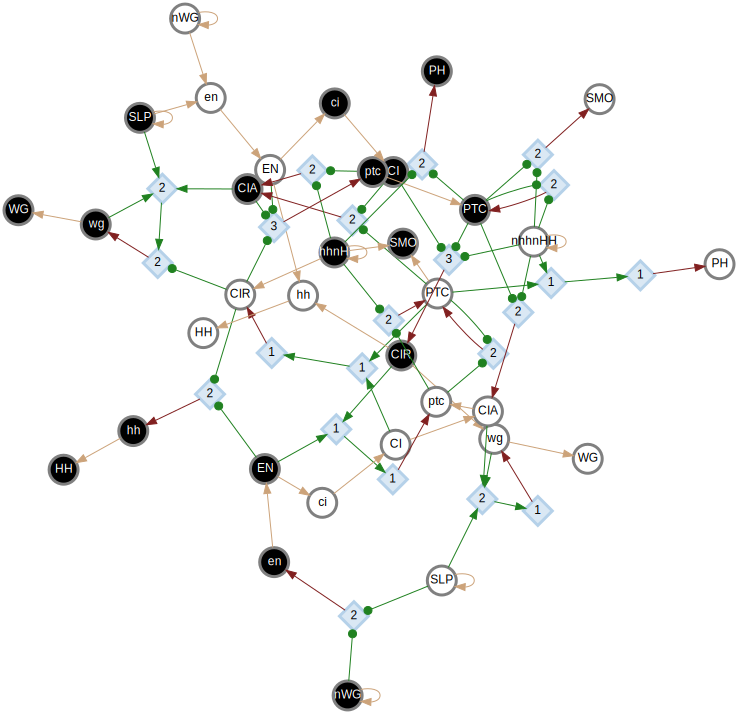

In [22]:
#visualize threshold network
T=create_threshold_network(DCM)
DT = draw_dynamics_canalization_map_graphviz(T, overlap='true',
                                            constant_node_bordercolor='red', controlled_node_bordercolor='orange')
display(DT)

In [253]:
seed=['nWG-0', 'nhhnHH-1'] #['PTC-0', 'SLP-1', 'ptc-0'], ['PTC-0', 'CIR-1', 'en-0']
#seed=['hh-0', 'ptc-0', 'EN-0', 'wg-0'] #['PTC-1', 'CI-1', 'nhhnHH-0', 'SLP-1']
seed=['en-1']
#visualize_pathway(DCM,seed,input_type='steady',start_color='red',path_color='blue')
#{0: set(['PTC-1', 'CI-1', 'nhhnHH-0', 'SLP-1']), 1: set(['SMO-0', 'PH-0', 'CIR-1', 'en-0', 'CIA-0']), 
#2: set(['hh-0', 'ptc-0', 'EN-0', 'wg-0']), 3: set(['ci-1', 'HH-0', 'WG-0', 'hh-0']), 4: set(['HH-0'])}

In [416]:
#compare to FVS
fvs=N.feedback_vertex_set_driver_nodes()
for x in fvs:
    for node in x: print N.nodes[node]

<BNode(name='SLP', k=1, inputs=[SLP], state=0, outputs='[0,1]' constant=False)>
<BNode(name='wg', k=4, inputs=[SLP,wg,CIA,CIR], state=0, outputs='[0,0,0,0...1,0,1,0]' constant=False)>
<BNode(name='nhhnHH', k=1, inputs=[nhhnHH], state=0, outputs='[0,1]' constant=False)>
<BNode(name='nWG', k=1, inputs=[nWG], state=0, outputs='[0,1]' constant=False)>
<BNode(name='PTC', k=3, inputs=[ptc,PTC,nhhnHH], state=0, outputs='[0,0,1,0,1,1,1,1]' constant=False)>


In [421]:
#find all dynamic modules based on this driver set
#NOTE: when finding minimal control configurations, we don't want to run the independence test!
seeds=[['SLP-1'],['SLP-0'],['nWG-1'],['nWG-0'],['nhhnHH-1'],['nhhnHH-0'],['wg-1'],['wg-0'],['PTC-1'],['PTC-0']]
gci,mci,tmi,nmi=DCM_min_coverage(DCM,num=2,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=False)
#tmi,tm,sizes,nmi=find_dynamic_modules(DCM,input_type='steady',num=3,samples=None,tm=True,seeds=None)
attractor=attractors.keys()[1]
print attractor
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])>=0: #nmi[top]
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*10)==1:
            print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*10)
#print BFS_threshold(DCM,['CIA-1'],'steady',time_limit=1),
#print int(unfolding_attractors(DCM,['CIA-1'],attractors=attractors,input_type='steady')[1]*10)
#print unfolding_attractors(DCM,['SLP-1', 'PTC-0'],attractors=attractors,input_type='pulse')
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
#print nodes_seen,len(nodes_seen),{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['nWG-0', 'nhhnHH-1', 'wg-0']" ]

Running iteration: 1	
top modules found: 14
Running iteration: 2	
top modules found: 61
01100001111111010
['wg-1', 'SLP-0'] 	Length: 3 	Reachable attractors: 1
[16, ("['nhhnHH-1', 'SLP-1']",)]


In [ ]:
#TODO: find intersection of minimal observability sets
#determine if there is a smaller set for observability than FVS
#get all modules of size 4 for each attractor (just variables); brute force check if any set size 4 covers all attractors
a1={'nhhnHH-1', 'SLP-1', 'nWG-0','SLP-1', 'ptc-1', 'nWG-0','wg-1', 'SLP-1', 'nWG-0','SLP-1', 'nWG-0', 'WG-1',
                  'CIR-0', 'SLP-1', 'nWG-0','SLP-1', 'nWG-0', 'CIA-1','SLP-1', 'nWG-0', 'PH-1','SLP-1', 'SMO-1', 'nWG-0'}
a2={'wg-1', 'SLP-0','SLP-0', 'WG-1'}
a3={'nWG-1', 'wg-1','ptc-1', 'nWG-1','nWG-1', 'PH-1','nWG-1', 'CIA-1','nWG-1', 'WG-1'}

In [925]:
print attractors.keys()
print np.mean([3,4,3,3,4,4,4,4,4,4]) #attractor control seed sizes

['11100001111111010', '01100001111111010', '11100001111111011', '00011110001000011', '10000000100110101', '00011110001000001', '00000001111111010', '00011110100000001', '00000000100110100', '10000000100110100']
3.7


In [72]:
#attractor controllability to all attractors
length=len(attractors)
nlength=17
lengths=[] #hold minimal configuration lengths
drivers=set([])
input_type='steady'
num=4
set_type='control' #set type should be 'observe' or 'control', depending on how we want to analyze the network
gci,mci,tmi,nmi=DCM_min_coverage(DCM,num=num,k=0,input_type=input_type,time_limit=1,conversion=True,seeds=None,
                                 ind_test=False,tops=False)
#for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
#for top in tmi:
#    if nmi[top]=={'nWG-0','SLP-0','nhhnHH-1','CIR-1'}: print top, tmi[top]
for attractor in attractors:
    #print attractor
    found=False
    for top in sorted(tmi, key=lambda x: len(nmi[x])): #start with smallest seeds to find minimal seed length
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DCM,seed,attractors=attractors,input_type=input_type)
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*length)==1:
            l=len({x for t in tmi[top] for x in tmi[top][t]})
            if set_type=='control' and l<nlength:
                continue #observable but not controlable
            print top,"\tLength:",l,#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*length)
            found=True #minimal driver set found
            lengths.append(len(nmi[top]))
            drivers=drivers.union(nmi[top])
            break
    if not found: print "No configuration to attractor found!", attractor
        
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

Running iteration: 1	
top modules found: 34
Running iteration: 2	
top modules found: 610
Running iteration: 3	
top modules found: 7919
Running iteration: 4	
top modules found: 88666
['nhhnHH-1', 'SLP-1', 'nWG-0'] 	Length: 17 	Reachable attractors: 1
['nWG-0', 'wg-1', 'nhhnHH-1', 'SLP-0'] 	Length: 17 	Reachable attractors: 1
['nhhnHH-1', 'nWG-1', 'SLP-1'] 	Length: 17 	Reachable attractors: 1
['nhhnHH-1', 'nWG-1', 'SLP-0'] 	Length: 17 	Reachable attractors: 1
['PTC-1', 'nhhnHH-0', 'SLP-1', 'nWG-1'] 	Length: 17 	Reachable attractors: 1
['PTC-0', 'nhhnHH-0', 'SLP-0', 'nWG-1'] 	Length: 17 	Reachable attractors: 1
['nWG-0', 'nhhnHH-1', 'SLP-0', 'wg-0'] 	Length: 17 	Reachable attractors: 1
['nhhnHH-0', 'PTC-1', 'SLP-0', 'nWG-1'] 	Length: 17 	Reachable attractors: 1
['nWG-0', 'nhhnHH-0', 'PTC-1', 'SLP-0'] 	Length: 17 	Reachable attractors: 1
['PTC-1', 'nWG-0', 'nhhnHH-0', 'SLP-1'] 	Length: 17 	Reachable attractors: 1
10 3.7 4 3
set(['nWG-0', 'nWG-1', 'wg-0', 'wg-1', 'PTC-0', 'SLP-1', 'PTC-1', 

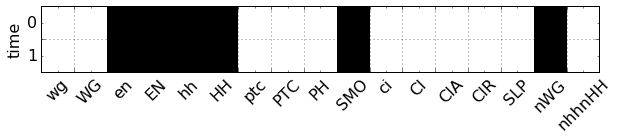

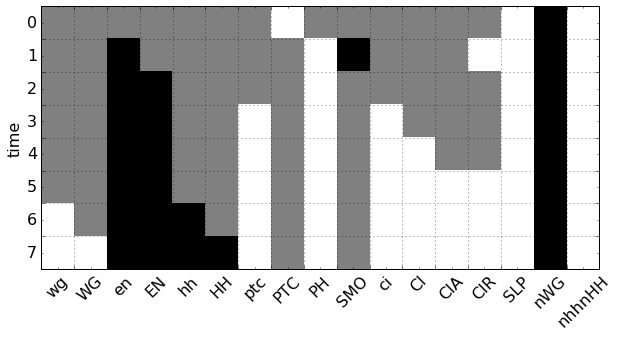

In [70]:
#visualize hard-to-reach attractors
#note that this is the red module except with SLP-0; because nhhnHH=1, there is no way to turn off wg, WG 
#wg,WG is an independent module but this was previously subsumed by CIR-1
nodes=['wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR','SLP','nWG','nhhnHH']
seed=[x for x in attractors['00000001111111010']] #A7
seed=[x for x in attractors['01100001111111010']] #A2
seed=[x for x in attractors['00011110001000001']] #A6
visualize_unfolding(DCM,seed,node_set=nodes,input_type='pulse')
seed=['nWG-0','SLP-0','nhhnHH-1','CIR-1'] #A7
seed=['nWG-0','SLP-0','nhhnHH-1','wg-1'] #A2
seed=['nWG-1','SLP-0','nhhnHH-0','PTC-0'] #A6
visualize_unfolding(DCM,seed,node_set=nodes,input_type='pulse',interference=True)

####Drosophila 4-cell Parasegment (Extended Model)

In [919]:
# Request the DCM to the Network
DM = N2.dynamics_canalization_map(output=None) #simplify=True
# Draws using the graphviz interface.
D2 = draw_dynamics_canalization_map_graphviz(DM, overlap='true')
#display(D2)

150 154 154 154 150 154
set(['T-3_PTC_P4-1', 'T-0_SMO_P2-0', 'T-2_PTC_P2-1', 'T-0_SMO_P4-0']) set([]) set([])


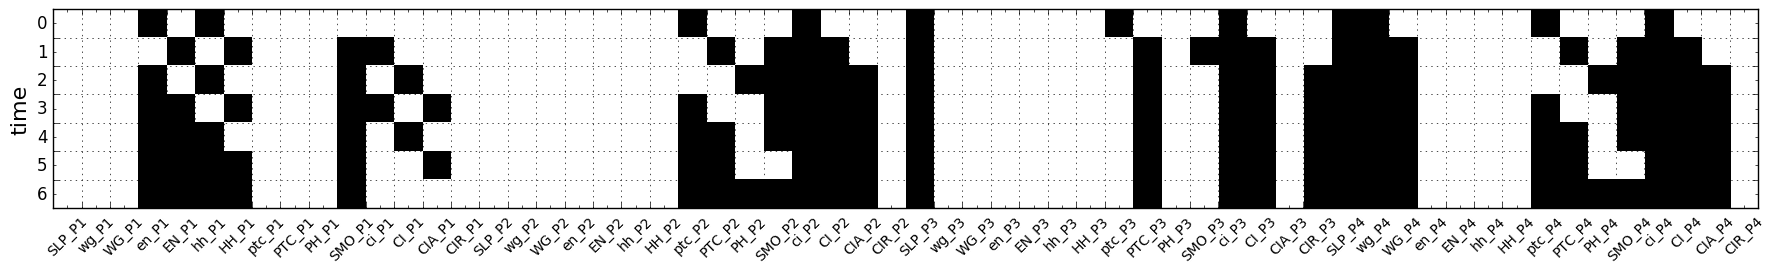

In [1002]:
#visualize unfolding of starting condition (to wildtype attractor)
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
seed=['wg_P4-1','en_P1-1','hh_P1-1','ptc_P2-1','ptc_P3-1','ptc_P4-1','ci_P2-1','ci_P3-1','ci_P4-1',
      'SLP_P1-0','SLP_P2-0','SLP_P3-1','SLP_P4-1']
seen_nodes={s[:-2] for s in seed}
for node in nodes:
    if node not in seen_nodes: seed.append(node+'-0')
#print seed    
#check time limit; it seems it's converging past time_limit=1?
#answer that only threshold nodes are being added (since all variables seen); at three time steps, no new nodes added
#time limit set to stop from limit cycles, cannot determine if program will halt a priori, must experiment with time limit
T2=create_threshold_network(DM)
lengths={}
for t in [1,2,3,4]:
    unfolding = BFS_threshold(T2, seed, 'pulse', time_limit=t, conversion=False)
    #lengths[t]=unfolding[max(unfolding)]
    lengths[t]={element for t in unfolding for element in unfolding[t]}
#print max(unfolding), len(sorted(unfolding[max(unfolding)])), #T2.nodes()
print len(lengths[1]),len(lengths[2]),len(lengths[3]),len(lengths[4]),
print len(lengths[1].intersection(lengths[2]).intersection(lengths[3]).intersection(lengths[4])),
print len(lengths[1].union(lengths[2]).union(lengths[3]).union(lengths[4]))
print lengths[2]-lengths[1], lengths[3]-lengths[2], lengths[4]-lengths[3]
unfolding = BFS_threshold(T2, seed, 'pulse', time_limit=3, conversion=False)
#print unfolding[max(unfolding)] - unfolding[max(unfolding)-1]
fig,ax=visualize_unfolding(DM,seed,node_set=nodes,input_type='pulse',time_limit=3,figsize=(22,10))
ax.yaxis.label.set_fontsize(16)
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
for tick in ax.yaxis.get_minor_ticks():
    tick.label.set_fontsize(12)

In [1384]:
#define dynamic modules for drosophila parasegment
blue_module={'SLP-0','nWG-1','en-1','EN-1','ptc-0','ci-0','CI-0','CIR-0','hh-1','HH-1','CIA-0','wg-0','WG-0',
            'T-2_en-1','T-0_CIR-0','T-2_hh-1','T-0_ptc-0','T-0_wg-0','F-T0','F-T1','F-T3'}
pink_module={'SLP-1','nWG-0','en-0','EN-0','ci-1','CI-1','hh-0','HH-0'}
green_module={'nhhnHH-1','SMO-1','CIR-0'}
orange_module={'nhhnHH-0','PH-0','T-0_PH-0','F-T2'}
extended_blue=blue_module.union(green_module).union({'PTC-0','PH-0','T-1_PTC-0','T-0_PTC-0','T-0_PH-0','F-T2'})
extended_pink=pink_module.union(green_module).union({'CIA-1','wg-1','WG-1','ptc-1','PTC-1','PH-1',
                                                    'T-1_PH-1','T-2_ptc-1','T-2_wg-1','T-3_CIA-1','F-T4'})
alternate_red=pink_module.union({'PTC-0','CIR-0','SMO-1','PH-0','CIA-1','wg-1','WG-1','ptc-1',#'nhhnHH-1','ptc-0',
                                'T-0_PH-0','T-2_ptc-1','T-2_wg-1','T-2_CIA-1','T-0_CIR-0','F-T1','F-T2','F-T4'})
brown_module=orange_module.union({'ptc-1','PTC-1','SMO-0','CIA-0','T-0_SMO-0','T-3_PTC-1','T-0_CIA-0'}) #'ptc-0'
color_set={'blue':'dodgerblue','pink':'salmon','green':'green','orange':'orange',
        'dark-blue':'darkslateblue','red':'crimson','alt-red':'orangered','brown':'sienna'}
color_to_module={'blue':blue_module, 'pink':pink_module, 'green':green_module, 'orange':orange_module,
                'dark-blue':extended_blue, 'red':extended_pink, 'alt-red':alternate_red, 'brown':brown_module}

['SLP-0', 'wg-0', 'WG-0', 'en-1', 'EN-1', 'hh-1', 'HH-1', 'ptc-0', 'PTC-0', 'PH-0', 'SMO-1', 'ci-0', 'CI-0', 'CIA-0', 'CIR-0', 'SLP-0', 'wg-0', 'WG-0', 'en-0', 'EN-0', 'hh-0', 'HH-0', 'ptc-1', 'PTC-1', 'PH-1', 'SMO-1', 'ci-1', 'CI-1', 'CIA-1', 'CIR-0', 'SLP-1', 'wg-0', 'WG-0', 'en-0', 'EN-0', 'hh-0', 'HH-0', 'ptc-0', 'PTC-1', 'PH-0', 'SMO-0', 'ci-1', 'CI-1', 'CIA-0', 'CIR-1', 'SLP-1', 'wg-1', 'WG-1', 'en-0', 'EN-0', 'hh-0', 'HH-0', 'ptc-1', 'PTC-1', 'PH-1', 'SMO-1', 'ci-1', 'CI-1', 'CIA-1', 'CIR-0']


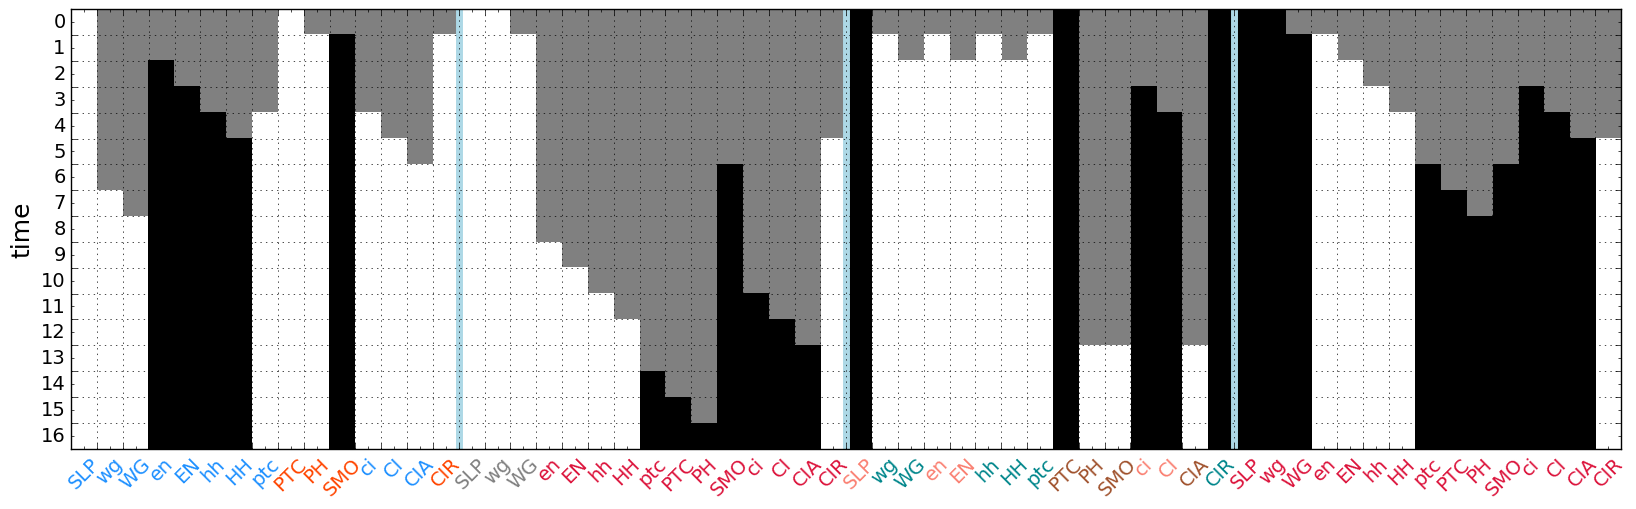

In [1454]:
from matplotlib import colors

node_set=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
seed=['wg_P4-1','en_P1-1','hh_P1-1','ptc_P2-1','ptc_P3-1','ptc_P4-1','ci_P2-1','ci_P3-1','ci_P4-1',
      'SLP_P1-0','SLP_P2-0','SLP_P3-1','SLP_P4-1']
seed=['SLP_P1-0','SLP_P3-0','wg_P2-1']
seed=['SLP_P1-0','SLP_P3-0','SLP_P2-1','PTC_P2-0']
seed=['wg_P1-1', 'en_P1-1', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0','SLP_P4-1'] #minimal attractor
seed=['SLP_P1-0', 'PTC_P1-0', 'SLP_P2-0', 'wg_P2-0', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P3-1',  'SLP_P4-1', 'wg_P4-1'] #wildtype
#seed=['SLP_P4-1', 'PTC_P3-0', 'SLP_P3-1', 'SLP_P1-0', 'en_P1-1', 'SLP_P2-0'] #alternate minimal
input_type='steady'
#seed=list(wildtype['wildtype'])
#wildtype
#seen_nodes={s[:-2] for s in seed}
#for node in nodes:
#    if node not in seen_nodes: seed.append(node+'-0')
#determine pathway
n=create_threshold_network(DM)
unfolding=BFS_threshold(DM,seed,input_type=input_type,time_limit=3,conversion=True)
xvalues=list(node_set)
time=max(unfolding)
grid=[[-1 for x in xvalues] for t in range(time+1)] #use -1 for wildcard value to accomodate multi-state nodes
#visualize unfolding, assumes variable can only be in one state at one time step
for t in range(time+1): #make sure to include time 0 and time t
    vals={n.node[x]['variable']:n.node[x]['state'] for x in unfolding[t] if n.node[x]['type']=='variable'}
    for i,x in enumerate(xvalues):
        if x in vals: 
            grid[t][i]=vals[x]
            #if this is steady_state, assume this condition holds for the rest of time
            if input_type=='steady':
                for t2 in range(t+1,time+1):
                    grid[t2][i]=vals[x]
                    
#get node colors
node_lst=[node.split("_")[0]+'-'+str(grid[-1][i]) for i,node in enumerate(node_set)]
print node_lst
color_lst=[]
modules=['red','alt-red','blue','brown'] #sets preference for color #wildtype
#modules=['red','blue','orange','alt-red'] #other seeds
#modules=['red','dark-blue'] #minimal attractor
for node in node_lst:
    node_color='grey'
    for color in modules:
        if node in color_to_module[color]: 
            node_color=color_set[color]
            break
    color_lst.append(node_color)
#manual modifications 

#wildtype
color_lst[10]=color_set['alt-red'] #should actually be PTC-0
color_lst[14]=color_set['alt-red'] #should actually be PTC-0
color_lst[15]='grey' #color_set['blue']
color_lst[16]='grey' #color_set['blue']
color_lst[17]='grey' #color_set['blue']
color_lst[30]=color_set['pink']
color_lst[31]='#00868B' #color_set['blue']
color_lst[32]='#00868B' #color_set['blue']
color_lst[33]=color_set['pink']
color_lst[34]=color_set['pink']
color_lst[35]='#00868B' #color_set['pink']
color_lst[36]='#00868B' #color_set['pink']
color_lst[37]='#00868B' #color_set['blue']
color_lst[38]=color_set['brown']
color_lst[39]=color_set['brown']
color_lst[40]=color_set['brown']
color_lst[41]=color_set['pink']
color_lst[42]=color_set['pink']
color_lst[43]=color_set['brown']
color_lst[44]='#00868B' 
#'SLP_P1-0','SLP_P3-0','wg_P2-1'
#color_lst[14]=color_set['blue']
#color_lst[44]=color_set['blue']
#'SLP_P1-0','SLP_P3-0','SLP_P2-1','PTC_P2-0'
#for i in range(15,30): color_lst[i]=color_set['alt-red']
#minimal attractor
#color_lst[10]=color_set['dark-blue']
#color_lst[14]=color_set['dark-blue']
#color_lst[25]=color_set['dark-blue']
#color_lst[29]=color_set['dark-blue']
#color_lst[1]='grey'
#color_lst[2]='grey'


cmap = colors.ListedColormap(['grey', 'white', 'black'])
bounds = [-1, 0, 1, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(20,10)) #(20,10)
ax = plt.gca()

ax.set_xticks(np.linspace(-0.5,len(node_set)-1.5,num=len(node_set))) #major ticks used for grid
ax.set_xticks(np.linspace(0,len(node_set)-1,num=len(node_set)),minor=True) #minor ticks used for labeling
ax.set_yticks(np.linspace(-0.5,time-0.5,num=time+1)) #major ticks used for grid
ax.set_yticks(np.linspace(0,time,num=time+1),minor=True) #minor ticks used for labeling
ax.set_xticklabels("")
ax.set_xticklabels([node.split("_")[0] for node in node_set],rotation=45,minor=True,fontsize=14)
ax.set_yticklabels("")
ax.set_yticklabels([t for t in range(time+1)],minor=True, fontsize=14)
plt.axvline(x=14.5, color='lightblue', linewidth=5) #grey, lightblue
plt.axvline(x=29.5, color='lightblue', linewidth=5)
plt.axvline(x=44.5, color='lightblue', linewidth=5)
plt.grid()
#set individual node colors
for i,color in enumerate(color_lst):
    plt.gca().get_xticklabels(minor=True)[i].set_color(color) 
    
plt.ylabel("time", fontsize=18)
grid = plt.imshow(grid, interpolation='nearest', cmap=cmap,norm=norm)
#plt.show()
#plt.savefig('../../Dynamics/drosophila_wildtype_unfolding.pdf',dpi=300,bbox_inches = "tight")
#plt.savefig('../../Dynamics/~.pdf',dpi=300,bbox_inches = "tight")

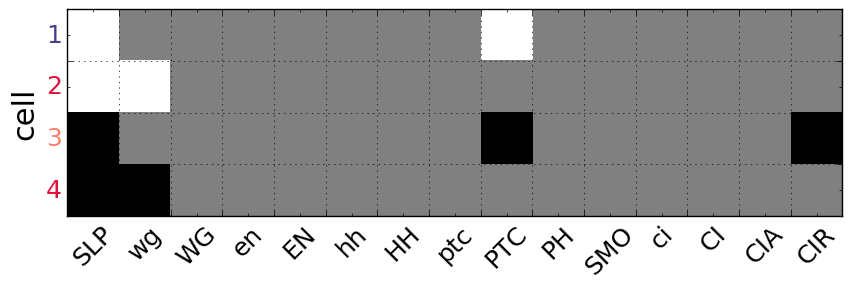

In [1418]:
#minimal schemata for wildtype attractor
xvalues=['SLP','wg','WG','en','EN','hh','HH','ptc','PTC','PH','SMO','ci','CI','CIA','CIR']
rows=['dark-blue','red','pink','red'] #wildtype
#rows=['dark-blue','dark-blue','red','red'] #minimal attractor
cells=4
figsize=(10,10)
grid=[[-1 for x in xvalues] for t in range(cells)] #use -1 for wildcard value to accomodate multi-state nodes
#set values for enputs

grid[0][0]=0 #'SLP_P1-0'
grid[1][0]=0 #'SLP_P2-0'
grid[2][0]=1 #'SLP_P3-1'
grid[3][0]=1 #'SLP_P4-1'
grid[0][8]=0 #'PTC_P1-0'
grid[2][8]=1 #'PTC_P3-1'
grid[1][1]=0 #'wg_P2-0'
grid[3][1]=1 #'wg_P4-1'
grid[2][14]=1 #'CIR_P3-1' 

#minimal attractor
#grid[0][0]=0 #'SLP_P1-0'
#grid[1][0]=0 #'SLP_P2-0'
#grid[2][0]=1 #'SLP_P3-1'
#grid[3][0]=1 #'SLP_P4-1'
#grid[0][1]=1 #'wg_P1-1'
#grid[0][3]=1 #'en_P1-1' '''

cmap = colors.ListedColormap(['grey', 'white', 'black'])
bounds = [-1, 0, 1, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=figsize)
ax = plt.gca()

ax.set_xticks(np.linspace(-0.5,len(xvalues)-1.5,num=len(xvalues))) #major ticks used for grid
ax.set_xticks(np.linspace(0,len(xvalues)-1,num=len(xvalues)),minor=True) #minor ticks used for labeling
ax.set_yticks(np.linspace(-0.5,cells-0.5,num=cells+1)) #major ticks used for grid
ax.set_yticks(np.linspace(0,cells,num=cells+1),minor=True) #minor ticks used for labeling
ax.set_xticklabels("")
ax.set_xticklabels(xvalues,rotation=45,minor=True,fontsize=18)
ax.set_yticklabels("")
ax.set_yticklabels([t+1 for t in range(cells)],minor=True,fontsize=18)
#experiment with highlighting rows
#for i,r in enumerate(rows):
#    plt.axhline(y=-0.48+i, color=color_set[rows[i]], linewidth=2)
#for i,r in enumerate(rows):
#    plt.axhline(y=0.48+i, color=color_set[rows[i]], linewidth=2)
#plt.axvline(x=-0.5,ymin=.5, ymax=.75, color='lightblue', linewidth=5)
for i,color in enumerate(rows):
    plt.gca().get_yticklabels(minor=True)[i].set_color(color_set[color])
plt.grid()
    
plt.ylabel("cell",fontsize=22)
grid = plt.imshow(grid, interpolation='nearest', cmap=cmap,norm=norm)
#plt.show()
#plt.savefig('../../Dynamics/drosophila_extended_wildtype_minimal_schemata.pdf',dpi=300,bbox_inches = "tight")

In [1588]:
#find top modules for the entire parasegment
seeds=[['SLP_P1-1'],['SLP_P1-0'],['SLP_P2-1'],['SLP_P2-0'],['SLP_P3-1'],['SLP_P3-0'],['SLP_P4-1'],['SLP_P4-0']]
seeds=[nmi[key] for key in nmi]
#dcovers,mcovers={},{}
num=4
gci,mci,tmi,nmi=DCM_min_coverage(DM,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==num:
        seed=[s for s in nmi[top]]
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
        print "\tReachable attractors:",int(unfolding_attractors(DM,seed,attractors=wildtype,input_type='steady')[1]*6)
        #print tmi[top]
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
print len(nodes_seen),#nodes_seen,{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['SLP-1', 'PTC-0']"] #extended pink module #"['nhhnHH-1', 'SLP-1']"

Running iteration: 1	
top modules found: 40
Running iteration: 2	
top modules found: 40
Running iteration: 3	
top modules found: 152
Running iteration: 4	
top modules found: 472
['wg_P3-1', 'SLP_P4-0', 'en_P3-1', 'SLP_P2-0'] 	Length: 56 	Reachable attractors: 0
['en_P1-1', 'SLP_P2-0', 'SLP_P4-0', 'wg_P3-1'] 	Length: 56 	Reachable attractors: 0
['wg_P4-1', 'SLP_P3-0', 'en_P2-1', 'SLP_P1-0'] 	Length: 56 	Reachable attractors: 0
['wg_P4-1', 'en_P4-1', 'SLP_P3-0', 'SLP_P1-0'] 	Length: 56 	Reachable attractors: 0
['en_P1-1', 'wg_P1-1', 'SLP_P4-0', 'SLP_P2-0'] 	Length: 56 	Reachable attractors: 0
['wg_P2-1', 'en_P2-1', 'SLP_P1-0', 'SLP_P3-0'] 	Length: 56 	Reachable attractors: 0
['wg_P1-1', 'SLP_P4-0', 'en_P3-1', 'SLP_P2-0'] 	Length: 56 	Reachable attractors: 0
['en_P4-1', 'wg_P2-1', 'SLP_P1-0', 'SLP_P3-0'] 	Length: 56 	Reachable attractors: 0
['SLP_P1-1', 'SLP_P2-0', 'SLP_P4-0', 'wg_P3-1'] 	Length: 55 	Reachable attractors: 0
['wg_P4-1', 'SLP_P3-0', 'SLP_P1-0', 'SLP_P2-1'] 	Length: 55 	Reac

In [1589]:
#find a dynamic cover; use exact argument to get exactly that many modules in the cover
pcovers={}
q=3
nodes=[x for x in DM if DM.node[x]['type']=='variable']
#new_modules=filter_modules(DM,tmi,nmi,wildtype,input_type='steady',time_limit=1,conversion=True)
tmi_bit = {key: tmi[key] for key in tmi if len(nmi[key])<6}
print len(tmi),len(tmi_bit),len(new_modules)
cover,mc = graph_cover(tmi_bit,nodes,q=q,approximate=True,exact=True) #new_modules
#print cover, mc, len(cover[0]), len(cover)
score,max_cover=compare_cover_independence(DM,cover,nmi,attractors=None)
#pcovers[str(q)]=max_cover
#pcovers[str(num)]=max_cover
#dcovers[str(num)]=max_cover
#mcovers[str(num)]=max_cover
print score, len(cover) #,mc
#print cover
#for c in cover:
#    print test_cover_independence(DM,c,nmi)
if max_cover: print test_cover_independence(DM,max_cover,nmi), len(max_cover)
#for x in sorted(max_cover): print x

704 704 15
0.86884469697 1
{"['SLP_P3-0']": 1.0, "['CIA_P1-1']": 1.0, "['ptc_P4-1']": 1.0, "['ptc_P1-1']": 1.0, "['SLP_P2-0']": 1.0, "['SLP_P2-1']": 0.7142857142857143, "['wg_P4-1']": 1.0, "['CIA_P3-1']": 1.0, "['ptc_P2-1']": 1.0, "['SMO_P3-0']": 1.0, "['SMO_P1-0']": 1.0, "['SMO_P4-0']": 1.0, "['PH_P4-1']": 1.0, "['SMO_P2-0']": 1.0, "['CIA_P2-1']": 1.0, "['ptc_P3-1']": 1.0, "['SLP_P1-0']": 1.0, "['wg_P1-1']": 1.0, "['en_P2-1', 'en_P3-1']": 0.6428571428571429, "['CIR_P2-1']": 0.5, "['CIR_P4-1']": 0.16666666666666666, "['CIR_P3-1']": 0.5, "['en_P1-1', 'SLP_P4-0', 'wg_P3-1']": 0.6363636363636364, "['PH_P3-1']": 1.0, "['CIR_P1-1']": 0.5, "['SLP_P1-1']": 0.7142857142857143, "['CIA_P4-1']": 1.0, "['SLP_P3-1']": 0.7142857142857143, "['PH_P2-1']": 1.0, "['PH_P1-1']": 1.0, "['wg_P2-1']": 1.0, "['SLP_P4-1']": 0.7142857142857143} 32


In [1590]:
#analyze cover
lengths=[]
for module in max_cover:
    lengths.append(len({x for t in tmi[module] for x in tmi[module][t]}))
print lengths, np.mean(lengths), max(lengths)

[1, 33, 1, 1, 2, 1, 1, 1, 1, 2, 6, 1, 6, 2, 1, 2, 1, 1, 7, 2, 2, 1, 1, 1, 2, 1, 7, 7, 7, 28, 6, 6] 4.4375 33


In [1325]:
print len(dcovers)

5


[(1, 40), (2, 35), (3, 36), (4, 32), (5, 26), (6, 24)]


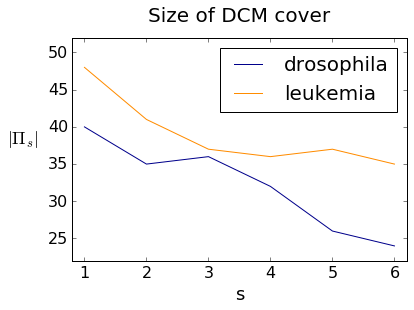

In [608]:
#compare covers across N values and to leukemia (relies on lcovers below)
#NOTE: we have no mcovers because we have to estimate
'''
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
y2values=[]
for i in xvalues:
    yvalues.append(len(dcovers[str(i)]))
    y2values.append(len(lcovers[str(i)]))
yvalues.append(24)
xvalues.append(xvalues[-1]+1)
y2values.append(len(lcovers[str(6)])) #'''

xvalues=[1,2,3,4,5,6]
yvalues=[40,35,36,32,26,24]
y2values=[48,41,37,36,37,35] #[48,41,37,36,37,35] or [48,41,37,35,35,35]
plt.plot(xvalues,yvalues,label='drosophila',color='darkblue')
plt.plot(xvalues,y2values,label='leukemia',color='darkorange')
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel(r'$|\Pi_s|$',fontsize=18,rotation=0,labelpad=25) #plt.ylabel("number of modules",fontsize=18)
plt.title("Size of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.xlim([.8,6.2])
plt.xticks([1,2,3,4,5,6])
plt.ylim([22,52])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/drosophila_parasegment_cover_size2.pdf',dpi=300,bbox_inches = "tight")

[(1, 0.8252747252747252), (2, 0.8292830978545265), (3, 0.8260887260887261), (4, 0.868844696969697), (5, 0.7802446422355925), (6, 0.842709269242)]


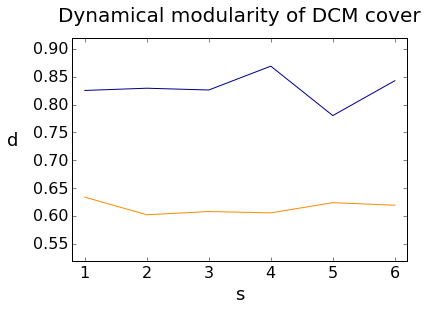

In [604]:
#compare covers across N values and to leukemia (relies on lcovers below)
#print dcovers
'''
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
y2values=[]
for i in xvalues:
    yvalues.append(np.mean([v for k,v in test_cover_independence(DM,dcovers[str(i)],nmi).items()]))
    y2values.append(np.mean([v for k,v in test_cover_independence(DM3,lcovers[str(i)],nml).items()]))
yvalues.append(0.842709269242)
xvalues.append(xvalues[-1]+1)
y2values.append(0.619612863327) #'''

xvalues=[1,2,3,4,5,6]
yvalues=[0.82527472527472523,0.82928309785452647,0.82608872608872608,0.86884469696969702,0.78024464223559253,0.842709269242]
y2values=[.6341,.6025,.6083,.6059,.6242,.6196] #[.6341,.6025,.6083,.6059,.6242,.6196] or [.6341,.6025,.6083,.6196,.6196,.6196]
plt.plot(xvalues,yvalues,label='drosophila',color='darkblue')
plt.plot(xvalues,y2values,label='leukemia',color='darkorange')
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel("d",fontsize=18,rotation=0,labelpad=20) #plt.ylabel("dynamical modularity",fontsize=18)
plt.title("Dynamical modularity of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(fontsize=20)
plt.xlim([.8,6.2])
plt.xticks([1,2,3,4,5,6])
plt.ylim([0.52,0.92])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/drosophila_parasegment_cover_score2.pdf',dpi=300,bbox_inches = "tight")

In [1038]:
print len(tmi.keys())
#define relative indexing operators to condense modules
relative_modules={} #dictionary {relative module: corresponding modules}
all_modules=[] #lists of all sets we've encountered
sizes={} #sizes so that we can sort our relative dictionary
for dmodule in tmi:
    module=nmi[dmodule]
    if module in all_modules: #otherwise add all relative sets
        continue
    indices=[]
    for x in module:
        indices.append(int(x.split("_P")[1].split("-")[0]))
    i=min(indices)
    rel_indices=[x-i for x in indices]
    #nodes=[x.split("_P")[0]+"_I-"+x.split("-")[1] for x in module]
    rel_name=[x.split("-")[0][:-1].replace("_P","_I")+str(rel_indices[i])+"-"+x.split("-")[1] for i,x in enumerate(module)]
    relative_modules.setdefault(str(rel_name),[])
    sizes[str(rel_name)]=len({x for t in tmi[dmodule] for x in tmi[dmodule][t]})
    #find other modules that fit the relative description
    for i in range(4):
        other_indices=[(x+i)%4+1 for x in rel_indices]
        other_name=[x.split("_P")[0]+"_P"+str(other_indices[i])+"-"+x.split("-")[1] for i,x in enumerate(module)]
        if set(other_name) not in all_modules: #may only need to add two say, instead of four
            all_modules.append(set(other_name))
            relative_modules[str(rel_name)].append(str(other_name))
        #print other_indices, other_name
    #print module, rel_indices, rel_name

print len(all_modules), len(relative_modules), relative_modules.keys()

3252
3282 826 ["['en_I0-1', 'en_I1-1', 'SLP_I3-1', 'ptc_I0-1', 'ptc_I1-1']", "['wg_I1-1', 'SLP_I2-1', 'SLP_I0-0', 'en_I1-1', 'ptc_I0-1']", "['en_I0-1', 'CIR_I3-1', 'SLP_I3-1', 'ptc_I0-1', 'CIR_I1-1']", "['SLP_I3-0', 'wg_I0-1', 'SLP_I2-1', 'ptc_I0-1', 'en_I0-1', 'SLP_I1-0']", "['PTC_I2-0', 'SLP_I2-1', 'ptc_I0-1', 'CIR_I0-1', 'SLP_I1-0']", "['SLP_I2-0', 'SLP_I3-1', 'PTC_I3-0', 'CIR_I0-1']", "['SLP_I0-1', 'en_I3-1', 'wg_I1-1', 'SLP_I2-0', 'SLP_I1-0']", "['CIR_I0-1', 'wg_I0-1', 'SLP_I2-1', 'SLP_I0-1', 'ptc_I1-1', 'SLP_I1-0']", "['en_I0-1', 'CIR_I2-1', 'wg_I2-1', 'ptc_I0-1', 'SLP_I3-0']", "['ptc_I3-1', 'SLP_I3-0', 'CIR_I0-1', 'SLP_I2-1', 'SLP_I1-1', 'ptc_I1-1']", "['en_I2-1', 'CIR_I0-1', 'en_I1-1', 'SLP_I0-1', 'en_I3-1', 'ptc_I2-1']", "['en_I0-1', 'SLP_I2-1', 'en_I1-1', 'ptc_I1-1']", "['ptc_I2-1', 'CIR_I0-1', 'SLP_I1-0', 'en_I2-1', 'wg_I0-1', 'SLP_I2-0']", "['wg_I3-1', 'SLP_I2-0', 'SLP_I0-0']", "['ptc_I1-1', 'SLP_I2-1', 'CIR_I0-1', 'en_I1-1']", "['CIR_I2-1', 'ptc_I0-1', 'wg_I2-1', 'en_I0-1'

In [1040]:
#note we assume three extra modules at N=5; not sure why the # of dynamic modules is not divisible by four...
modules=[module for module in relative_modules if len(module.split(","))==6]
print len(modules)
for module in sorted(modules, key=lambda x: sizes[x], reverse=True):
    print module, sizes[module]

378
['SLP_I3-1', 'PTC_I2-0', 'SLP_I2-1', 'SLP_I0-0', 'en_I0-1', 'SLP_I1-0'] 60
['SLP_I3-0', 'SLP_I2-0', 'SLP_I0-0', 'wg_I2-1', 'en_I0-1', 'SLP_I1-1'] 60
['SLP_I3-1', 'en_I2-1', 'SLP_I2-0', 'PTC_I0-0', 'SLP_I0-1', 'SLP_I1-0'] 60
['SLP_I3-1', 'SLP_I2-0', 'SLP_I0-0', 'wg_I2-1', 'en_I0-1', 'SLP_I1-0'] 60
['SLP_I3-0', 'PTC_I2-0', 'SLP_I2-1', 'SLP_I0-0', 'en_I0-1', 'SLP_I1-0'] 60
['SLP_I3-0', 'wg_I0-1', 'SLP_I2-1', 'ptc_I0-1', 'en_I0-1', 'SLP_I1-0'] 59
['SLP_I3-1', 'wg_I0-1', 'SLP_I2-0', 'ptc_I0-1', 'en_I0-1', 'SLP_I1-0'] 59
['ptc_I3-1', 'wg_I3-1', 'SLP_I2-0', 'SLP_I0-1', 'en_I3-1', 'SLP_I1-0'] 59
['SLP_I3-0', 'SLP_I2-1', 'en_I1-1', 'SLP_I0-0', 'ptc_I0-1', 'wg_I1-1'] 59
['SLP_I3-1', 'SLP_I2-0', 'en_I1-1', 'SLP_I0-0', 'ptc_I0-1', 'wg_I1-1'] 59
['SLP_I3-1', 'en_I2-1', 'ptc_I2-1', 'SLP_I0-1', 'wg_I2-1', 'SLP_I1-0'] 59
['SLP_I3-0', 'en_I2-1', 'wg_I0-1', 'SLP_I2-0', 'en_I0-1', 'SLP_I1-0'] 59
['SLP_I3-1', 'SLP_I2-0', 'ptc_I2-1', 'SLP_I0-0', 'ptc_I0-1', 'wg_I1-1'] 59
['SLP_I3-0', 'SLP_I2-0', 'SLP_I

In [1106]:
#use graph cover as a way to estimate minimal control seeds to attractors
pcovers={}
q=2
nodes=wildtype['wildtype']
#print nodes
#new_modules=filter_modules(DM,tmi,nmi,wildtype,input_type='steady',time_limit=1,conversion=True)
#tmi_bit = {key: tmi[key] for key in tmi if len(nmi[key])<5}
print len(tmi),len(tmi_bit),len(new_modules)
cover,mc = graph_cover(tmi,nodes,q=q,approximate=False) #new_modules
#print cover, mc, len(cover[0]), len(cover)
score,max_cover=compare_cover_independence(DM,cover,nmi,attractors=None)
pcovers[str(q)]=max_cover
#pcovers[str(num)]=max_cover
print score, len(cover) ,mc
#print cover
#for c in cover:
#    print test_cover_independence(DM,c,nmi)
if max_cover: print test_cover_independence(DM,max_cover,nmi), len(max_cover)
#for x in sorted(max_cover): print x

3252 704 50
0.939593301435 517 [111, ("['ptc_P3-1', 'SLP_P4-1', 'SLP_P1-1', 'en_P3-1', 'wg_P3-1', 'SLP_P2-0']", "['SLP_P3-1', 'SLP_P1-0', 'SLP_P4-0', 'CIR_P3-1', 'en_P4-1', 'wg_P2-1']")]
[("['ptc_P3-1', 'SLP_P1-0', 'ptc_P1-1', 'SLP_P4-1', 'SLP_P2-1', 'PTC_P2-0']", "['wg_P1-1', 'SLP_P3-1', 'en_P1-1', 'CIR_P3-1', 'ptc_P2-1', 'SLP_P2-0']"), ("['CIR_P3-1', 'SLP_P1-0', 'SLP_P4-0', 'wg_P3-1', 'en_P1-1', 'SLP_P2-0']", "['SLP_P3-1', 'SLP_P4-1', 'ptc_P1-1', 'en_P1-1', 'SLP_P2-1', 'ptc_P3-1']"), ("['CIR_P3-1', 'SLP_P1-0', 'SLP_P4-0', 'wg_P3-1', 'en_P1-1', 'SLP_P2-0']", "['en_P1-1', 'SLP_P3-1', 'SLP_P4-1', 'SLP_P2-1', 'ptc_P3-1']"), ("['SLP_P4-1', 'CIR_P1-1', 'en_P3-1', 'wg_P3-1', 'ptc_P2-1', 'SLP_P2-0']", "['SLP_P3-1', 'ptc_P3-1', 'SLP_P1-0', 'CIR_P2-1', 'wg_P2-1', 'CIR_P4-1']"), ("['SLP_P4-1', 'CIR_P1-1', 'en_P3-1', 'wg_P3-1', 'ptc_P2-1', 'SLP_P2-0']", "['SLP_P3-1', 'ptc_P3-1', 'SLP_P4-1', 'CIR_P2-1', 'SLP_P1-0', 'wg_P2-1']"), ("['SLP_P4-1', 'CIR_P1-1', 'en_P3-1', 'wg_P3-1', 'ptc_P2-1', 'SLP_P2

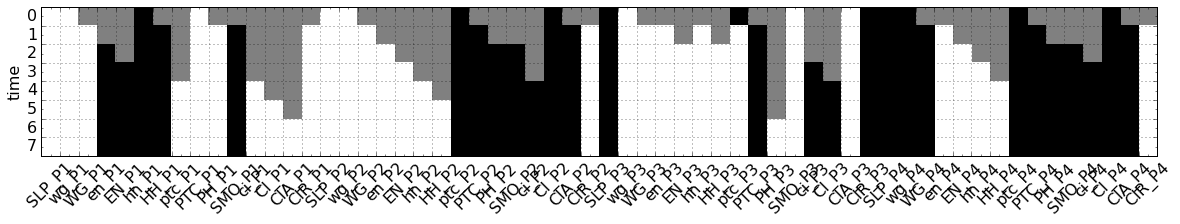

({}, 0.0)


In [1167]:
#visualize longest 3-node module, assuming nodes from above
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
#seed=['wg_P1-1', 'SLP_P4-0', 'SLP_P2-0']
#seed=['CIR_P3-1', 'wg_P2-1', 'SLP_P1-0']
#seed=['en_P1-1', 'SLP_P2-0', 'SLP_P4-0', 'wg_P3-1']
#seed=['SLP_P4-1', 'wg_P2-1', 'SLP_P1-0', 'SLP_P3-0']
#seed=['wg_P1-1', 'ptc_P4-1', 'SLP_P4-0', 'SLP_P2-0'] 
#seed=['SLP_P2-0', 'SLP_P4-0', 'CIR_P1-1', 'wg_P3-1'] 
#seed=['SLP_P1-0', 'SLP_P3-0', 'SLP_P4-1', 'PTC_P4-0'] #notice 3 distinct time epochs
#seed=['wg_P3-1', 'SLP_P4-1', 'SLP_P1-1', 'en_P3-1', 'SLP_P2-0']
#seed=['SLP_P4-1', 'wg_P2-1', 'SLP_P1-0', 'SLP_P3-0', 'ptc_P1-1'] 
#seed=['wg_P4-1', 'en_P4-1', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-1','SLP_P4-1'] 
seed=['SLP_P1-0', 'PTC_P1-0', 'SLP_P2-0', 'wg_P2-0',  'PTC_P3-1', 'CIR_P3-1', 'SLP_P3-1',  'SLP_P4-1', 'wg_P4-1'] #wildtype
#seed=['SLP_P1-0','SLP_P2-0','SLP_P3-1','SLP_P4-1','en_P2-1','PTC_P4-0'] #fully resolves with correct SLP inputs
#seed=['SLP_P1-0','SLP_P2-0','SLP_P3-1','SLP_P4-1','en_P2-1','wg_P2-1'] #fully resolves with correct SLP inputs
seed=['SLP_P1-0', 'PTC_P1-0', 'wg_P2-0', 'SLP_P2-0', 'wg_P3-0', 'SLP_P3-1','PTC_P3-1','SLP_P4-1','wg_P4-1'] #alternative wildtype
seed=['SLP_P1-0','PTC_P1-0','hh_P1-1','wg_P1-0','wg_P2-0','SLP_P2-0','CI_P2-1','ptc_P2-1',
      'wg_P3-0', 'SLP_P3-1','ptc_P3-1','CIA_P3-0','SMO_P3-0','CIR_P3-1','SLP_P4-1','wg_P4-1','ptc_P4-1','CI_P4-1'] #wildtype with pulse
visualize_unfolding(DM,seed,node_set=nodes,input_type='pulse',time_limit=1,figsize=(20,10),interference=False)
print unfolding_attractors(DM,seed,attractors=wildtype,input_type='steady')

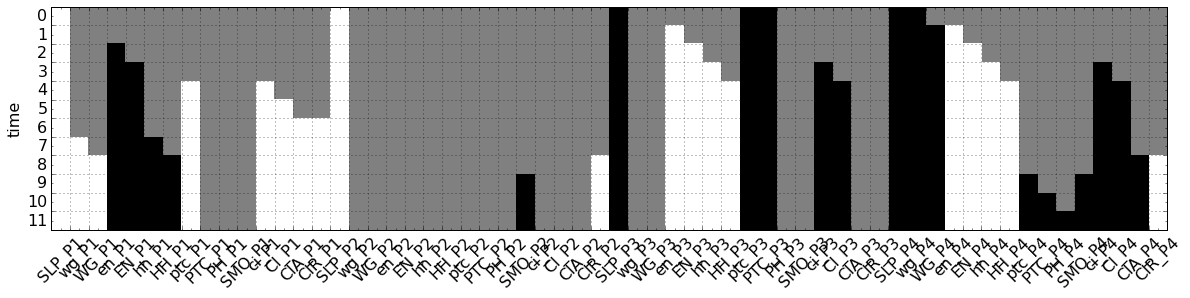

In [148]:
#test attractor rules from Chaves, et al, 2005
seed=['wg_P4-1', 'CIR_P3-1', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0','wg_P2-0','PTC_P1-0','PTC_P3-1','SLP_P4-1']
seed=['wg_P4-1', 'CI_P1-0', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0','ptc_P1-0','SLP_P4-1'] #notice similarity to our minimal bound
seed=['wg_P4-1', 'ci_P1-0', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0','ptc_P1-0','SLP_P4-1','ci_P3-0','ptc_P3-1'] #sufficient?
seed=['wg_P4-1', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0','SLP_P4-1','PTC_P3-1','ptc_P3-1'] #sufficient?
visualize_unfolding(DM,seed,node_set=nodes,input_type='steady',time_limit=1,figsize=(20,10))

In [982]:
#find dynamic modules that lead to the wildtype attractor
#NOTE: when finding minimal control configurations, we don't want to run the independence test!
seeds=[['wg_P4-1', 'CIR_P3-1', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0','wg_P2-0','PTC_P1-0','PTC_P3-1','SLP_P4-1']]
gci,mci,tmi,nmi=DCM_min_coverage(DM,num=1,k=1,input_type='steady',time_limit=1,conversion=True,seeds=seeds,ind_test=False)
#tmi,tm,sizes,nmi=find_dynamic_modules(DCM,input_type='steady',num=3,samples=None,tm=True,seeds=None)
attractor={'wg_P1-0','wg_P2-0','wg_P3-0','wg_P4-1','WG_P1-0','WG_P2-0','WG_P3-0','WG_P4-1','en_P1-1','en_P2-0','en_P3-0','en_P4-0',
          'EN_P1-1','EN_P2-0','EN_P3-0','EN_P4-0','hh_P1-1','hh_P2-0','hh_P3-0','hh_P4-0','HH_P1-1','HH_P2-0','HH_P3-0','HH_P4-0',
          'ptc_P1-0','ptc_P2-1','ptc_P3-0','ptc_P4-1','PTC_P1-0','PTC_P2-1','PTC_P3-1','PTC_P4-1','PH_P1-0','PH_P2-1','PH_P3-0','PH_P4-1',
          'SMO_P1-1','SMO_P2-1','SMO_P3-0','SMO_P4-1','ci_P1-0','ci_P2-1','ci_P3-1','ci_P4-1','CI_P1-0','CI_P2-1','CI_P3-1','CI_P4-1',
          'CIA_P1-0','CIA_P2-1','CIA_P3-0','CIA_P4-1','CIR_P1-0','CIR_P2-0','CIR_P3-1','CIR_P4-0','SLP_P1-0','SLP_P2-0','SLP_P3-1','SLP_P4-1'}
wildtype={'wildtype':attractor}
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    #if len({x for t in tmi[top] for x in tmi[top][t]})==59: 
    #    print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),
    #    nodes_seen={x[:-2] for t in tmi[top] for x in tmi[top][t]}
    #    print {node[:-2] for node in DM.nodes() if DM.node[node]['type']=='variable'}-nodes_seen
    if len(nmi[top])>=0: #nmi[top]
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DM,seed,attractors=wildtype,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if 'wildtype' in reachables[0] and int(reachables[1])==1:
            print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1])
    if len({x for t in tmi[top] for x in tmi[top][t]})<50: break
#print BFS_threshold(DCM,['CIA-1'],'steady',time_limit=1),
#print int(unfolding_attractors(DCM,['CIA-1'],attractors=attractors,input_type='steady')[1]*10)
#print unfolding_attractors(DCM,['SLP-1', 'PTC-0'],attractors=attractors,input_type='pulse')
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})

Running iteration: 1	
top modules found: 1
['wg_P4-1', 'CIR_P3-1', 'SLP_P3-1', 'SLP_P1-0', 'SLP_P2-0', 'wg_P2-0', 'PTC_P1-0', 'PTC_P3-1', 'SLP_P4-1'] 	Length: 60 	Reachable attractors: 1
[0, None]


set(['SMO_P1-1', 'ci_P3-1', 'ci_P2-0', 'SMO_P2-1', 'SMO_P3-1', 'SLP_P3-1', 'PTC_P1-0', 'SLP_P2-0', 'EN_P3-0', 'ptc_P4-1', 'HH_P1-1', 'hh_P2-1', 'en_P2-1', 'SLP_P1-0', 'CIR_P3-0', 'EN_P4-0', 'hh_P3-0', 'CI_P1-0', 'hh_P4-0', 'ci_P4-1', 'PTC_P4-1', 'en_P3-0', 'CIA_P3-1', 'SLP_P4-1', 'SMO_P4-1', 'hh_P1-1', 'PTC_P3-1', 'CIA_P4-1', 'EN_P1-1', 'ci_P1-0', 'PTC_P2-0', 'PH_P1-0', 'PH_P2-0', 'PH_P3-1', 'CIR_P1-0', 'WG_P1-0', 'WG_P3-1', 'HH_P2-1', 'CIR_P2-0', 'CIR_P4-0', 'WG_P4-1', 'EN_P2-1', 'CIA_P1-0', 'en_P1-1', 'HH_P3-0', 'WG_P2-0', 'CIA_P2-0', 'CI_P2-0', 'CI_P3-1', 'CI_P4-1', 'wg_P1-0', 'en_P4-0', 'ptc_P3-1', 'wg_P3-1', 'ptc_P2-0', 'HH_P4-0', 'wg_P4-1', 'PH_P4-1', 'ptc_P1-0', 'wg_P2-0'])


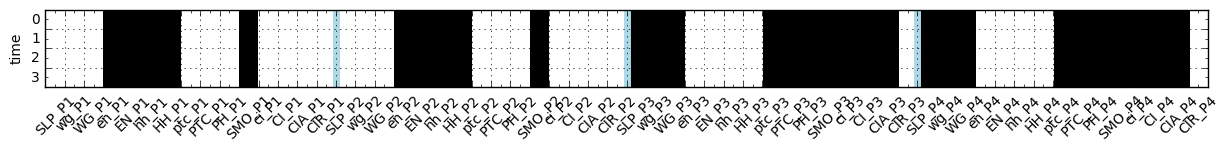

In [1442]:
#find dynamic modules that lead to the broad stripes attractor
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
attractor={'wg_P3-1', 'wg_P4-1', 'WG_P3-1','WG_P4-1', 'en_P1-1', 'en_P2-1', 'EN_P1-1', 'EN_P2-1', 'hh_P1-1', 'hh_P2-1','HH_P1-1', 'HH_P2-1', 
           'ptc_P3-1', 'ptc_P4-1', 'PTC_P3-1', 'PTC_P4-1', 'ci_P3-1', 'ci_P4-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P3-1', 'CIA_P4-1', 'SLP_P3-1', 'SLP_P4-1'}

#add in PH and SMO to find attractors
attractor=attractor.union({'SMO_P1-1', 'SMO_P2-1', 'PH_P3-1', 'SMO_P3-1', 'PH_P4-1', 'SMO_P4-1'})
seen_nodes={s[:-2] for s in attractor}
for node in nodes:
    if node not in seen_nodes: attractor.add(node+'-0')
print attractor    
#TODO: check time limit; it seems it's converging past time_limit=1?
fig,ax=visualize_unfolding(DM,list(attractor),node_set=nodes,input_type='pulse',time_limit=3,figsize=(15,10)) #(22,10)
plt.axvline(x=14.5, color='lightblue', linewidth=5) #grey, lightblue
plt.axvline(x=29.5, color='lightblue', linewidth=5)
plt.axvline(x=44.5, color='lightblue', linewidth=5)
wildtype['broad']=attractor

set(['ci_P2-1', 'SMO_P1-0', 'PH_P1-0', 'ci_P3-1', 'EN_P3-0', 'CIR_P3-1', 'PH_P2-0', 'ci_P4-1', 'SMO_P2-0', 'PH_P3-0', 'CIR_P1-1', 'WG_P1-0', 'HH_P4-0', 'SLP_P3-1', 'PTC_P1-1', 'WG_P3-0', 'SLP_P2-0', 'CIR_P2-1', 'wg_P4-0', 'HH_P1-0', 'CIR_P4-1', 'hh_P2-0', 'en_P2-0', 'PH_P4-0', 'SLP_P1-0', 'HH_P3-0', 'CIA_P1-0', 'EN_P4-0', 'en_P1-0', 'CI_P1-1', 'CIA_P2-0', 'CI_P2-1', 'ptc_P4-0', 'PTC_P4-1', 'CI_P3-1', 'en_P3-0', 'CIA_P3-0', 'hh_P4-0', 'CI_P4-1', 'CIA_P4-0', 'wg_P1-0', 'ptc_P3-0', 'SMO_P3-0', 'wg_P3-0', 'WG_P4-0', 'ptc_P2-0', 'wg_P2-0', 'SLP_P4-1', 'WG_P2-0', 'SMO_P4-0', 'hh_P1-0', 'HH_P2-0', 'EN_P2-0', 'PTC_P3-1', 'ptc_P1-0', 'hh_P3-0', 'en_P4-0', 'EN_P1-0', 'ci_P1-1', 'PTC_P2-1'])


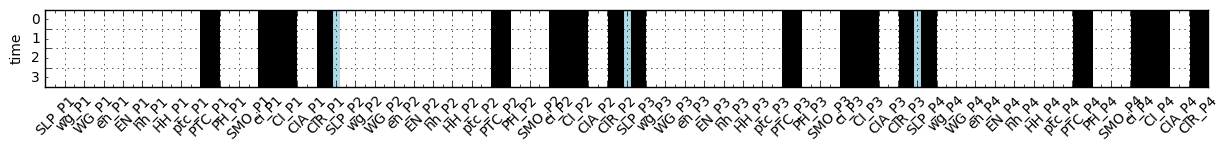

In [1443]:
#find dynamic modules that lead to the no segmentation attractor
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
attractor={'ci_P1-1', 'ci_P2-1', 'ci_P3-1', 'ci_P4-1', 'CI_P1-1', 'CI_P2-1', 'CI_P3-1', 'CI_P4-1', 'PTC_P1-1', 'PTC_P2-1',
           'PTC_P3-1', 'PTC_P4-1', 'CIR_P1-1', 'CIR_P2-1', 'CIR_P3-1', 'CIR_P4-1', 'SLP_P3-1', 'SLP_P4-1'}

#add in PH and SMO to find attractors
#attractor=attractor.union({'SMO_P1-1', 'SMO_P2-1', 'PH_P3-1', 'SMO_P3-1', 'PH_P4-1', 'SMO_P4-1'})
seen_nodes={s[:-2] for s in attractor}
for node in nodes:
    if node not in seen_nodes: attractor.add(node+'-0')
print attractor    
#TODO: check time limit; it seems it's converging past time_limit=1?
visualize_unfolding(DM,list(attractor),node_set=nodes,input_type='pulse',time_limit=3,figsize=(15,10))
plt.axvline(x=14.5, color='lightblue', linewidth=5) #grey, lightblue
plt.axvline(x=29.5, color='lightblue', linewidth=5)
plt.axvline(x=44.5, color='lightblue', linewidth=5)
wildtype['noseg']=attractor

set(['ci_P2-1', 'SMO_P1-0', 'ci_P3-1', 'EN_P3-0', 'SMO_P2-1', 'SMO_P3-0', 'SLP_P3-1', 'PTC_P1-1', 'SLP_P2-0', 'ptc_P4-1', 'HH_P1-1', 'hh_P2-0', 'SLP_P1-0', 'EN_P4-0', 'hh_P3-0', 'CI_P1-0', 'hh_P4-0', 'ci_P4-1', 'PTC_P4-1', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1', 'SMO_P4-1', 'hh_P1-1', 'EN_P2-0', 'PTC_P3-1', 'CIA_P4-1', 'EN_P1-1', 'ci_P1-0', 'PTC_P2-1', 'PH_P1-0', 'CIR_P3-1', 'PH_P3-0', 'CIR_P1-0', 'WG_P1-0', 'WG_P3-0', 'CIR_P2-0', 'PH_P4-1', 'CIR_P4-0', 'WG_P4-1', 'en_P2-0', 'CIA_P1-0', 'en_P1-1', 'HH_P3-0', 'WG_P2-0', 'CIA_P2-1', 'CI_P2-1', 'CI_P3-1', 'CI_P4-1', 'wg_P1-0', 'en_P4-0', 'ptc_P3-0', 'wg_P3-0', 'ptc_P2-1', 'HH_P4-0', 'wg_P4-1', 'HH_P2-0', 'PH_P2-1', 'ptc_P1-0', 'wg_P2-0'])


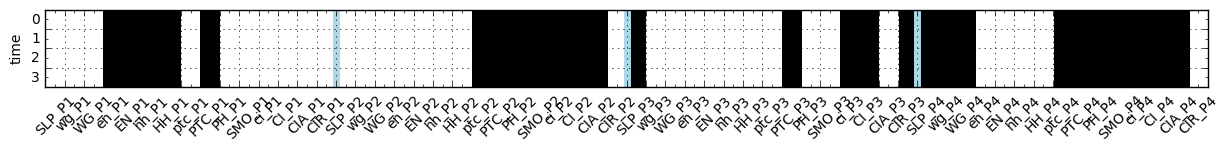

In [1444]:
#find dynamic modules that lead to the wildtype variant attractor
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
attractor={'wg_P4-1', 'WG_P4-1', 'en_P1-1', 'EN_P1-1', 'hh_P1-1', 'HH_P1-1', 'ptc_P2-1', 'ptc_P4-1', 'PTC_P1-1', 'PTC_P2-1', 'PTC_P3-1', 'PTC_P4-1', 
           'ci_P2-1', 'ci_P3-1', 'ci_P4-1', 'CI_P2-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P2-1', 'CIA_P4-1', 'CIR_P3-1', 'SLP_P3-1', 'SLP_P4-1'}

#add in PH and SMO to find attractors
attractor=attractor.union({'PH_P2-1', 'SMO_P2-1', 'PH_P4-1', 'SMO_P4-1'})
seen_nodes={s[:-2] for s in attractor}
for node in nodes:
    if node not in seen_nodes: attractor.add(node+'-0')
print attractor    
#TODO: check time limit; it seems it's converging past time_limit=1?
visualize_unfolding(DM,list(attractor),node_set=nodes,input_type='pulse',time_limit=3,figsize=(15,10))
plt.axvline(x=14.5, color='lightblue', linewidth=5) #grey, lightblue
plt.axvline(x=29.5, color='lightblue', linewidth=5)
plt.axvline(x=44.5, color='lightblue', linewidth=5)
wildtype['wildvar']=attractor

set(['SMO_P1-1', 'ci_P3-1', 'ci_P2-0', 'SMO_P2-1', 'SMO_P3-1', 'SLP_P3-1', 'PTC_P1-1', 'SLP_P2-0', 'ptc_P4-0', 'HH_P1-0', 'EN_P3-0', 'hh_P2-1', 'en_P2-1', 'SLP_P1-0', 'CIR_P3-0', 'EN_P4-0', 'hh_P3-0', 'CI_P1-1', 'ci_P4-1', 'PTC_P4-1', 'en_P3-0', 'CIA_P3-1', 'hh_P4-0', 'SLP_P4-1', 'SMO_P4-0', 'hh_P1-0', 'EN_P2-1', 'CIA_P4-0', 'en_P4-0', 'EN_P1-0', 'ci_P1-1', 'PTC_P2-0', 'PH_P1-1', 'PH_P2-0', 'PH_P3-1', 'CIR_P1-0', 'WG_P1-0', 'WG_P3-1', 'CIR_P2-0', 'CIR_P4-1', 'WG_P4-0', 'PTC_P3-1', 'CIA_P1-1', 'en_P1-0', 'WG_P2-0', 'CIA_P2-0', 'CI_P2-0', 'CI_P3-1', 'CI_P4-1', 'wg_P1-0', 'ptc_P3-1', 'wg_P3-1', 'ptc_P2-0', 'HH_P4-0', 'HH_P2-1', 'wg_P4-0', 'PH_P4-0', 'HH_P3-0', 'ptc_P1-1', 'wg_P2-0'])


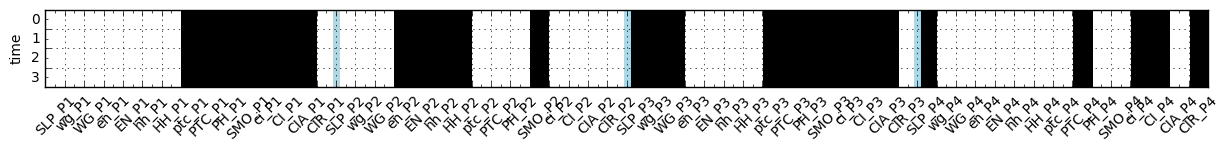

In [1445]:
#find dynamic modules that lead to the ectopic attractor
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
attractor={'wg_P3-1', 'WG_P3-1', 'en_P2-1', 'EN_P2-1', 'hh_P2-1', 'HH_P2-1', 'ptc_P1-1', 'ptc_P3-1', 'PTC_P1-1', 'PTC_P3-1', 'PTC_P4-1',
           'ci_P1-1', 'ci_P3-1', 'ci_P4-1', 'CI_P1-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P1-1', 'CIA_P3-1', 'CIR_P4-1', 'SLP_P3-1', 'SLP_P4-1'}

#add in PH and SMO to find attractors
attractor=attractor.union({'PH_P1-1', 'SMO_P1-1', 'SMO_P2-1', 'PH_P3-1', 'SMO_P3-1'})
seen_nodes={s[:-2] for s in attractor}
for node in nodes:
    if node not in seen_nodes: attractor.add(node+'-0')
print attractor    
#TODO: check time limit; it seems it's converging past time_limit=1?
visualize_unfolding(DM,list(attractor),node_set=nodes,input_type='pulse',time_limit=3,figsize=(15,10))
plt.axvline(x=14.5, color='lightblue', linewidth=5) #grey, lightblue
plt.axvline(x=29.5, color='lightblue', linewidth=5)
plt.axvline(x=44.5, color='lightblue', linewidth=5)
wildtype['ectopic']=attractor

set(['SMO_P1-1', 'ci_P3-1', 'ci_P2-0', 'ci_P4-1', 'SMO_P2-0', 'SMO_P3-1', 'SLP_P3-1', 'PTC_P1-1', 'SLP_P2-0', 'ptc_P4-0', 'HH_P1-0', 'EN_P3-0', 'hh_P2-1', 'en_P2-1', 'SLP_P1-0', 'CIR_P3-0', 'EN_P4-0', 'hh_P3-0', 'CI_P1-1', 'PTC_P4-1', 'en_P3-0', 'CIA_P3-1', 'hh_P4-0', 'SLP_P4-1', 'SMO_P4-0', 'hh_P1-0', 'EN_P2-1', 'CIA_P4-0', 'en_P4-0', 'EN_P1-0', 'ci_P1-1', 'PTC_P2-1', 'PH_P1-1', 'PH_P2-0', 'PH_P3-1', 'CIR_P1-0', 'WG_P1-0', 'WG_P3-1', 'CIR_P2-0', 'CIR_P4-1', 'WG_P4-0', 'PTC_P3-1', 'CIA_P1-1', 'en_P1-0', 'WG_P2-0', 'CIA_P2-0', 'CI_P2-0', 'CI_P3-1', 'CI_P4-1', 'wg_P1-0', 'ptc_P3-1', 'wg_P3-1', 'ptc_P2-0', 'HH_P4-0', 'HH_P2-1', 'wg_P4-0', 'PH_P4-0', 'HH_P3-0', 'ptc_P1-1', 'wg_P2-0'])


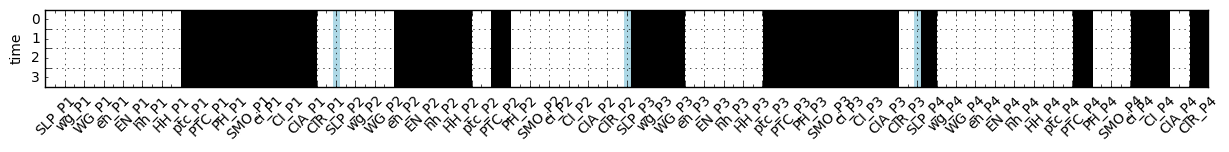

In [1446]:
#find dynamic modules that lead to the ectopic variant attractor
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
attractor={'wg_P3-1', 'WG_P3-1', 'en_P2-1', 'EN_P2-1', 'hh_P2-1', 'HH_P2-1', 'ptc_P1-1', 'ptc_P3-1', 'PTC_P1-1', 'PTC_P2-1', 'PTC_P3-1', 'PTC_P4-1',
           'ci_P1-1', 'ci_P3-1', 'ci_P4-1', 'CI_P1-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P1-1', 'CIA_P3-1', 'CIR_P4-1', 'SLP_P3-1', 'SLP_P4-1'}

#add in PH and SMO to find attractors
attractor=attractor.union({'PH_P1-1', 'SMO_P1-1', 'PH_P3-1', 'SMO_P3-1'})
seen_nodes={s[:-2] for s in attractor}
for node in nodes:
    if node not in seen_nodes: attractor.add(node+'-0')
print attractor    
#TODO: check time limit; it seems it's converging past time_limit=1?
visualize_unfolding(DM,list(attractor),node_set=nodes,input_type='pulse',time_limit=3,figsize=(15,10))
plt.axvline(x=14.5, color='lightblue', linewidth=5) #grey, lightblue
plt.axvline(x=29.5, color='lightblue', linewidth=5)
plt.axvline(x=44.5, color='lightblue', linewidth=5)
wildtype['ectopvar']=attractor

In [208]:
#find all dynamic modules that reach given attractor
#note that reachables gives the fraction of available attractors, multiply by number of attractors to get total possible attractors
gci,mci,tmi,nmi=DCM_min_coverage(DM,num=2,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=False)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])>0: #nmi[top]
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DM,seed,attractors=wildtype,input_type='steady')
        #print seed,reachables,reachables[1]*len(wildtype)
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if 'ectopvar' in reachables[0] and int(reachables[1]*len(wildtype))==1:
            print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*len(wildtype))
    if len({x for t in tmi[top] for x in tmi[top][t]})<0: break

Running iteration: 1	
top modules found: 40
Running iteration: 2	
top modules found: 668
['SMO_P2-0', 'en_P2-1'] 	Length: 14 	Reachable attractors: 1
['SMO_P2-0', 'ptc_P3-1'] 	Length: 3 	Reachable attractors: 1
['SMO_P2-0', 'wg_P3-1'] 	Length: 3 	Reachable attractors: 1
['SMO_P2-0', 'ptc_P1-1'] 	Length: 3 	Reachable attractors: 1
['SMO_P2-0', 'PH_P3-1'] 	Length: 2 	Reachable attractors: 1
['CIA_P3-1', 'SMO_P2-0'] 	Length: 2 	Reachable attractors: 1
['SMO_P2-0', 'PH_P1-1'] 	Length: 2 	Reachable attractors: 1
['SMO_P2-0', 'CIA_P1-1'] 	Length: 2 	Reachable attractors: 1


In [80]:
#compare to FVS
fvs=N2.feedback_vertex_set_driver_nodes(method='bruteforce')
fvs_superset=set([])
for x in fvs:
    #print '\n'
    for node in sorted(x): 
        #print N2.nodes[node]
        fvs_superset.add(node)
print fvs_superset
for node in sorted(fvs_superset):
    print N2.nodes[node]

set([0, 1, 35, 5, 38, 8, 14, 44, 45, 46, 15, 16, 50, 20, 53, 23, 59, 29, 30, 31])
<BNode(name='SLP_P1', k=1, inputs=[SLP_P1], state=0, outputs='[0,1]' constant=False)>
<BNode(name='wg_P1', k=4, inputs=[SLP_P1,wg_P1,CIA_P1,CIR_P1], state=0, outputs='[0,0,0,0...1,0,1,0]' constant=False)>
<BNode(name='hh_P1', k=2, inputs=[EN_P1,CIR_P1], state=0, outputs='[0,0,1,0]' constant=False)>
<BNode(name='PTC_P1', k=4, inputs=[ptc_P1,PTC_P1,HH_P2,HH_P4], state=0, outputs='[0,0,0,0...1,1,1,1]' constant=False)>
<BNode(name='CIR_P1', k=6, inputs=[PTC_P1,CI_P1,hh_P2,HH_P2,hh_P4,HH_P4], state=0, outputs='[0,0,0,0...0,0,0,0]' constant=False)>
<BNode(name='SLP_P2', k=1, inputs=[SLP_P2], state=0, outputs='[0,1]' constant=False)>
<BNode(name='wg_P2', k=4, inputs=[SLP_P2,wg_P2,CIA_P2,CIR_P2], state=0, outputs='[0,0,0,0...1,0,1,0]' constant=False)>
<BNode(name='hh_P2', k=2, inputs=[EN_P2,CIR_P2], state=0, outputs='[0,0,1,0]' constant=False)>
<BNode(name='PTC_P2', k=4, inputs=[HH_P1,ptc_P2,PTC_P2,HH_P3], state=

In [82]:
#fvs_superset={N2.nodes[node].name for node in fvs_superset}
fvs_seed=set([])
for node in fvs_superset:
    fvs_seed.add(node+'-0')
    fvs_seed.add(node+'-1')
fvs_seed=[[node] for node in fvs_seed]
print sorted(fvs_seed)

[['CIR_P1-0'], ['CIR_P1-1'], ['CIR_P2-0'], ['CIR_P2-1'], ['CIR_P3-0'], ['CIR_P3-1'], ['CIR_P4-0'], ['CIR_P4-1'], ['PTC_P1-0'], ['PTC_P1-1'], ['PTC_P2-0'], ['PTC_P2-1'], ['PTC_P3-0'], ['PTC_P3-1'], ['PTC_P4-0'], ['PTC_P4-1'], ['SLP_P1-0'], ['SLP_P1-1'], ['SLP_P2-0'], ['SLP_P2-1'], ['SLP_P3-0'], ['SLP_P3-1'], ['SLP_P4-0'], ['SLP_P4-1'], ['hh_P1-0'], ['hh_P1-1'], ['hh_P2-0'], ['hh_P2-1'], ['hh_P3-0'], ['hh_P3-1'], ['hh_P4-0'], ['hh_P4-1'], ['wg_P1-0'], ['wg_P1-1'], ['wg_P2-0'], ['wg_P2-1'], ['wg_P3-0'], ['wg_P3-1'], ['wg_P4-0'], ['wg_P4-1']]


In [85]:
#use FVS nodes to estimate minimal configurations to biological attractors
#note this is still to large to find controllability, only observability can be derived efficiently
length=len(wildtype)
nlength=60
lengths=[] #hold minimal configuration lengths
drivers=set([])
input_type='steady'
num=3
set_type='observe' #set type should be 'observe' or 'control', depending on how we want to analyze the network
gci,mci,tmi,nmi=DCM_min_coverage(DM,num=num,k=0,input_type=input_type,time_limit=1,conversion=True,seeds=fvs_seed,ind_test=False)
#for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
for attractor in wildtype:
    print attractor
    found=False
    for top in sorted(tmi, key=lambda x: len(nmi[x])): #start with smallest seeds to find minimal seed length
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DM,seed,attractors=wildtype,input_type=input_type)
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*length)==1:
            l=len({x for t in tmi[top] for x in tmi[top][t]})
            if set_type=='control' and l<nlength:
                continue #observable but not controlable
            print top,"\tLength:",l,#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*length)
            found=True #minimal driver set found
            lengths.append(len(nmi[top]))
            drivers=drivers.union(nmi[top])
            break
    if not found: print "No configuration to attractor found!", attractor
        
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

Running iteration: 1	
top modules found: 28
Running iteration: 2	
top modules found: 322
Running iteration: 3	
top modules found: 1984
wildvar
['hh_P1-1', 'PTC_P1-1'] 	Length: 7 	Reachable attractors: 1
broad
['hh_P2-1', 'hh_P1-1'] 	Length: 12 	Reachable attractors: 1
ectopvar
['PTC_P2-1', 'wg_P3-1'] 	Length: 3 	Reachable attractors: 1
ectopic
['PTC_P2-0', 'CIR_P4-1'] 	Length: 10 	Reachable attractors: 1
noseg
['CIR_P1-1'] 	Length: 6 	Reachable attractors: 1
wildtype
['PTC_P1-0', 'PTC_P2-1'] 	Length: 5 	Reachable attractors: 1
6 1.83333333333 2 1
set(['hh_P1-1', 'CIR_P1-1', 'CIR_P4-1', 'hh_P2-1', 'PTC_P1-0', 'PTC_P1-1', 'wg_P3-1', 'PTC_P2-1', 'PTC_P2-0'])


####Yeast

In [1135]:
# Request the DCM to the Network
DMY = NY.dynamics_canalization_map(output=None) #simplify=True
# Draws using the graphviz interface.
#D = draw_dynamics_canalization_map_graphviz(DMY, overlap='true')
#display(D)

In [1136]:
#find attractors of yeast
attractors_yeast=attractors_to_dict(NY)
for attractor in attractors_yeast: print attractor

000001010000
111110001111
111110101111
000000000000
111010001111
001010000000
000101010000
110100101111
000101000000
000000010000
000001000000


In [1571]:
#find dynamic modules of yeast
#seeds=[['SLP-1'],['SLP-0'],['nWG-1'],['nWG-0'],['nhhnHH-1'],['nhhnHH-0']]
print "Size of network: ",len(NY.nodes),len(attractors_yeast),"attractors"
#dcovers,mcovers={},{}
alength=len(attractors_yeast)
num=1
gci,mci,tmi,nmi=DCM_min_coverage(DMY,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==num:
        seed=[s for s in nmi[top]]
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
        print "\tReachable attractors:",int(unfolding_attractors(DMY,seed,attractors=attractors_yeast,input_type='steady')[1]*alength)
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
#print nodes_seen,len(nodes_seen),{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['SLP-1', 'PTC-0']"] #extended pink module #"['nhhnHH-1', 'SLP-1']"

Size of network:  12 11 attractors
Running iteration: 1	
top modules found: 17
['Clb1,2-1'] 	Length: 4 	Reachable attractors: 4
['Clb5,6-1'] 	Length: 4 	Reachable attractors: 2
['SBF-1'] 	Length: 2 	Reachable attractors: 4
['SBF-0'] 	Length: 2 	Reachable attractors: 7
['CellSize-0'] 	Length: 2 	Reachable attractors: 7
['CellSize-1'] 	Length: 2 	Reachable attractors: 4
['MBF-0'] 	Length: 1 	Reachable attractors: 6
['Sic1-0'] 	Length: 1 	Reachable attractors: 7
['MBF-1'] 	Length: 1 	Reachable attractors: 5
['Sic1-1'] 	Length: 1 	Reachable attractors: 4
['Cdc20/14-0'] 	Length: 1 	Reachable attractors: 7
['Swi5-0'] 	Length: 1 	Reachable attractors: 7
['Clb1,2-0'] 	Length: 1 	Reachable attractors: 7
['Cdh1-0'] 	Length: 1 	Reachable attractors: 8
['Mcm1/SFF-0'] 	Length: 1 	Reachable attractors: 7
['Cdh1-1'] 	Length: 1 	Reachable attractors: 3
['Clb5,6-0'] 	Length: 1 	Reachable attractors: 9
[2, ("['SBF-1']",)]


In [1570]:
#use greedy heuristic to check for cover
q=7
nodes=[x for x in DMY if DMY.node[x]['type']=='variable']
#new_modules=filter_modules(DCM,tm,nm,attractors,input_type='steady',time_limit=1,conversion=True)
print len(tmi)#,len(new_modules)
cover,mc = graph_cover(tmi,nodes,q=q,approximate=False) #new_modules
#print type(cover),type(cover[0]),cover[0],len(cover[0])
#print cover, mc, len(cover[0]), len(cover)
score,max_cover=compare_cover_independence(DMY,cover,nmi,attractors=None)
#dcovers[str(q)]=max_cover
#dcovers[str(num)]=max_cover
#mcovers[str(num)]=max_cover
print score, len(cover) #,max_cover,
#print cover
#for c in cover:
#    print test_cover_independence(DCM,c,nm)
if max_cover: 
    print test_cover_independence(DMY,max_cover,nmi)
    #analyze cover
    lengths=[]
    for module in max_cover:
        lengths.append(len({x for t in tmi[module] for x in tmi[module][t]}))
    print lengths, np.mean(lengths), max(lengths)

41
0.964285714286 25215
{"['SBF-1']": 1.0, "['Sic1-0']": 1.0, "['Sic1-1', 'CellSize-0', 'Clb1,2-1']": 0.9166666666666666, "['CellSize-1']": 1.0, "['Mcm1/SFF-0', 'Clb5,6-1', 'Clb1,2-0']": 0.8333333333333334, "['MBF-1']": 1.0, "['Cdh1-1']": 1.0}
[2, 1, 2, 12, 1, 6, 1] 3.57142857143 12


In [1188]:
print mcovers

{'1': ("['Clb1,2-1']", "['SBF-1']", "['MBF-0']", "['Sic1-0']", "['MBF-1']", "['SBF-0']", "['Sic1-1']", "['CellSize-0']", "['Cdc20/14-0']", "['Swi5-0']", "['Clb1,2-0']", "['Cdh1-0']", "['CellSize-1']", "['Mcm1/SFF-0']", "['Clb5,6-1']", "['Cdh1-1']", "['Clb5,6-0']"), '3': ("['SBF-1', 'Clb5,6-1', 'Clb1,2-1']", "['CellSize-1', 'Clb5,6-0', 'Clb1,2-0']", "['Sic1-1', 'CellSize-0', 'Clb1,2-1']", "['Cdh1-1']"), '2': ("['Clb5,6-1']", "['Sic1-0']", "['Sic1-1']", "['CellSize-1', 'Clb1,2-0']", "['Cdh1-1']", "['Clb5,6-0', 'Clb1,2-0']", "['CellSize-0', 'Clb1,2-1']"), '4': ("['SBF-1', 'Clb5,6-1', 'Clb1,2-1']", "['CellSize-1', 'Clb5,6-0', 'Clb1,2-0']", "['Sic1-1', 'Mcm1/SFF-0', 'CellSize-0', 'Clb1,2-1']", "['Cdh1-1']")}


[(1, 17), (2, 9), (3, 7), (4, 7)]


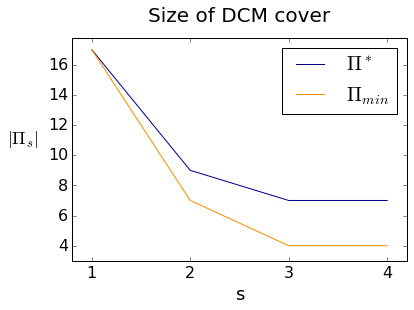

In [584]:
#compare covers across N values
#NOTE: can have x just to 4 to match the other networks because values at x=5 are the same
#print dcovers
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
y2values=[]
for i in xvalues:
    yvalues.append(len(dcovers[str(i)]))
    y2values.append(len(mcovers[str(i)]))
#yvalues.append(yvalues[-1])
#xvalues.append(xvalues[-1]+1)
xvalues=[1,2,3,4]
yvalues=[17,9,7,7]
y2values=[17,7,4,4]

plt.plot(xvalues,yvalues,label=r'$\Pi^*$',color='darkblue') #label=r'max $d$' or r'$\Pi^*_s$'
plt.plot(xvalues,y2values,label=r'$\Pi_{min}$',color='darkorange') #label=r'min $|\Pi_s|$'
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel(r'$|\Pi_s|$',fontsize=18,rotation=0,labelpad=25) #plt.ylabel("number of modules",fontsize=18)
plt.title("Size of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.xlim([.8,4.2])
plt.xticks([1,2,3,4])
plt.ylim([3,17.8])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/yeast_cover_size2.pdf',dpi=300,bbox_inches = "tight")

[(1, 0.911764705882), (2, 0.927513227513), (3, 0.964285714286), (4, 1.0)]


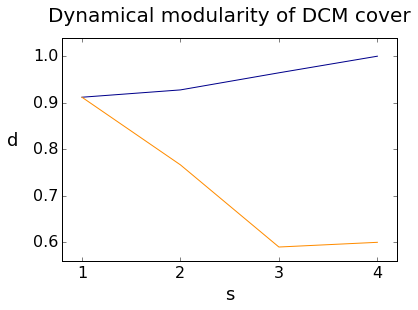

In [588]:
#compare covers across N values
#print dcovers
#xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
#y2values=[]
#for i in xvalues:
#    yvalues.append(np.mean([v for k,v in test_cover_independence(DMY,dcovers[str(i)],nmi).items()]))
#    y2values.append(np.mean([v for k,v in test_cover_independence(DMY,mcovers[str(i)],nmi).items()]))
#yvalues.append(yvalues[-1])
#xvalues.append(xvalues[-1]+1)
#y2values.append(y2values[-1])
xvalues=[1,2,3,4]
yvalues=[0.911764705882, 0.927513227513, 0.964285714286, 1.0]
y2values=[0.911764705882, 0.766326530612, 0.589646464646, 0.599747474747]

plt.plot(xvalues,yvalues,label=r'$\Pi^*$',color='darkblue') #label=r'max $d$' or r'$\Pi^*_s$'
plt.plot(xvalues,y2values,label=r'$\Pi_{min}$',color='darkorange') #label=r'min $|\Pi_s|$'
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel("d",fontsize=18,rotation=0,labelpad=20) #plt.ylabel("dynamical modularity",fontsize=18)
plt.title("Dynamical modularity of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(fontsize=20)
plt.xlim([.8,4.2])
plt.xticks([1,2,3,4])
plt.ylim([0.56,1.04])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/yeast_cover_score2.pdf',dpi=300,bbox_inches = "tight")

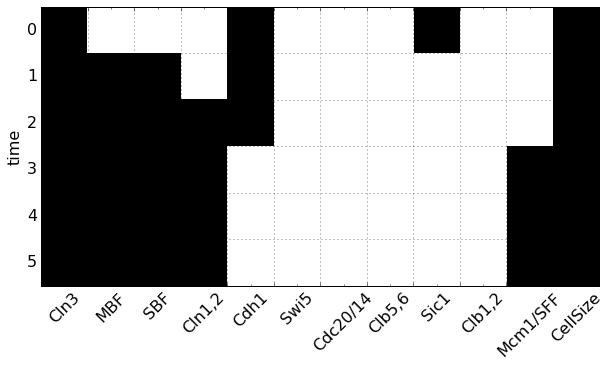

In [1384]:
#visualize unfolding for yeast modules
nodes=['Cln3','MBF','SBF','Cln1,2','Cdh1','Swi5','Cdc20/14','Clb5,6','Sic1','Clb1,2','Mcm1/SFF','CellSize']
#seed=['Sic1-1', 'Mcm1/SFF-0', 'CellSize-0', 'Clb1,2-1']
#seed=['Clb1,2-0', 'CellSize-1', 'Clb5,6-0']
#seed=['CellSize-0', 'SBF-1', 'Clb1,2-1', 'Clb5,6-1']
#seed=['CellSize-1'] #starting 'signal', only resolves one other node
#TODO: figure out why this unfolding is different from the biological pathway in the paper
seed=['Cln3-1','Cdh1-1','Sic1-1','CellSize-1','Cdc20/14-0','Cln1,2-0','Clb1,2-0','MBF-0',
     'Swi5-0','Clb5,6-0','Mcm1/SFF-0','SBF-0'] #starting configuration for biological pathway
visualize_unfolding(DMY,seed,node_set=nodes,input_type='pulse',time_limit=1)

In [1322]:
#analyze controllability
length=len(attractors_yeast)
nlength=12
lengths=[] #hold minimal configuration lengths
drivers=set([])
input_type='steady'
num=7
set_type='control' #set type should be 'observe' or 'control', depending on how we want to analyze the network
gci,mci,tmi,nmi=DCM_min_coverage(DMY,num=num,k=0,input_type='steady',time_limit=1,conversion=True,seeds=None,
                                 ind_test=False,tops=True)
#for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
for attractor in attractors_yeast:
    found=False
    for top in sorted(tmi, key=lambda x: len(nmi[x])): #start with smallest seeds to find minimal seed length
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DMY,seed,attractors=attractors_yeast,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*length)==1:
            l=len({x for t in tmi[top] for x in tmi[top][t]})
            if set_type=='control' and l<nlength:
                continue #observable but not controlable
            print top,"\tLength:",l,#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*length)
            found=True #minimal driver set found
            lengths.append(len(nmi[top]))
            drivers=drivers.union(nmi[top])
            break
    if not found: print "No configuration to attractor found!", attractor
        
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

Running iteration: 1	
top modules found: 17
Running iteration: 2	
top modules found: 97
Running iteration: 3	
top modules found: 266
Running iteration: 4	
top modules found: 429
Running iteration: 5	
top modules found: 472
Running iteration: 6	
top modules found: 427
Running iteration: 7	
top modules found: 312
['CellSize-0', 'MBF-0', 'Sic1-1', 'Clb1,2-0', 'Clb5,6-0', 'Cdh1-1', 'SBF-0'] 	Length: 12 	Reachable attractors: 1
['CellSize-1', 'Clb1,2-1', 'MBF-1', 'Clb5,6-0', 'Sic1-0', 'SBF-1'] 	Length: 12 	Reachable attractors: 1
['Clb5,6-1', 'CellSize-1', 'SBF-1', 'MBF-1', 'Clb1,2-1'] 	Length: 12 	Reachable attractors: 1
['CellSize-0', 'MBF-0', 'Sic1-0', 'Clb1,2-0', 'Clb5,6-0', 'SBF-0', 'Cdh1-0'] 	Length: 12 	Reachable attractors: 1
['CellSize-1', 'Clb1,2-1', 'Clb5,6-0', 'Sic1-0', 'MBF-0', 'SBF-1'] 	Length: 12 	Reachable attractors: 1
['CellSize-0', 'Clb5,6-0', 'Sic1-0', 'Clb1,2-0', 'MBF-0', 'SBF-1'] 	Length: 12 	Reachable attractors: 1
['CellSize-0', 'MBF-1', 'Clb1,2-0', 'Sic1-1', 'Clb5,6

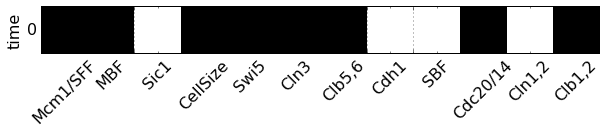

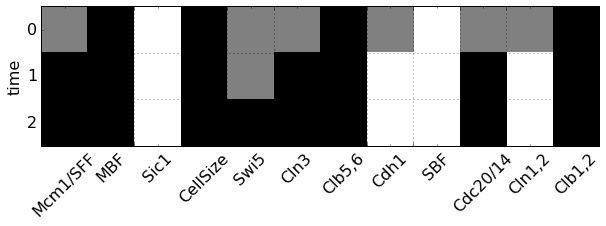

In [1288]:
#analyze the attractor that we cannot control to
seed=[x for x in attractors_yeast['110100101111']]
visualize_unfolding(DMY,seed,node_set=None,input_type='steady',time_limit=1)
seed=['SBF-0', 'Clb5,6-1', 'MBF-1', 'Sic1-0', 'CellSize-1', 'Clb1,2-1'] #observability driver set
visualize_unfolding(DMY,seed,node_set=None,input_type='steady',time_limit=1)

In [1325]:
#lengths.append(6)
drivers=drivers.union({'SBF-0', 'Clb5,6-1', 'MBF-1', 'Sic1-0', 'CellSize-1', 'Clb1,2-1'})
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

11 6.45454545455 7 5
set(['Clb1,2-1', 'Sic1-1', 'Sic1-0', 'Clb1,2-0', 'SBF-1', 'SBF-0', 'CellSize-0', 'CellSize-1', 'Clb5,6-1', 'MBF-1', 'Clb5,6-0', 'Cdh1-1', 'Cdh1-0', 'MBF-0'])


In [1326]:
for module in tmi:
    if nmi[module] > {'SBF-0', 'Clb5,6-1', 'MBF-1', 'Sic1-0', 'CellSize-1', 'Clb1,2-1'}:
        print module#, tmi[module]

['MBF-1', 'CellSize-1', 'Clb1,2-1', 'Clb5,6-1', 'Sic1-0', 'Cdh1-1', 'SBF-0']


In [19]:
#compare to FVS
fvs=NY.feedback_vertex_set_driver_nodes() #method='bruteforce'
for x in fvs:
    for node in sorted(x): 
        print NY.nodes[node]

<BNode(name='CellSize', k=1, inputs=[CellSize], state=0, outputs='[0,1]' constant=False)>
<BNode(name='SBF', k=3, inputs=[Cln3,SBF,Clb1,2], state=0, outputs='[0,0,1,0,1,0,1,1]' constant=False)>
<BNode(name='MBF', k=3, inputs=[Cln3,MBF,Clb1,2], state=0, outputs='[0,0,1,0,1,0,1,1]' constant=False)>
<BNode(name='Sic1', k=6, inputs=[Cln1,2,Sic1,Clb5,6,Clb1,2,Cdc20/14,Swi5], state=0, outputs='[0,1,1,1...0,0,0,0]' constant=False)>
<BNode(name='Clb5,6', k=4, inputs=[MBF,Sic1,Clb5,6,Cdc20/14], state=0, outputs='[0,0,1,0...0,0,1,0]' constant=False)>
<BNode(name='Cdh1', k=5, inputs=[Cln1,2,Clb5,6,Cdh1,Clb1,2,Cdc20/14], state=0, outputs='[0,1,0,0...0,0,0,0]' constant=False)>
<BNode(name='Clb1,2', k=6, inputs=[Sic1,Clb5,6,Cdh1,Clb1,2,Mcm1/SFF,Cdc20/14], state=0, outputs='[0,0,1,0...0,0,1,0]' constant=False)>
<BNode(name='Swi5', k=4, inputs=[Clb1,2,Mcm1/SFF,Cdc20/14,Swi5], state=0, outputs='[0,0,1,1...0,0,1,1]' constant=False)>


####Thaliana

In [1200]:
# Request the DCM to the Network
DMT = NT.dynamics_canalization_map(output=None) #simplify=True
# Draws using the graphviz interface.
D = draw_dynamics_canalization_map_graphviz(DMT, overlap='true')
#display(D)

In [1201]:
#find attractors of thaliana
attractors_thaliana=attractors_to_dict(NT)
for attractor in attractors_thaliana: print attractor

000110110011001
100110110011011
101100110111011
010001000011100
111100110111011
010001001011100
000001001011100
001100110111011
110110110011011
000001000011100


In [1554]:
#modules of the input combinations
#seeds=[['SLP-1'],['SLP-0'],['nWG-1'],['nWG-0'],['nhhnHH-1'],['nhhnHH-0']]
print "Size of network: ",len(NT.nodes),len(attractors_thaliana),"attractors"
#dcovers,mcovers={},{}
num=2
gci,mci,tmi,nmi=DCM_min_coverage(DMT,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==num:
        seed=[s for s in nmi[top]]
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]}),#[x for t in tmi[top] for x in tmi[top][t]]
        print "\tReachable attractors:",int(unfolding_attractors(DMT,seed,attractors=attractors_thaliana,input_type='steady')[1]*10)
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
#print nodes_seen,len(nodes_seen),{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['SLP-1', 'PTC-0']"] #extended pink module #"['nhhnHH-1', 'SLP-1']"

Size of network:  15 10 attractors
Running iteration: 1	
top modules found: 16
Running iteration: 2	
top modules found: 7
['AP1-1', 'LUG-0'] 	Length: 12 	Reachable attractors: 0
['AP1-1', 'CLF-0'] 	Length: 12 	Reachable attractors: 0
['LFY-0', 'AG-1'] 	Length: 11 	Reachable attractors: 0
['AP1-1', 'UFO-1'] 	Length: 11 	Reachable attractors: 1
['WUS-1', 'AP1-1'] 	Length: 11 	Reachable attractors: 0
['AP1-1', 'LFY-0'] 	Length: 11 	Reachable attractors: 0
['LFY-0', 'TFL1-1'] 	Length: 11 	Reachable attractors: 4
[12, ("['AP1-1', 'LUG-0']",)]


(<matplotlib.figure.Figure at 0x3f282550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x3f26c908>)

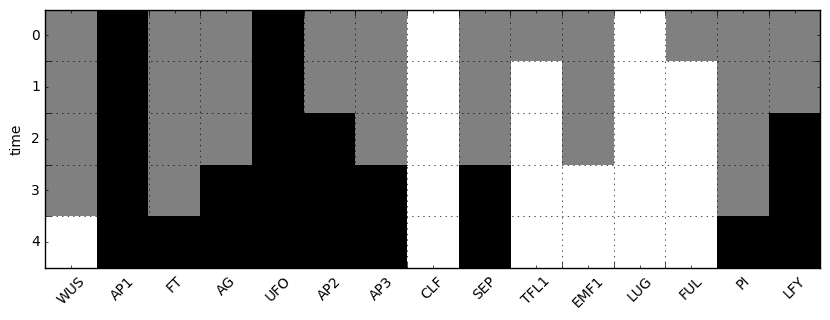

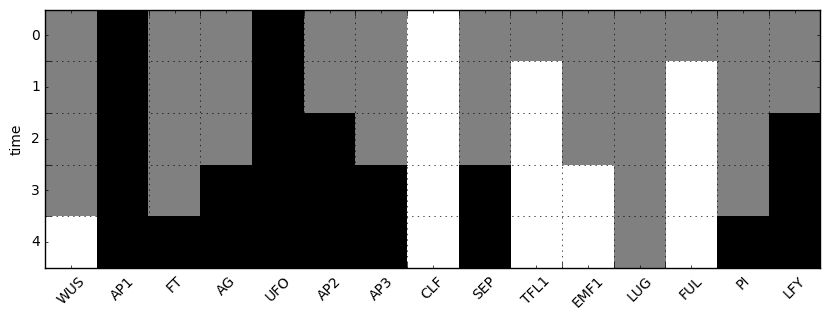

In [1202]:
#visualize unfolding of module we missed
visualize_unfolding(DMT,['CLF-0', 'AP1-1', 'LUG-0', 'UFO-1'])
visualize_unfolding(DMT,['CLF-0', 'AP1-1', 'UFO-1'])

In [1556]:
#use greedy heuristic to check for cover
q=11
nodes=[x for x in DMT if DMT.node[x]['type']=='variable']
#new_modules=filter_modules(DCM,tm,nm,attractors,input_type='steady',time_limit=1,conversion=True)
print len(tmi)#,len(new_modules)
cover,mc = graph_cover(tmi,nodes,q=q,approximate=False) #new_modules
#print type(cover),type(cover[0]),cover[0],len(cover[0])
#print cover, mc, len(cover[0]), len(cover)
score,max_cover=compare_cover_independence(DMT,cover,nmi,attractors=None)
#dcovers[str(q)]=max_cover
#dcovers[str(num)]=max_cover
#mcovers[str(num)]=max_cover
print score, len(cover) #,max_cover,
#print cover
#for c in cover:
#    print test_cover_independence(DCM,c,nm)
if max_cover: 
    print test_cover_independence(DMT,max_cover,nmi)
    #analyze cover
    lengths=[]
    for module in max_cover:
        lengths.append(len({x for t in tmi[module] for x in tmi[module][t]}))
    print lengths, np.mean(lengths), max(lengths)

23
0.98347107438 784
{"['LUG-0']": 1.0, "['CLF-0']": 1.0, "['WUS-1']": 1.0, "['AG-0']": 1.0, "['WUS-0']": 1.0, "['FUL-1']": 1.0, "['LFY-0', 'AG-1']": 0.9090909090909091, "['UFO-0']": 1.0, "['LUG-1']": 1.0, "['CLF-1']": 1.0, "['AP1-1', 'UFO-1']": 0.9090909090909091}
[1, 11, 1, 11, 1, 1, 1, 1, 1, 1, 1] 2.81818181818 11


In [1228]:
print dcovers

{'1': ("['LUG-0']", "['AG-1']", "['LFY-0']", "['TFL1-1']", "['WUS-1']", "['AG-0']", "['FUL-1']", "['WUS-0']", "['UFO-0']", "['AP1-1']", "['LUG-1']", "['PI-1']", "['AP3-1']", "['CLF-1']", "['UFO-1']", "['CLF-0']"), '3': ("['LUG-0']", "['LFY-0', 'AG-1']", "['LUG-1']", "['AP1-1', 'UFO-1']", "['AG-0']", "['CLF-0']", "['CLF-1']", "['WUS-1']", "['FUL-1']", "['WUS-0']", "['UFO-0']"), '2': ("['LUG-0']", "['LFY-0', 'AG-1']", "['LUG-1']", "['AP1-1', 'UFO-1']", "['AG-0']", "['CLF-0']", "['CLF-1']", "['WUS-1']", "['FUL-1']", "['WUS-0']", "['UFO-0']")}


[(1, 16), (2, 11), (3, 11), (4, 11)]


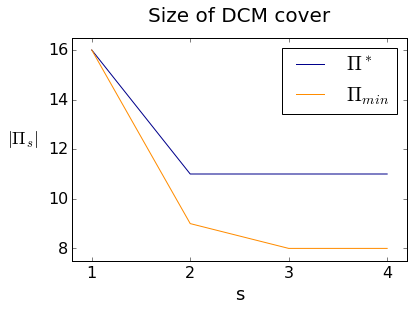

In [593]:
#compare covers across N values
#print dcovers
'''
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
y2values=[]
for i in xvalues:
    yvalues.append(len(dcovers[str(i)]))
    y2values.append(len(mcovers[str(i)]))
yvalues.append(yvalues[-1])
xvalues.append(xvalues[-1]+1)
y2values.append(y2values[-1]) #'''

xvalues=[1,2,3,4]
yvalues=[16,11,11,11]
y2values=[16,9,8,8]
plt.plot(xvalues,yvalues,label=r'$\Pi^*$',color='darkblue') #label=r'max $d$' or r'$\Pi^*_s$'
plt.plot(xvalues,y2values,label=r'$\Pi_{min}$',color='darkorange') #label=r'min $|\Pi_s|$'
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel(r'$|\Pi_s|$',fontsize=18,rotation=0,labelpad=25) #plt.ylabel("number of modules",fontsize=18)
plt.title("Size of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.xlim([.8,4.2])
plt.xticks([1,2,3,4])
plt.ylim([7.5,16.5])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/thaliana_cover_size2.pdf',dpi=300,bbox_inches = "tight")

[(1, 0.9713541666666666), (2, 0.9834710743801653), (3, 0.9834710743801653), (4, 0.9834710743801653)]


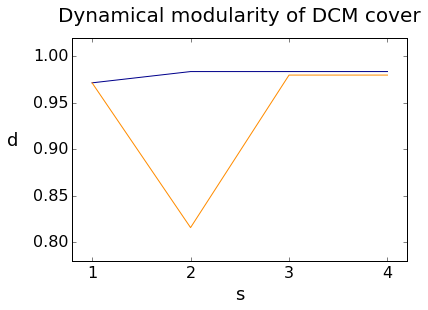

In [600]:
#compare covers across N values
#print dcovers
'''
xvalues,yvalues=sorted([int(i) for i in dcovers if dcovers[i]]),[]
y2values=[]
for i in xvalues:
    yvalues.append(np.mean([v for k,v in test_cover_independence(DMT,dcovers[str(i)],nmi).items()]))
    y2values.append(np.mean([v for k,v in test_cover_independence(DMT,mcovers[str(i)],nmi).items()]))
yvalues.append(yvalues[-1])
xvalues.append(xvalues[-1]+1)
y2values.append(y2values[-1]) #'''

xvalues=[1,2,3,4]
yvalues=[0.97135416666666663,0.98347107438016534,0.98347107438016534,0.98347107438016534]
y2values=[0.97135416666666663,.8157,.9797,.9797]
plt.plot(xvalues,yvalues,label=r'$\Pi^*$',color='darkblue') #label=r'max $d$' or r'$\Pi^*_s$'
plt.plot(xvalues,y2values,label=r'$\Pi_{min}$',color='darkorange') #label=r'min $|\Pi_s|$'
plt.xlabel("s",fontsize=18) #plt.xlabel("max seed size",fontsize=18)
plt.ylabel("d",fontsize=18,rotation=0,labelpad=20)
plt.title("Dynamical modularity of DCM cover",y=1.05,fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(fontsize=20)
plt.xlim([.8,4.2])
plt.xticks([1,2,3,4])
plt.ylim([0.78,1.02])
print zip(xvalues,yvalues)
#plt.savefig('../../Dynamics/thaliana_cover_score2.pdf',dpi=300,bbox_inches = "tight")

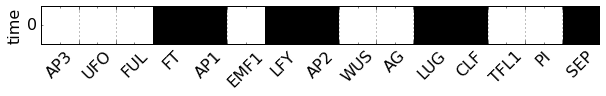

In [104]:
#visualize long modules
nodes=[var.name for var in NT.nodes]
seed=['LFY-0', 'TFL1-1']
seed=['CLF-0', 'AP1-1', 'UFO-1']
seed=[x for x in attractors_thaliana['000110110011001']]
#seed.remove('CLF-1')
#seed.append('CLF-0')
visualize_unfolding(DMT,seed,node_set=nodes,input_type='steady')

In [1437]:
#analyze controllability
length=len(attractors_thaliana)
nlength=15
lengths=[] #hold minimal configuration lengths
drivers=set([])
input_type='steady'
num=9
set_type='control' #set type should be 'observe' or 'control', depending on how we want to analyze the network
gci,mci,tmi,nmi=DCM_min_coverage(DMT,num=num,k=0,input_type='steady',time_limit=1,conversion=True,seeds=fvs_seed,
                                 ind_test=False,tops=False)
#for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
for attractor in attractors_thaliana:
    found=False
    for top in sorted(tmi, key=lambda x: len(nmi[x])): #start with smallest seeds to find minimal seed length
        seed=[s for s in nmi[top]]
        reachables=unfolding_attractors(DMT,seed,attractors=attractors_thaliana,input_type='steady')
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if attractor in reachables[0] and int(reachables[1]*length)==1:
            l=len({x for t in tmi[top] for x in tmi[top][t]})
            if set_type=='control' and l<nlength:
                continue #observable but not controlable
            print top,"\tLength:",l,#[x for t in tmi[top] for x in tmi[top][t]]
            print "\tReachable attractors:",int(reachables[1]*length)
            found=True #minimal driver set found
            lengths.append(len(nmi[top]))
            drivers=drivers.union(nmi[top])
            break
    if not found: print "No configuration to attractor found!", attractor
        
print len(lengths), np.mean(lengths), max(lengths), min(lengths)
print drivers

Running iteration: 1	
top modules found: 18
Running iteration: 2	
top modules found: 176
Running iteration: 3	
top modules found: 1253
Running iteration: 4	
top modules found: 6811
Running iteration: 5	
top modules found: 25707
Running iteration: 6	
top modules found: 28101
Running iteration: 7	
top modules found: 24523
Running iteration: 8	
top modules found: 17903
Running iteration: 9	
top modules found: 3502
['LFY-1', 'UFO-0', 'PI-0', 'LUG-1', 'WUS-0', 'CLF-1', 'AG-0'] 	Length: 15 	Reachable attractors: 1
['LFY-1', 'CLF-1', 'UFO-0', 'AG-0', 'WUS-0', 'LUG-1', 'AP3-1'] 	Length: 15 	Reachable attractors: 1
['LFY-1', 'AG-1', 'UFO-0', 'LUG-1', 'CLF-1', 'AP3-1'] 	Length: 15 	Reachable attractors: 1
['LFY-0', 'CLF-1', 'LUG-1', 'WUS-0', 'UFO-1', 'TFL1-1'] 	Length: 15 	Reachable attractors: 1
['UFO-1', 'LFY-1', 'AG-1', 'CLF-1', 'LUG-1'] 	Length: 15 	Reachable attractors: 1
['LFY-0', 'CLF-1', 'UFO-1', 'WUS-1', 'LUG-1', 'TFL1-1'] 	Length: 15 	Reachable attractors: 1
['LFY-0', 'CLF-1', 'LUG-1',

In [1422]:
#l=lengths
#d=drivers
print l,d

[7, 6, 6, 6, 6] set(['UFO-1', 'LFY-0', 'LUG-1', 'AP1-1', 'TFL1-1', 'UFO-0', 'AG-0', 'WUS-1', 'WUS-0', 'CLF-1'])


In [22]:
#compare to FVS
fvs=NT.feedback_vertex_set_driver_nodes(method='bruteforce') #method='bruteforce'
for x in fvs:
    for node in sorted(x): 
        print NT.nodes[node]

<BNode(name='AP3', k=7, inputs=[AP3,UFO,AP1,LFY,AG,PI,SEP], state=0, outputs='[0,0,0,0...1,1,1,1]' constant=False)>
<BNode(name='UFO', k=1, inputs=[UFO], state=0, outputs='[0,1]' constant=False)>
<BNode(name='LFY', k=4, inputs=[FUL,AP1,EMF1,TFL1], state=0, outputs='[1,1,1,0...1,1,1,0]' constant=False)>
<BNode(name='WUS', k=3, inputs=[WUS,AG,SEP], state=0, outputs='[0,0,0,0,1,1,1,0]' constant=False)>
<BNode(name='AG', k=9, inputs=[AP1,LFY,AP2,WUS,AG,LUG,CLF,TFL1,SEP], state=0, outputs='[1,1,0,0...1,1,1,1]' constant=False)>
<BNode(name='LUG', k=0, inputs=[], state=0, outputs='[1]' constant=True)>
<BNode(name='CLF', k=0, inputs=[], state=0, outputs='[1]' constant=True)>
<BNode(name='TFL1', k=4, inputs=[AP1,EMF1,LFY,AP2], state=0, outputs='[0,0,0,0...0,0,0,0]' constant=False)>
<BNode(name='PI', k=6, inputs=[AP3,AP1,LFY,AG,PI,SEP], state=0, outputs='[0,0,0,0...1,1,1,1]' constant=False)>


In [1425]:
fvs_superset=set([])
for x in fvs:
    for node in sorted(x): 
        fvs_superset.add(node)
fvs_superset={NT.nodes[node].name for node in fvs_superset}
fvs_seed=set([])
for node in fvs_superset:
    fvs_seed.add(node+'-0')
    fvs_seed.add(node+'-1')
fvs_seed=[[node] for node in fvs_seed]
print sorted(fvs_seed)

[['AG-0'], ['AG-1'], ['AP3-0'], ['AP3-1'], ['CLF-0'], ['CLF-1'], ['LFY-0'], ['LFY-1'], ['LUG-0'], ['LUG-1'], ['PI-0'], ['PI-1'], ['TFL1-0'], ['TFL1-1'], ['UFO-0'], ['UFO-1'], ['WUS-0'], ['WUS-1']]


####Leukemia

In [1301]:
#NOTE, original leukemia network is asynchronous, state of Stimuli set to ON
#original paper found IL15 and PDGF sufficient to produce all known signaling abnormalities; test IL15/PDGF/Stimuli
#key mediators PDGF, PDGFR, SPHK1, NFKB, S1P, SOCS, GAP, BID, and IL2RB
DM3 = N3.dynamics_canalization_map(output=None) #simplify=True
D3 = draw_dynamics_canalization_map_graphviz(DM3, overlap='true')
#display(D3)
print N3, len(N3.nodes)

<BNetwork(Name='Leukemia', N=60, Nodes=['CTLA4', 'TCR', 'PDGFR', 'FYN', 'Cytoskeleton_signaling', 'LCK', 'ZAP70', 'GRB2', 'PLCG1', 'RAS', 'GAP', 'MEK', 'ERK', 'PI3K', 'NFKB', 'NFAT', 'RANTES', 'IL2', 'IL2RBT', 'IL2RB', 'IL2RAT', 'IL2RA', 'JAK', 'SOCS', 'STAT3', 'P27', 'Proliferation', 'TBET', 'CREB', 'IFNGT', 'IFNG', 'P2', 'GZMB', 'TPL2', 'TNF', 'TRADD', 'FasL', 'FasT', 'Fas', 'sFas', 'Ceramide', 'DISC', 'Caspase', 'FLIP', 'A20', 'BID', 'IAP', 'BclxL', 'MCL1', 'Apoptosis', 'GPCR', 'SMAD', 'SPHK1', 'S1P', 'PDGF', 'IL15', 'Stimuli', 'Stimuli2', 'CD45', 'TAX'])> 60


In [56]:
#record all dynamic modules of one starting node
num=3 #numbers 4+ are no longer instantaneous for drosophila, 3+ for leukemia takes a long time, don't print more than a few
input_type='steady'
nu,tm,sizes=find_dynamic_modules(DM3,input_type=input_type,num=num,samples=None)

if num==1: #visualize top modules
    for node in sorted(tm,key=lambda x:sizes[x],reverse=True): 
        print node,[x for t in tm[node] for x in tm[node][t]] #tm[node]
        #print node,len({x for t in nu[node] for x in nu[node][t]})
        
    node_contributions={node:(sizes[node],1) for node in sizes}

else: #visualize number of node states discovered, may be repeats if input_type=pulse
    
    #determine how much each single node contributes, tuple indexed (total states reached, number of pathways)
    node_contributions = {node:[0,0] for node in DM3.nodes() if DM3.node[node]['type']=='variable'} 
    #alternative for pulse
    if input_type=='pulse':
        node_sets={node:{x for t in nu[node] for x in nu[node][t]} for node in nu}
        for node in sorted(node_sets,key=lambda x:len(node_sets[x]),reverse=True):
            #print node,len(node_sets[node])
            for key in node_contributions:
                if key in node:
                    node_contributions[key][0]+=len(node_sets[node])
                    node_contributions[key][1]+=1
    
    else:
        for node in sorted(sizes,key=lambda x:sizes[x],reverse=True)[:15]: 
            #for key in node_contributions:
            #    if key in node:
            #        node_contributions[key][0]+=sizes[node]
            #        node_contributions[key][1]+=1
            print node,sizes[node]
            if node=="['IL15-1', 'PDGF-1']":
                pass
            #print nu[node]
        
    #for node in sorted(node_contributions,key=lambda x: node_contributions[x][0]/node_contributions[x][1],reverse=True): 
    #    print node,"\t",node_contributions[node][0]/node_contributions[x][1]

['IL15-1', 'S1P-1', 'CD45-0'] 53
['IL15-1', 'S1P-1', 'JAK-1'] 52
['IL2-1', 'S1P-1', 'CD45-0'] 51
['IL2-1', 'S1P-1', 'JAK-1'] 50
['TBET-0', 'S1P-1', 'TCR-1'] 48
['TBET-0', 'S1P-1', 'CD45-1'] 47
['TBET-0', 'S1P-1', 'CD45-0'] 46
['Stimuli-0', 'TBET-0', 'S1P-1'] 46
['TBET-0', 'CTLA4-1', 'S1P-1'] 45
['TBET-0', 'S1P-1', 'IL2RB-1'] 45
['TBET-0', 'S1P-1', 'JAK-0'] 45
['TBET-0', 'S1P-1', 'TCR-0'] 45
['TBET-0', 'IL2RBT-1', 'S1P-1'] 45
['S1P-1', 'IL2RB-1', 'JAK-1'] 45
['GAP-1', 'S1P-1', 'JAK-1'] 45


ZeroDivisionError: division by zero

In [296]:
#modules of the input combinations
#seeds=[['SLP-1'],['SLP-0'],['nWG-1'],['nWG-0'],['nhhnHH-1'],['nhhnHH-0']]
print "Size of network: ",len(N3.nodes)
gci,mci,tmi,nmi=DCM_min_coverage(DM3,num=5,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==5:
        seed=[s for s in nmi[top]]
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        if len({x for t in tmi[top] for x in tmi[top][t]})<55:
            break
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]})#,[x for t in tmi[top] for x in tmi[top][t]]
        #print "\tReachable attractors:",int(unfolding_attractors(DMT,seed,attractors=attractors_thaliana,input_type='steady')[1]*10)
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})
#print nodes_seen,len(nodes_seen),{node for node in DCM.nodes() if DCM.node[node]['type']=='variable'}-nodes_seen
#print tmi["['SLP-1', 'PTC-0']"] #extended pink module #"['nhhnHH-1', 'SLP-1']"

Size of network:  60
Running iteration: 1	
top modules found: 48
Running iteration: 2	
top modules found: 183
Running iteration: 3	
top modules found: 1393
Running iteration: 4	
top modules found: 9950
Running iteration: 5	
top modules found: 59559
['S1P-1', 'TCR-1', 'CD45-0', 'PDGF-1', 'IL15-1'] 	Length: 56
['TCR-1', 'S1P-1', 'P2-1', 'IL15-1', 'CD45-0'] 	Length: 56
['TCR-1', 'S1P-1', 'TAX-1', 'IL15-1', 'CD45-0'] 	Length: 56
['CD45-0', 'TCR-1', 'IL15-1', 'FasL-0', 'PDGF-1'] 	Length: 56
['Stimuli-0', 'S1P-1', 'TCR-1', 'IL15-1', 'CD45-0'] 	Length: 56
['Ceramide-1', 'IL15-1', 'CD45-0', 'Stimuli2-1', 'PDGF-1'] 	Length: 56
['Stimuli-0', 'CD45-0', 'IL15-1', 'S1P-1', 'GAP-1'] 	Length: 56
['S1P-1', 'TCR-1', 'IL15-1', 'GRB2-0', 'CD45-0'] 	Length: 55
['JAK-1', 'S1P-1', 'TCR-1', 'IL15-1', 'CD45-1'] 	Length: 55
['TRADD-1', 'S1P-1', 'TCR-1', 'IL15-1', 'CD45-0'] 	Length: 55
['CD45-0', 'FasL-0', 'P2-1', 'IL15-1', 'PDGF-1'] 	Length: 55
['ZAP70-1', 'Stimuli2-1', 'PDGFR-0', 'CD45-0', 'IL15-1'] 	Length: 

['Stimuli-0', 'IL15-0', 'PDGF-0'] 5


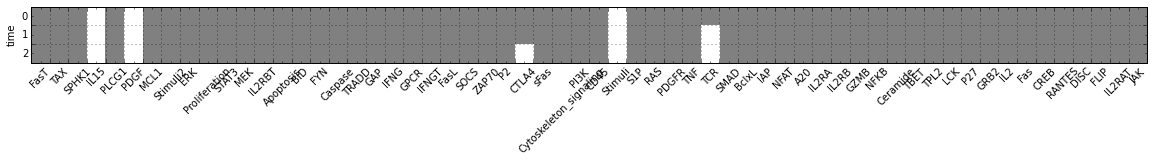

['Stimuli-0', 'IL15-0', 'PDGF-1'] 19


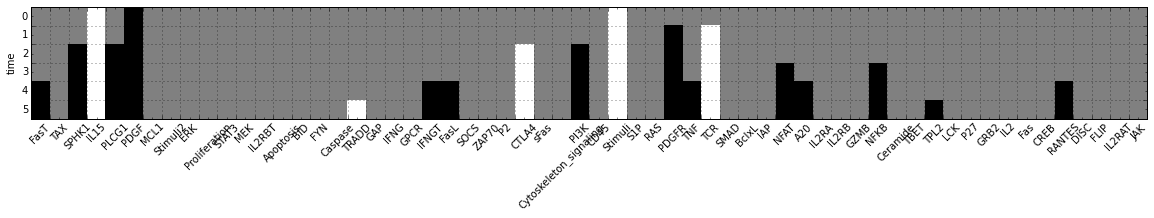

['Stimuli-0', 'IL15-1', 'PDGF-0'] 7


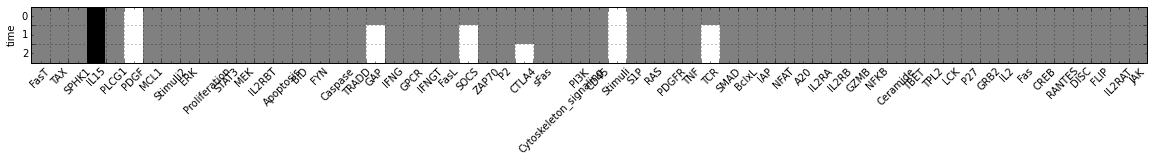

['Stimuli-0', 'IL15-1', 'PDGF-1'] 24


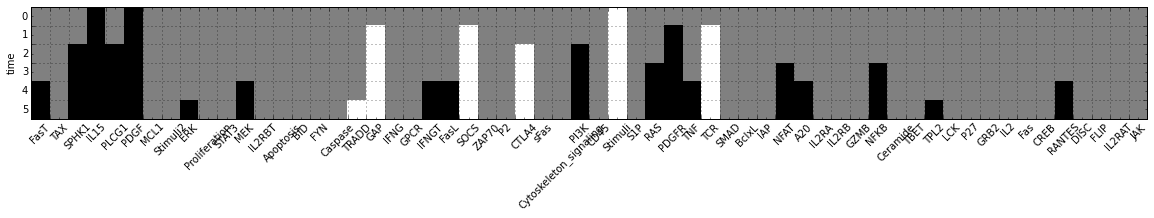

['Stimuli-1', 'IL15-0', 'PDGF-0'] 3


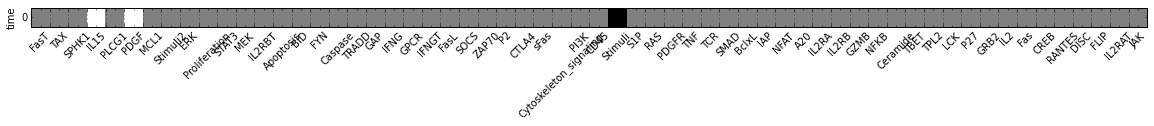

['Stimuli-1', 'IL15-0', 'PDGF-1'] 17


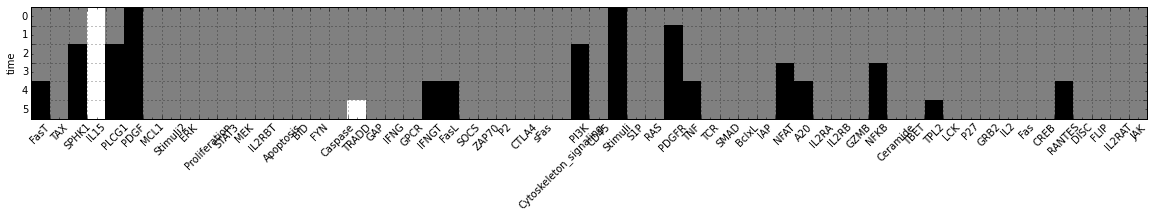

['Stimuli-1', 'IL15-1', 'PDGF-0'] 5


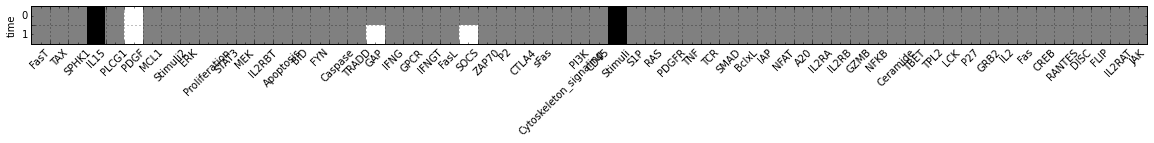

['Stimuli-1', 'IL15-1', 'PDGF-1'] 22


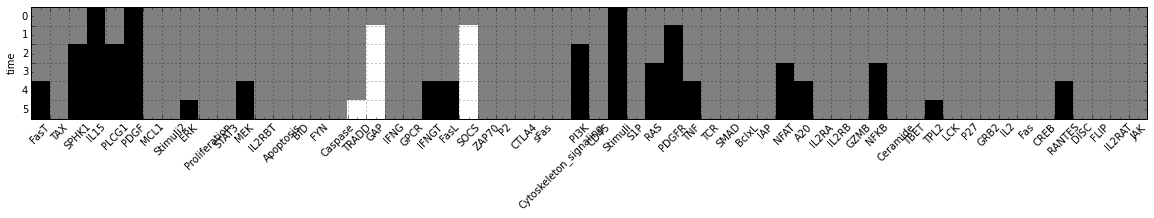

In [813]:
#print BFS_threshold(DM3,['Stimuli-1', 'IL15-1', 'PDGF-1']) #['IL15-1', 'S1P-1', 'CD45-0'], ['IL15-1', 'S1P-1', 'JAK-1'], 
#['TBET-1', 'IL15-1', 'PDGF-1'], ['Stimuli-1', 'IL15-1', 'PDGF-1']

#test all 8 combinations of the starting nodes
for seed in [['Stimuli-0', 'IL15-0', 'PDGF-0'],['Stimuli-0', 'IL15-0', 'PDGF-1'],['Stimuli-0', 'IL15-1', 'PDGF-0'],
            ['Stimuli-0', 'IL15-1', 'PDGF-1'],['Stimuli-1', 'IL15-0', 'PDGF-0'],['Stimuli-1', 'IL15-0', 'PDGF-1'],
            ['Stimuli-1', 'IL15-1', 'PDGF-0'],['Stimuli-1', 'IL15-1', 'PDGF-1']]:
    #print BFS_threshold(DM3,seed),sizes[str(seed)],"\n"
    print seed,sizes[str(seed)]
    visualize_unfolding(DM3,seed,figsize=(20,50))
    

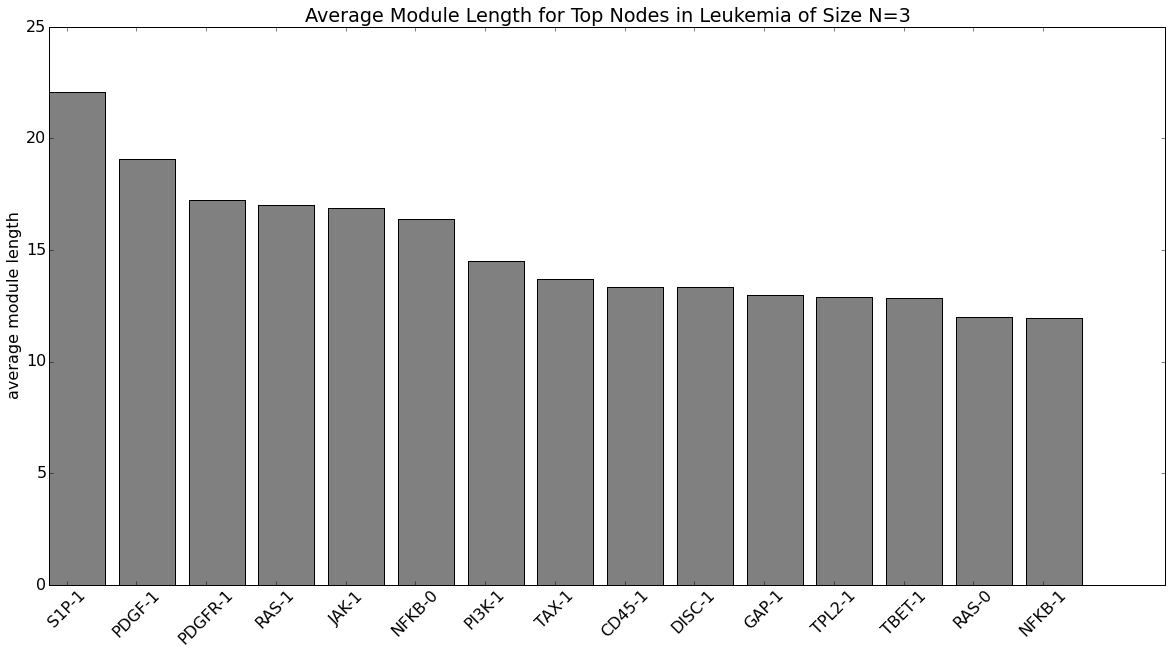

In [45]:
#visualize average module size per node, based on node contributions and num above
top=15
figsize=(20,10)
labels=[node for node in sorted(node_contributions,key=lambda x: node_contributions[x][0]/node_contributions[x][1],reverse=True)[:top]]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
#fig, ax = plt.subplots()
ax.bar([i for i in range(len(labels))],[node_contributions[x][0]/node_contributions[x][1] for x in labels],color='grey')

ax.set_xticks([i+0.25 for i in range(len(labels))])
ax.set_xticklabels(labels, rotation=45)
plt.ylabel("average module length")
plt.title("Average Module Length for Top Nodes in Leukemia of Size N="+str(num))
plt.show()

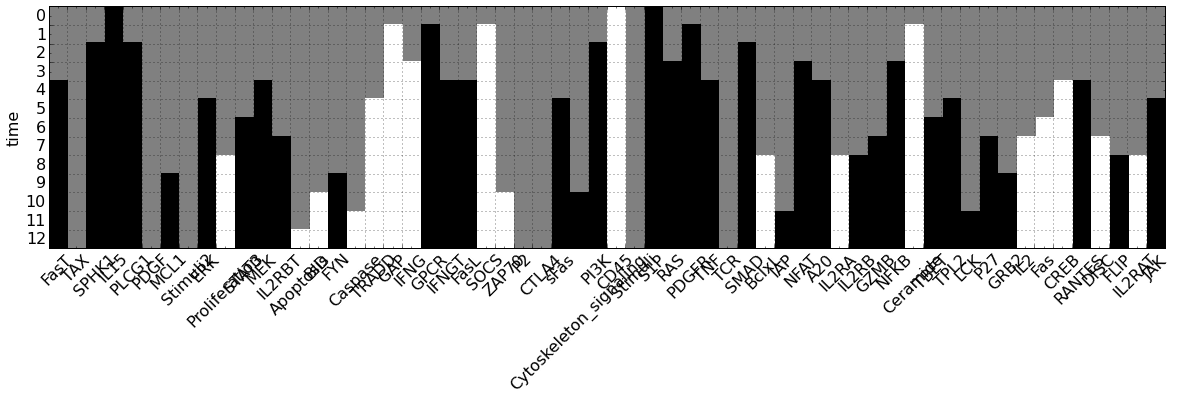

['IL15-1', 'S1P-1', 'CD45-0'] 53


In [57]:
seed=['IL15-1', 'S1P-1', 'CD45-0']  #['IL15-1', 'S1P-1', 'CD45-0'] , ['IL15-1', 'S1P-1', 'JAK-1'] 
visualize_unfolding(DM3,seed,node_set=None,input_type='steady',time_limit=1,figsize=(20,20))
print seed, sizes[str(seed)], #len(node_sets[str(seed)])

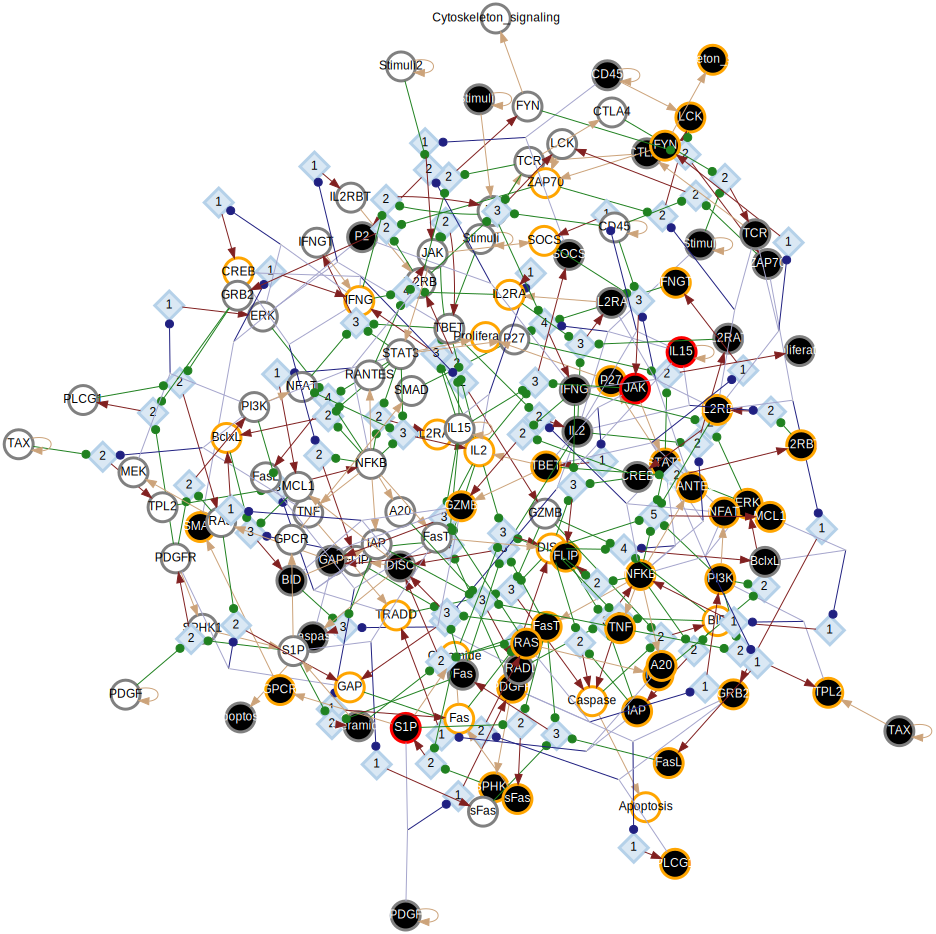

In [819]:
seed=['IL15-1', 'S1P-1', 'JAK-1']  #['IL15-1', 'S1P-1', 'CD45-0'] , ['IL15-1', 'S1P-1', 'JAK-1'] 
visualize_pathway(DM3,seed,input_type='steady')

In [261]:
#record all dynamic modules that include key nodes
num=5 #numbers 4+ are no longer instantaneous for drosophila, 3+ for leukemia takes a long time, don't print more than a few
input_type='pulse' #NOTE: if pulse, use time_limit=2 to catch unstable states
nu,tm,sizes=find_dynamic_modules(DM3,input_type=input_type,num=num,time_limit=2,samples=1000000)
#node='Caspase-0'
#print nu[node],{x for t in nu[node] for x in nu[node][t] if (max(nu[node])-t<=1)}
#print {x for t in nu[node] for x in nu[node][t] if len(nu[node])>1 
#                 and x in nu[node][max(nu[node])] and x in nu[node][max(nu[node])-1]}

In [268]:
key_nodes=['Apoptosis-0'] #['Apoptosis-1','Proliferation-1']

#node_sets={node:{x for t in nu[node] for x in nu[node][t]} for node in nu}
node_sets={node:nu[node][max(nu[node])] for node in nu} #alternative to just check last step for pulse

total=0
#determine how much each single node contributes, i.e. the total number of control modules the node appears in
node_contributions = {node:0 for node in DM3.nodes() if DM3.node[node]['type']=='variable'} 
                   
for node in sorted(sizes,key=lambda x:sizes[x],reverse=True): 
    for key in key_nodes:
        if key in node_sets[node] and key not in node:
            total+=1
            for key2 in node_contributions:
                if key2 in node:
                    node_contributions[key2]+=1
            #print node,nu[node]
print "Found: ",total

Found:  6353


['Caspase-0', 'FasT-0', 'DISC-0', 'MCL1-1', 'BclxL-1', 'BID-0', 'IAP-1', 'Fas-0', 'Fas-1', 'IL2RBT-1', 'Ceramide-0', 'ERK-1', 'MEK-1', 'SMAD-0', 'CREB-1'] [4420, 1179, 1081, 893, 813, 732, 683, 657, 389, 371, 371, 359, 355, 350, 345]


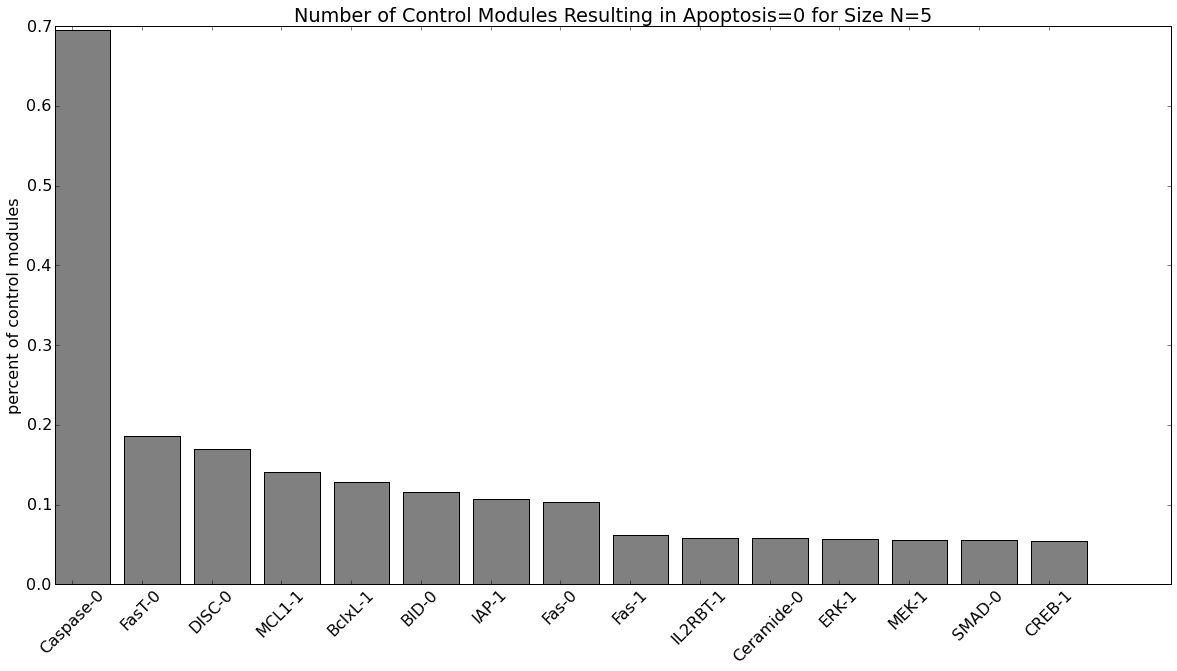

In [270]:
#visualize contributions per node leading towards specific outcome, based on node contributions and num above
top=15
figsize=(20,10)
labels=[node for node in sorted(node_contributions,key=lambda x:node_contributions[x],reverse=True)[:top]]
print labels,[node_contributions[x] for x in labels]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
#fig, ax = plt.subplots()
ax.bar([i for i in range(len(labels))],[node_contributions[x]/total for x in labels],color='grey')

ax.set_xticks([i+0.25 for i in range(len(labels))])
ax.set_xticklabels(labels, rotation=45)
plt.ylabel("percent of control modules")
plt.title("Number of Control Modules Resulting in Apoptosis=0 for Size N="+str(num))
plt.show()

In [5]:
#print BFS_threshold(DM3,['DISC-1'],input_type='steady')
#['JAK-1', 'RAS-0', 'S1P-1']
#['MEK-0', 'S1P-1', 'JAK-1']
#print BFS_threshold(DM3,['JAK-1'],input_type='pulse',time_limit=2)
#del nu,tm,sizes
#del node_sets

In [32]:
#find dynamic modules
print "Size of network: ",len(N3.nodes)#,len(attractors_thaliana),"attractors"
num=9
#print len([top for top in tmi if len(nmi[top])==num])
#gci,mci,tmi,nmi=DCM_min_coverage(DM3,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tmi,key=lambda x: len({y for t in tmi[x] for y in tmi[x][t]}),reverse=True):
    if len(nmi[top])==num:
        seed=[s for s in nmi[top]]
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        print top,"\tLength:",len({x for t in tmi[top] for x in tmi[top][t]})#,[x for t in tmi[top] for x in tmi[top][t]]
        #print "\tReachable attractors:",int(unfolding_attractors(DMT,seed,attractors=attractors_thaliana,input_type='steady')[1]*10)
if gci: print gci,len(gci)
else: print mci
nodes_seen=set([])
for top in tmi:
    nodes_seen=nodes_seen.union({x for t in tmi[top] for x in tmi[top][t]})

Size of network:  60
['Stimuli-0', 'IFNG-1', 'Stimuli2-0', 'CD45-0', 'PDGF-1', 'IAP-1', 'TAX-0', 'PI3K-0', 'IL15-1'] 	Length: 60
['BclxL-1', 'Stimuli-0', 'CD45-0', 'PDGF-0', 'Stimuli2-1', 'TAX-1', 'IL15-1', 'Ceramide-1', 'GAP-1'] 	Length: 60
['Stimuli-0', 'Stimuli2-0', 'IFNG-1', 'CD45-0', 'PLCG1-0', 'TAX-0', 'PI3K-0', 'PDGF-1', 'IL15-1'] 	Length: 60
['Stimuli-0', 'Stimuli2-0', 'IFNG-1', 'CD45-0', 'PDGF-1', 'CREB-1', 'TAX-0', 'PI3K-0', 'IL15-1'] 	Length: 60
['Stimuli2-1', 'Stimuli-0', 'CD45-0', 'PDGF-0', 'GAP-1', 'TAX-1', 'IL15-1', 'Ceramide-1', 'MCL1-1'] 	Length: 60
['Stimuli-0', 'IFNG-1', 'Stimuli2-0', 'PDGF-1', 'IAP-1', 'TBET-0', 'TAX-0', 'NFKB-0', 'CD45-1'] 	Length: 59
['Stimuli-0', 'CD45-1', 'Stimuli2-1', 'GAP-1', 'TBET-0', 'TAX-0', 'NFKB-0', 'Ceramide-1', 'PDGF-1'] 	Length: 59
['Stimuli-0', 'CD45-1', 'Stimuli2-1', 'PDGFR-0', 'IAP-1', 'TBET-0', 'IL15-1', 'NFKB-0', 'TAX-0'] 	Length: 59
['IFNG-1', 'Stimuli2-0', 'CD45-0', 'PDGF-1', 'IAP-1', 'TCR-1', 'TAX-0', 'PI3K-0', 'IL15-1'] 	Lengt

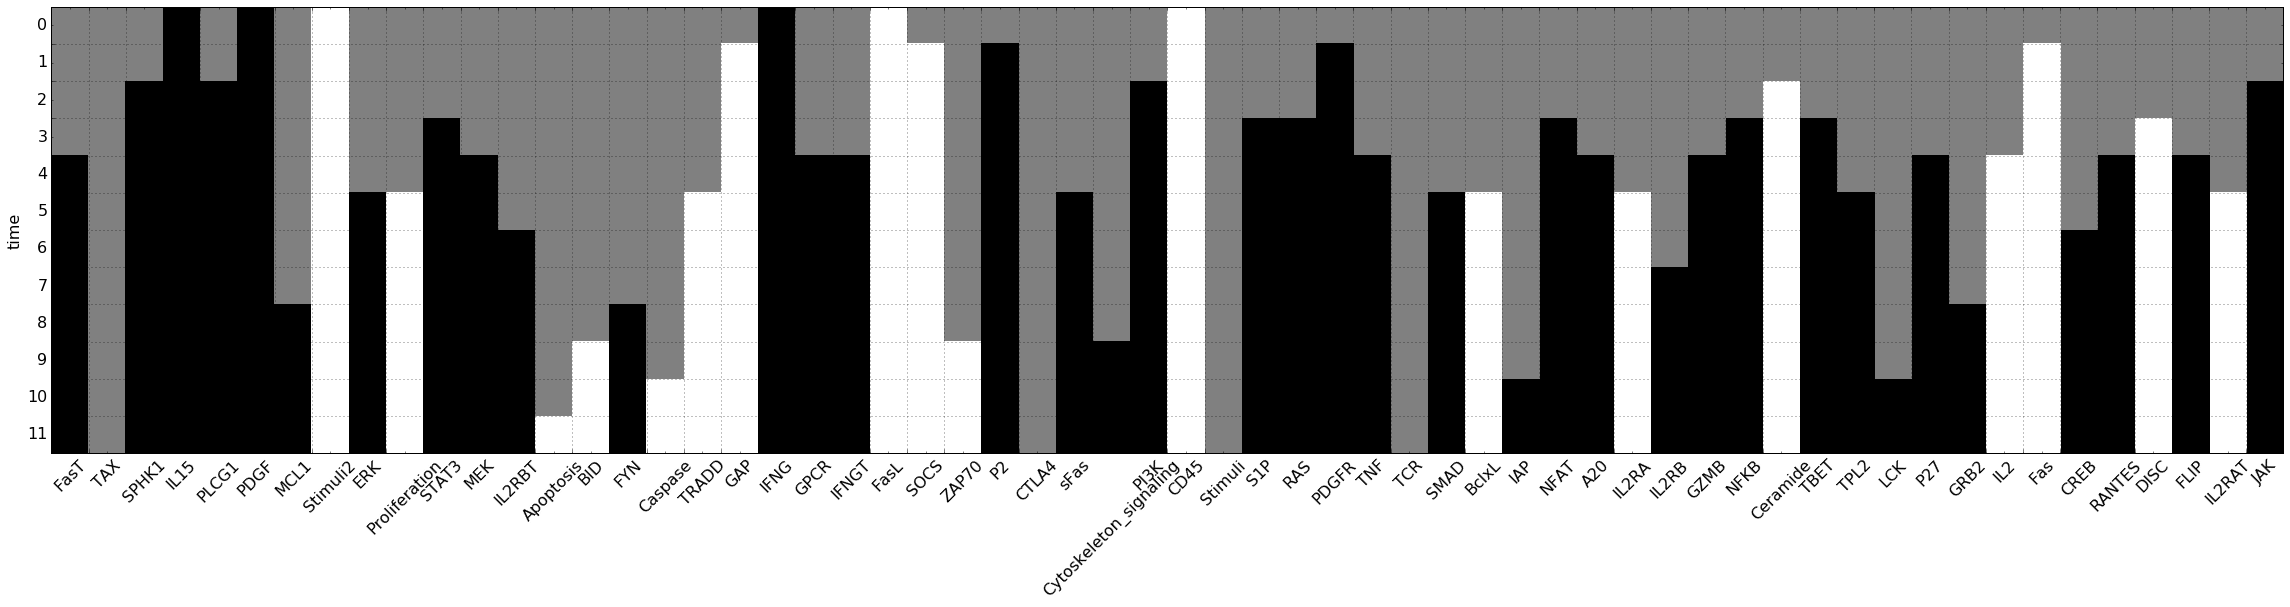

In [135]:
#visualize possible unfoldings to attractors
seed=['IL15-0', 'TAX-0', 'Stimuli-0', 'JAK-1', 'CD45-0', 'PDGFR-0','PDGF-0','Stimuli2-0','P2-0']
seed=['TBET-0', 'CD45-0', 'Stimuli-0', 'Ceramide-1', 'Stimuli2-1', 'PDGF-1','TAX-0','IL15-0','IL2RA-0'] 
seed=['TAX-1', 'Stimuli-0', 'TBET-0', 'CD45-1', 'GRB2-0', 'PDGFR-0'] #apoptosis ON
seed=['IL15-1', 'FasL-0', 'Stimuli2-0', 'IFNG-1', 'CD45-0', 'PDGF-1'] #apoptosis OFF
visualize_unfolding(DM3,seed,input_type='steady',figsize=(40,20))

In [1601]:
#find dynamic modules
print "Size of network: ",len(N3.nodes)#,len(attractors_thaliana),"attractors"
num=9
#print len([top for top in tmi if len(nmi[top])==num])
gcl,mcl,tml,nml=DCM_min_coverage(DM3,num=num,k=1,input_type='steady',time_limit=1,conversion=True,seeds=None,ind_test=True)
for top in sorted(tml,key=lambda x: len({y for t in tml[x] for y in tml[x][t]}),reverse=True):
    if len(nml[top])==num:
        seed=[s for s in nml[top]]
        #if unfolding_attractors(DCM,seed,attractors=attractors,input_type='steady')[1]!=0:
        print top,"\tLength:",len({x for t in tml[top] for x in tml[top][t]})#,[x for t in tmi[top] for x in tmi[top][t]]
        #print "\tReachable attractors:",int(unfolding_attractors(DMT,seed,attractors=attractors_thaliana,input_type='steady')[1]*10)
if gcl: print gcl,len(gcl)
else: print mcl
nodes_seen=set([])
for top in tml:
    nodes_seen=nodes_seen.union({x for t in tml[top] for x in tml[top][t]})

Size of network:  60
Running iteration: 1	
top modules found: 48
Running iteration: 2	
top modules found: 64
Running iteration: 3	
top modules found: 223
Running iteration: 4	
top modules found: 646
Running iteration: 5	
top modules found: 1446
Running iteration: 6	
top modules found: 2353
Running iteration: 7	
top modules found: 2759
Running iteration: 8	
top modules found: 2501
Running iteration: 9	
top modules found: 1798
['Stimuli-0', 'IFNG-1', 'Stimuli2-0', 'CD45-0', 'PDGF-1', 'IAP-1', 'TAX-0', 'PI3K-0', 'IL15-1'] 	Length: 60
['BclxL-1', 'Stimuli-0', 'CD45-0', 'PDGF-0', 'Stimuli2-1', 'TAX-1', 'IL15-1', 'Ceramide-1', 'GAP-1'] 	Length: 60
['Stimuli-0', 'Stimuli2-0', 'IFNG-1', 'CD45-0', 'PLCG1-0', 'TAX-0', 'PI3K-0', 'PDGF-1', 'IL15-1'] 	Length: 60
['Stimuli-0', 'Stimuli2-0', 'IFNG-1', 'CD45-0', 'PDGF-1', 'CREB-1', 'TAX-0', 'PI3K-0', 'IL15-1'] 	Length: 60
['Stimuli2-1', 'Stimuli-0', 'CD45-0', 'PDGF-0', 'GAP-1', 'TAX-1', 'IL15-1', 'Ceramide-1', 'MCL1-1'] 	Length: 60
['Stimuli-0', 'IFNG

In [1618]:
#use greedy heuristic to check for cover
q=2
#lcovers={}
s=9
nodes=[x for x in DM3 if DM3.node[x]['type']=='variable']
#new_modules=filter_modules(DCM,tm,nm,attractors,input_type='steady',time_limit=1,conversion=True)
tml_bit = {key: tml[key] for key in tml if len(nml[key])<=s}
print len(tml),len(tml_bit),len(new_modules)
print len(tml_bit)#,len(new_modules)
cover,mc = graph_cover(tml_bit,nodes,q=q,approximate=True) #new_modules
#print type(cover),type(cover[0]),cover[0],len(cover[0])
#print cover, mc, len(cover[0]), len(cover)
score,max_cover=compare_cover_independence(DM3,cover,nml,attractors=None)
#dcovers[str(q)]=max_cover
#dcovers[str(num)]=max_cover
#lcovers[str(s)]=max_cover
print score, len(cover) #,mc
#print cover
#for c in cover:
#    print test_cover_independence(DCM,c,nm)
if max_cover: 
    print test_cover_independence(DM3,max_cover,nml)
    #analyze cover
    lengths=[]
    for module in max_cover:
        lengths.append(len({x for t in tml[module] for x in tml[module][t]}))
    print lengths, len(lengths), np.mean(lengths), max(lengths)

11838 11838 15
11838
0.639303582596 1
{"['Stimuli-0']": 1.0, "['IL2-1']": 0.3333333333333333, "['ZAP70-1']": 0.3333333333333333, "['P2-1']": 0.3333333333333333, "['CD45-0']": 1.0, "['BclxL-1']": 0.5, "['CD45-1']": 0.125, "['Proliferation-1']": 1.0, "['Stimuli2-1']": 1.0, "['TPL2-0']": 1.0, "['Caspase-0']": 1.0, "['CREB-1']": 1.0, "['GAP-1']": 0.125, "['Stimuli2-0']": 1.0, "['IL2RA-1']": 1.0, "['IL2RBT-1']": 1.0, "['IAP-1']": 0.5, "['PDGFR-0']": 0.3333333333333333, "['Fas-1']": 1.0, "['SOCS-1', 'PDGF-1', 'LCK-0', 'NFKB-0', 'PI3K-0', 'PLCG1-0']": 0.2857142857142857, "['FYN-0']": 1.0, "['GZMB-0']": 1.0, "['IL15-1']": 0.3333333333333333, "['TBET-0']": 0.25, "['TCR-1']": 0.3333333333333333, "['MCL1-1']": 0.5, "['PDGF-0']": 1.0, "['IL15-0']": 1.0, "['S1P-1']": 0.041666666666666664, "['Stimuli-1']": 1.0, "['IL2RAT-1']": 1.0, "['TAX-1', 'FasL-0']": 0.07692307692307693, "['JAK-1']": 0.4166666666666667, "['IFNGT-0']": 0.3333333333333333, "['DISC-1']": 0.5, "['IFNG-1']": 1.0, "['IL2RB-1']": 0.142

In [1324]:
print len(lcovers)

6


In [16]:
#compare to FVS
fvs=N3.feedback_vertex_set_driver_nodes() #method='bruteforce'
fvs_superset=set([])
for x in fvs:
    #print '\n'
    for node in sorted(x): 
        #print N2.nodes[node]
        fvs_superset.add(node)
print fvs_superset, len(fvs_superset)
for node in sorted(fvs_superset):
    print N3.nodes[node]

set([4, 6, 9, 10, 14, 20, 21, 22, 26, 27, 30, 31, 32, 35, 38, 40, 45, 46, 49, 54, 55, 56, 57, 58, 59]) 25
<BNode(name='Cytoskeleton_signaling', k=1, inputs=[FYN], state=0, outputs='[0,1]' constant=False)>
<BNode(name='ZAP70', k=2, inputs=[FYN,LCK], state=0, outputs='[0,1,0,0]' constant=False)>
<BNode(name='RAS', k=3, inputs=[GRB2,PLCG1,GAP], state=0, outputs='[0,0,1,0,1,0,1,0]' constant=False)>
<BNode(name='GAP', k=5, inputs=[PDGFR,RAS,GAP,IL2,IL15], state=0, outputs='[0,0,0,0...1,0,0,0]' constant=False)>
<BNode(name='NFKB', k=5, inputs=[PI3K,TPL2,TRADD,FLIP,IAP], state=0, outputs='[0,0,0,0...1,1,1,1]' constant=False)>
<BNode(name='IL2RAT', k=3, inputs=[NFKB,IL2,STAT3], state=0, outputs='[0,0,0,1,0,0,1,1]' constant=False)>
<BNode(name='IL2RA', k=3, inputs=[IL2,IL2RAT,IL2RA], state=0, outputs='[0,0,0,0,0,0,1,0]' constant=False)>
<BNode(name='JAK', k=6, inputs=[RANTES,IL2RB,IL2RA,SOCS,IFNG,CD45], state=0, outputs='[0,0,1,0...0,0,0,0]' constant=False)>
<BNode(name='Proliferation', k=2, in